In [ ]:
# Connecting to Google Drive where dataset is stored
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/cleaned_spy_options.csv'

# Importing necessary libraries for visuals and to run LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

Mounted at /content/drive


In [ ]:
# Quick Data Check
data = pd.read_csv(data_path)

print(f"Data shape: {data.shape}")
print("\nFirst 5 rows:")
print(data.head())
print("\nData types:")
print(data.dtypes)
print("\nMissing values:")
print(data.isna().sum())

Data shape: (5217236, 6)

First 5 rows:
         date      exdate  strike_price cp_flag  underlying_price  \
0  2017-08-31  2017-09-11        2075.0       P           2471.65   
1  2017-08-31  2017-09-11        2100.0       P           2471.65   
2  2017-08-31  2017-09-11        2130.0       P           2471.65   
3  2017-08-31  2017-09-11        2220.0       P           2471.65   
4  2017-08-31  2017-09-11        2235.0       P           2471.65   

   impl_volatility  
0         0.334710  
1         0.333985  
2         0.307310  
3         0.252611  
4         0.243809  

Data types:
date                 object
exdate               object
strike_price        float64
cp_flag              object
underlying_price    float64
impl_volatility     float64
dtype: object

Missing values:
date                0
exdate              0
strike_price        0
cp_flag             0
underlying_price    0
impl_volatility     0
dtype: int64


In [ ]:
#Preprocessing Data

data['date'] = pd.to_datetime(data['date'])
data['exdate'] = pd.to_datetime(data['exdate'])
data['time_to_expiry'] = (data['exdate'] - data['date']).dt.days
data['strike_price_normalized'] = data['strike_price']
data['moneyness'] = data['strike_price_normalized'] / data['underlying_price']
data = data.dropna(subset=['impl_volatility'])
print(f"Data shape after removing missing values: {data.shape}")

duplicate_count = data.duplicated(subset=['date', 'exdate', 'strike_price', 'cp_flag']).sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    data = data.drop_duplicates(subset=['date', 'exdate', 'strike_price', 'cp_flag'])
    print(f"Data shape after removing duplicates: {data.shape}")

data = data.sort_values(by=['date', 'exdate', 'strike_price', 'cp_flag'])

unique_dates = data['date'].unique()
print(f"Number of unique trading dates: {len(unique_dates)}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")

Data shape after removing missing values: (5217236, 9)
Number of duplicate rows: 0
Number of unique trading dates: 1510
Date range: 2017-08-31 00:00:00 to 2023-08-31 00:00:00


In [ ]:
moneyness_stats = data['moneyness'].describe()
print("Raw moneyness statistics:")
print(moneyness_stats)

Raw moneyness statistics:
count    5.217236e+06
mean     9.448005e-01
std      1.458966e-01
min      2.086350e-02
25%      8.951796e-01
50%      9.755151e-01
75%      1.020517e+00
max      2.292405e+00
Name: moneyness, dtype: float64


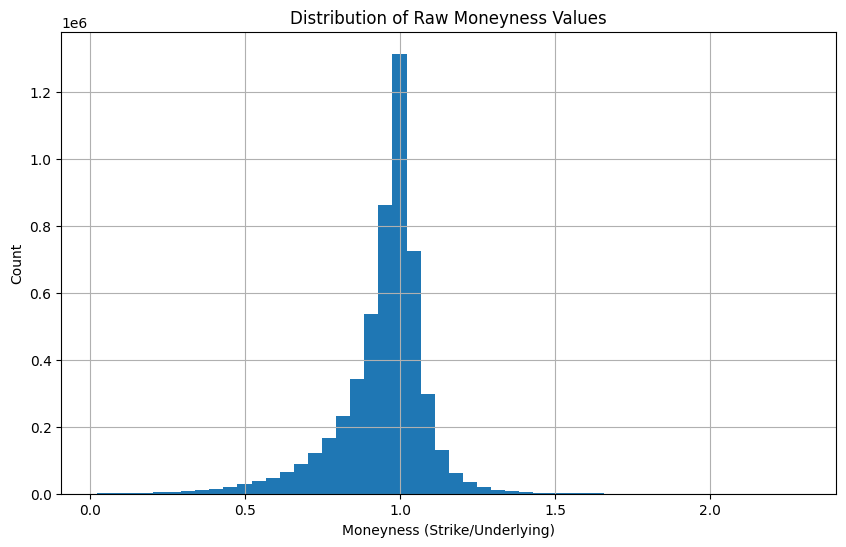

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['moneyness'], bins=50)
plt.title('Distribution of Raw Moneyness Values')
plt.xlabel('Moneyness (Strike/Underlying)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [ ]:
# Discretize the expiry and moneyness into buckets to make the IVS construction easier
def get_expiry_bucket(days):
    if days <= 7:
        return 7
    elif days <= 30:
        return 30
    elif days <= 60:
        return 60
    elif days <= 90:
        return 90
    elif days <= 180:
        return 180
    else:
        return 365

data['expiry_bucket'] = data['time_to_expiry'].apply(get_expiry_bucket)

def get_moneyness_bucket(moneyness):
    buckets = np.arange(0.7, 1.35, 0.05)
    return buckets[np.abs(buckets - moneyness).argmin()]

data['moneyness_bucket'] = data['moneyness'].apply(get_moneyness_bucket)

calls = data[data['cp_flag'] == 'C']
puts = data[data['cp_flag'] == 'P']

print("\nDistribution of options by expiry bucket:")
print(data['expiry_bucket'].value_counts().sort_index())

print("\nDistribution of options by moneyness bucket:")
print(data['moneyness_bucket'].value_counts().sort_index())

def check_surface_completeness(date, min_expiry=3, min_moneyness=7):
    day_data = calls[calls['date'] == date]
    unique_expiry = day_data['expiry_bucket'].nunique()
    unique_moneyness = day_data['moneyness_bucket'].nunique()
    return unique_expiry >= min_expiry and unique_moneyness >= min_moneyness

complete_surfaces = [date for date in unique_dates if check_surface_completeness(date)]
print(f"\nDates with complete volatility surfaces: {len(complete_surfaces)} out of {len(unique_dates)}")


Distribution of options by expiry bucket:
expiry_bucket
30     2093356
60     1326143
90      555123
180     803353
365     439261
Name: count, dtype: int64

Distribution of options by moneyness bucket:
moneyness_bucket
0.70     389698
0.75     158023
0.80     226578
0.85     338491
0.90     553708
0.95     929611
1.00    1419050
1.05     701778
1.10     265014
1.15     110449
1.20      52675
1.25      28095
1.30      16322
1.35      27744
Name: count, dtype: int64

Dates with complete volatility surfaces: 1510 out of 1510


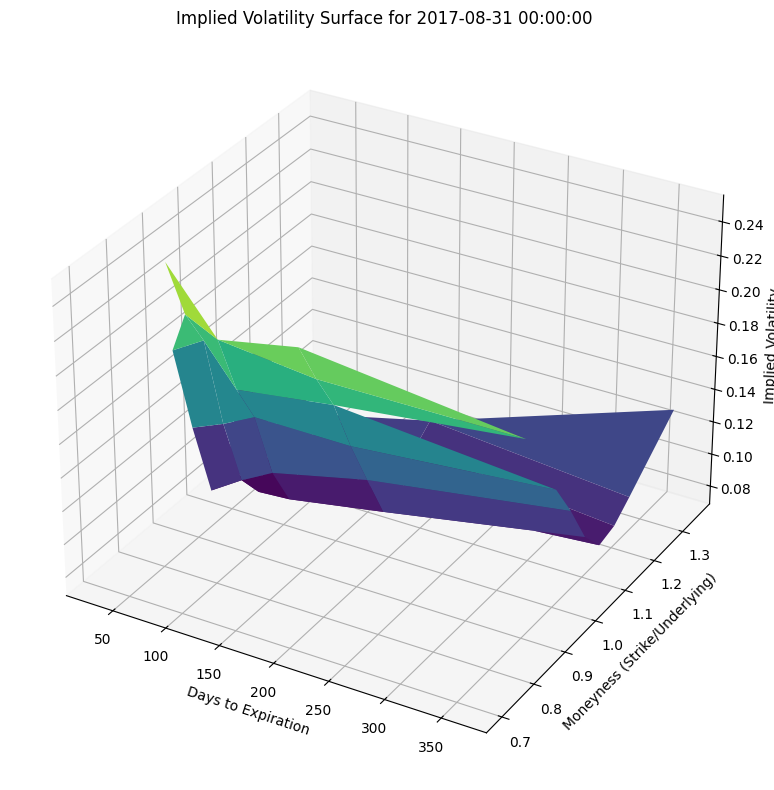

In [ ]:
#Visualize the current IVS (prior to interpolation)

def plot_vol_surface(date_str):
    date = pd.to_datetime(date_str)
    day_data = calls[calls['date'] == date]

    if len(day_data) == 0:
        print(f"No call options data for {date_str}")
        return

    pivot = day_data.pivot_table(
        values='impl_volatility',
        index='moneyness_bucket',
        columns='expiry_bucket',
        aggfunc='mean'
    )


    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x, y = np.meshgrid(pivot.columns, pivot.index)
    ax.plot_surface(x, y, pivot.values, cmap='viridis')

    ax.set_xlabel('Days to Expiration')
    ax.set_ylabel('Moneyness (Strike/Underlying)')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(f'Implied Volatility Surface for {date_str}')

    plt.tight_layout()
    plt.show()

if len(complete_surfaces) > 0:
    sample_date = complete_surfaces[0]
    plot_vol_surface(sample_date)

In [ ]:
# Creating smooth IVS surfaces with interpolation
def create_vol_surface(date, call_data, moneyness_levels, expiry_buckets):

    day_data = call_data[call_data['date'] == date]

    surface = np.zeros((len(moneyness_levels), len(expiry_buckets)))
    surface.fill(np.nan)

    for i, m in enumerate(moneyness_levels):
        for j, e in enumerate(expiry_buckets):
            subset = day_data[(day_data['moneyness_bucket'] == m) &
                              (day_data['expiry_bucket'] == e)]
            if not subset.empty:
                surface[i, j] = subset['impl_volatility'].mean()

    from scipy import interpolate

    for j in range(surface.shape[1]):
        col = surface[:, j]
        mask = ~np.isnan(col)
        if np.sum(mask) > 1:
            indices = np.arange(surface.shape[0])
            interp_func = interpolate.interp1d(
                indices[mask], col[mask],
                bounds_error=False, fill_value="extrapolate"
            )
            surface[:, j] = interp_func(indices)

    for i in range(surface.shape[0]):
        row = surface[i, :]
        mask = ~np.isnan(row)
        if np.sum(mask) > 1:
            indices = np.arange(surface.shape[1])
            interp_func = interpolate.interp1d(
                indices[mask], row[mask],
                bounds_error=False, fill_value="extrapolate"
            )
            surface[i, :] = interp_func(indices)

    global_mean = np.nanmean(surface)
    surface[np.isnan(surface)] = global_mean

    return surface

standard_moneyness = sorted(data['moneyness_bucket'].unique())
standard_expiry = sorted(data['expiry_bucket'].unique())

print(f"Standard moneyness levels: {standard_moneyness}")
print(f"Standard expiry buckets: {standard_expiry}")

filtered_dates = complete_surfaces

vol_surfaces = {}
for date in filtered_dates:
    vol_surfaces[date] = create_vol_surface(
        date, calls, standard_moneyness, standard_expiry
    )

print(f"Created {len(vol_surfaces)} volatility surfaces")

Standard moneyness levels: [np.float64(0.7), np.float64(0.75), np.float64(0.8), np.float64(0.8500000000000001), np.float64(0.9000000000000001), np.float64(0.9500000000000002), np.float64(1.0000000000000002), np.float64(1.0500000000000003), np.float64(1.1000000000000003), np.float64(1.1500000000000004), np.float64(1.2000000000000004), np.float64(1.2500000000000004), np.float64(1.3000000000000005), np.float64(1.3500000000000005)]
Standard expiry buckets: [np.int64(30), np.int64(60), np.int64(90), np.int64(180), np.int64(365)]
Created 1510 volatility surfaces


In [ ]:
# Sequences for LSTM
def create_sequences(surfaces, dates, lookback=20):

    X, y = [], []
    dates = sorted(dates)

    for i in range(lookback, len(dates)):
        seq = []
        for j in range(i - lookback, i):
            seq.append(surfaces[dates[j]])
        target = surfaces[dates[i]]
        X.append(np.array(seq))
        y.append(target)

    return np.array(X), np.array(y)


date_list = sorted(filtered_dates)


lookback = 20
X, y = create_sequences(vol_surfaces, date_list, lookback)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1490, 20, 14, 5)
y shape: (1490, 14, 5)


In [ ]:
# Splitting up data for training, validation, and testing
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


n_samples, time_steps, n_moneyness, n_expiry = X_train.shape
X_train_reshaped = X_train.reshape(n_samples, time_steps, n_moneyness * n_expiry)
X_val_reshaped = X_val.reshape(X_val.shape[0], time_steps, n_moneyness * n_expiry)
X_test_reshaped = X_test.reshape(X_test.shape[0], time_steps, n_moneyness * n_expiry)


y_train_reshaped = y_train.reshape(y_train.shape[0], n_moneyness * n_expiry)
y_val_reshaped = y_val.reshape(y_val.shape[0], n_moneyness * n_expiry)
y_test_reshaped = y_test.reshape(y_test.shape[0], n_moneyness * n_expiry)

Training set: 1043 samples
Validation set: 223 samples
Test set: 224 samples


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │       101,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 70)             │         4,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,614 (611.77 KB)

 Trainable params: 156,230 (610.27 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.8438

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.8317 - val_loss: 0.0800 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3947

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.3939 - val_loss: 0.0644 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3069

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.3064 - val_loss: 0.0556 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2481

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2478 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 5/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2056

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.2052 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 6/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1685

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.1681 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 7/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1399

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.1395 - val_loss: 0.0222 - learning_rate: 0.0010
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.1193 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 9/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0997

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0995 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 10/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0849

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0846 - val_loss: 0.0174 - learning_rate: 0.0010
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0710

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0710 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0610 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0513

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0513 - val_loss: 0.0160 - learning_rate: 0.0010
Epoch 14/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0428

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0428 - val_loss: 0.0159 - learning_rate: 0.0010
Epoch 15/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0378

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0377 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 16/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0326

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0325 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 17/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0283

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0282 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 18/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0241

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0240 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0203

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0203 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 20/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0178

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0178 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0151 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 22/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0138 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0116 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 24/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0100 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 25/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0096

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0096 - val_loss: 0.0118 - learning_rate: 5.0000e-04
Epoch 26/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0090 - val_loss: 0.0120 - learning_rate: 5.0000e-04
Epoch 27/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0080

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0081 - val_loss: 0.0113 - learning_rate: 5.0000e-04
Epoch 28/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0081 - val_loss: 0.0113 - learning_rate: 5.0000e-04
Epoch 29/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0075

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0075 - val_loss: 0.0110 - learning_rate: 5.0000e-04
Epoch 30/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0081 - val_loss: 0.0112 - learning_rate: 5.0000e-04
Epoch 31/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0071

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0071 - val_loss: 0.0108 - learning_rate: 5.0000e-04
Epoch 32/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0073 - val_loss: 0.0111 - learning_rate: 5.0000e-04
Epoch 33/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0065 - val_loss: 0.0110 - learning_rate: 5.0000e-04
Epoch 34/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0061 - val_loss: 0.0108 - learning_rate: 5.0000e-04
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0068 - val_loss: 0.0109 - learning_rate: 5.0000e-04
Epoch 36/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0058

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0058 - val_loss: 0.0106 - learning_rate: 5.0000e-04
Epoch 37/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0055 - val_loss: 0.0111 - learning_rate: 5.0000e-04
Epoch 38/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0062 - val_loss: 0.0109 - learning_rate: 5.0000e-04
Epoch 39/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0058 - val_loss: 0.0107 - learning_rate: 5.0000e-04
Epoch 40/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0052 - val_loss: 0.0107 - learning_rate: 5.0000e-04
Epoch 41/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0047

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0047 - val_loss: 0.0105 - learning_rate: 5.0000e-04
Epoch 42/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0055 - val_loss: 0.0107 - learning_rate: 5.0000e-04
Epoch 43/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0057 - val_loss: 0.0108 - learning_rate: 5.0000e-04
Epoch 44/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0045 - val_loss: 0.0109 - learning_rate: 5.0000e-04
Epoch 45/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0047 - val_loss: 0.0109 - learning_rate: 5.0000e-04
Epoch 46/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0045 - val_loss: 0.0105 - learning_rate: 5.0000e-04
Epoch 47/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0047 - val_loss: 0.0106 - learning_rate: 2.5000e-04
Epoch 48/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0050 - val_loss: 0.0108 - learning_rate: 2.5000e-04
Epoch 49/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0045

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0045 - val_loss: 0.0103 - learning_rate: 2.5000e-04
Epoch 50/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0050 - val_loss: 0.0105 - learning_rate: 2.5000e-04
Epoch 51/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0044 - val_loss: 0.0104 - learning_rate: 2.5000e-04
Epoch 52/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0041 - val_loss: 0.0106 - learning_rate: 2.5000e-04
Epoch 53/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0045 - val_loss: 0.0105 - learning_rate: 2.5000e-04
Epoch 54/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0047 - val_loss: 0.0104 - learning_rate: 2.5000e-04
Epoch 55/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0042 - val_loss: 0.0103 - learning_rate: 1.2500e-04
Epoch 56/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0048 - val_loss: 0.0104 - learning_rate: 1.2500e-04
Epoch 57/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0043 - val_loss: 0.0103 - lear

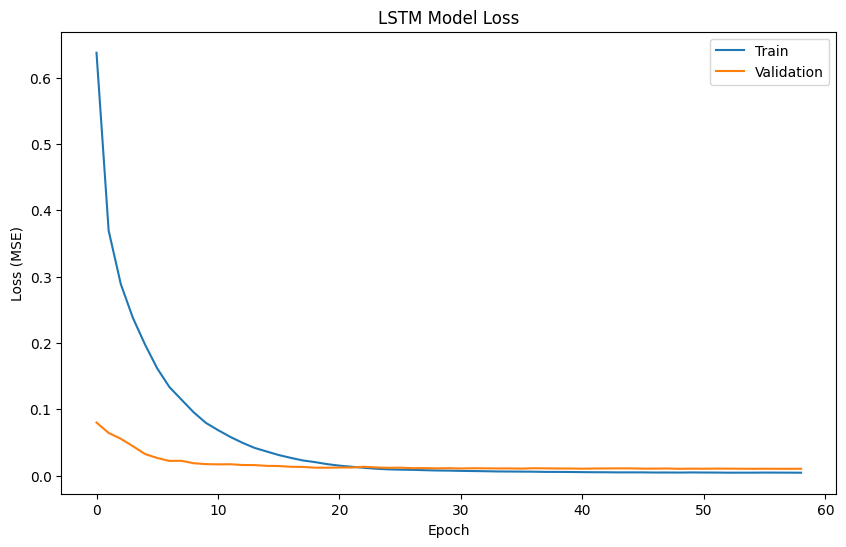

In [ ]:
# Build the base LSTM model
model = Sequential([
    LSTM(128, return_sequences=True,
         input_shape=(time_steps, n_moneyness * n_expiry)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),
    Dense(n_moneyness * n_expiry)  # Output entire volatility surface
])

# Compile model
model.compile(optimizer='adam', loss='mse')
model.summary()


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_vol_lstm.h5', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.0001)
]

# Train model
history = model.fit(
    X_train_reshaped, y_train_reshaped,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_reshaped),
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0106
Test MSE: 0.009009293280541897
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


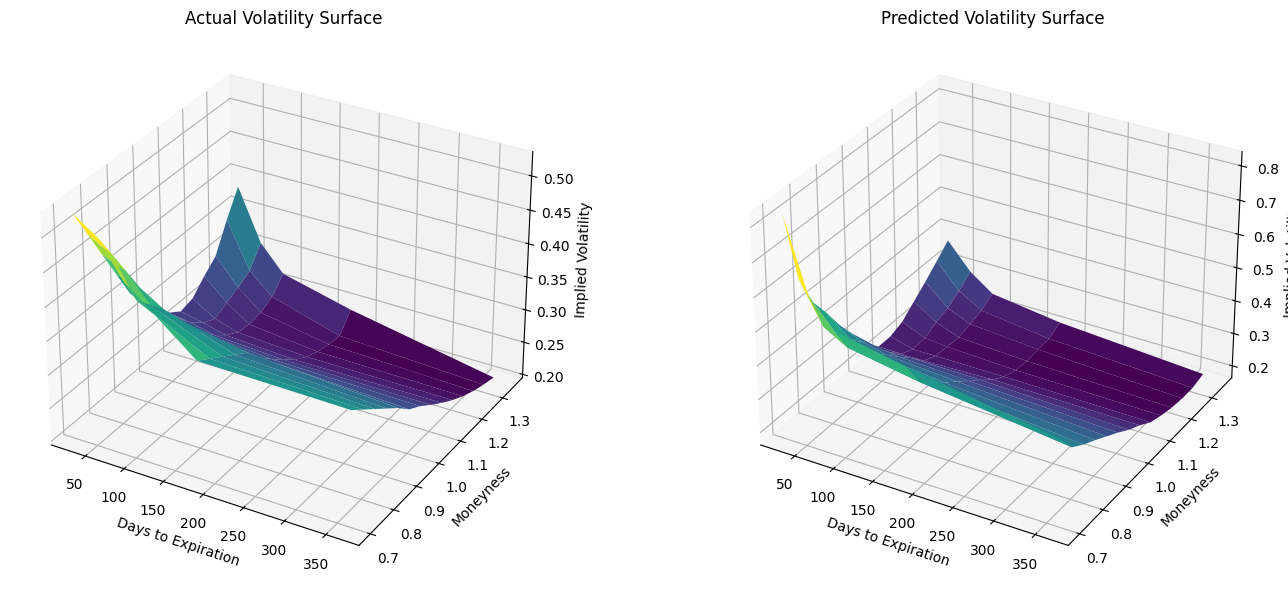

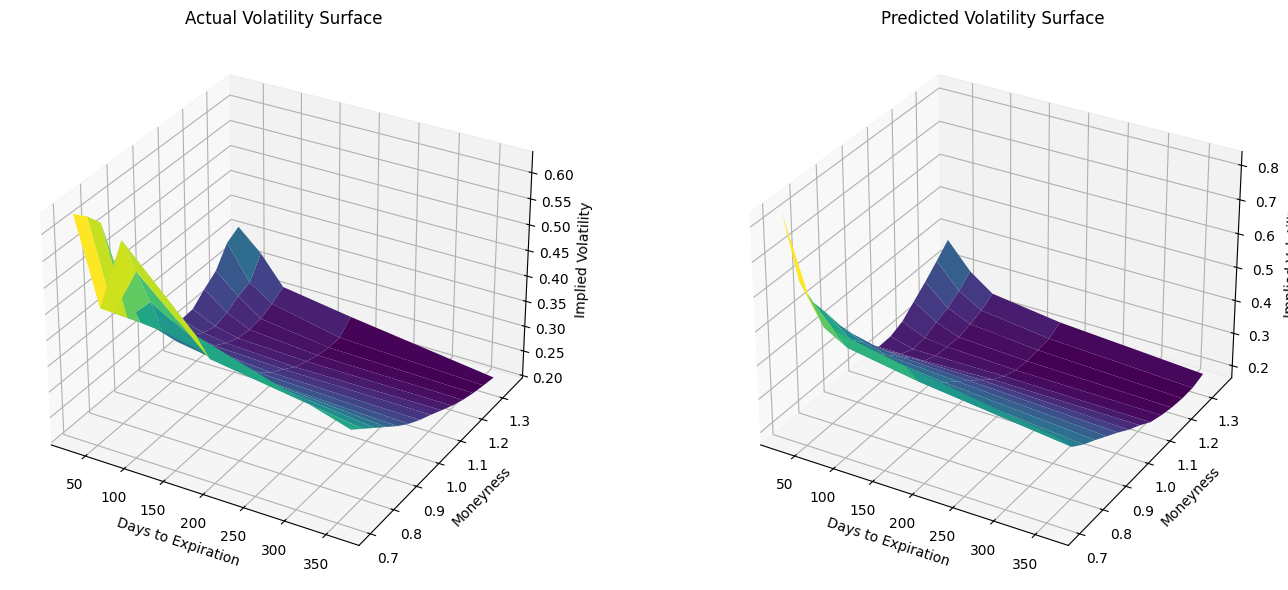

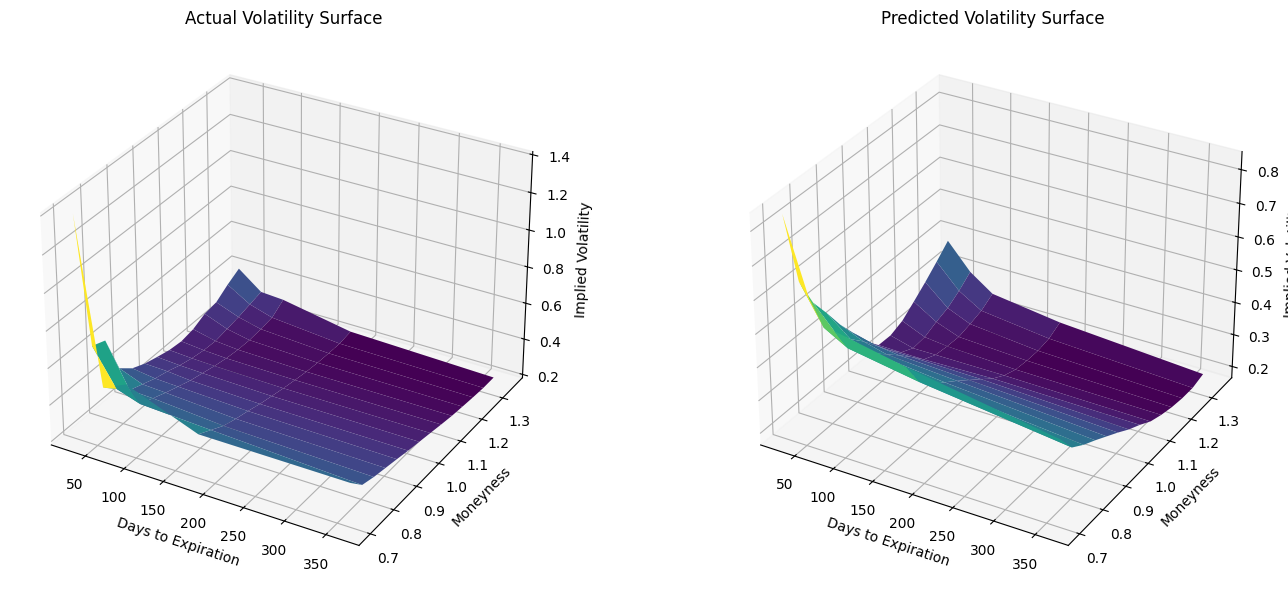

In [ ]:
# Evaluate on test set
test_loss = model.evaluate(X_test_reshaped, y_test_reshaped)
print(f"Test MSE: {test_loss}")

# Make predictions
y_pred = model.predict(X_test_reshaped)

y_pred_surfaces = y_pred.reshape(y_pred.shape[0], n_moneyness, n_expiry)
y_test_surfaces = y_test.reshape(y_test.shape[0], n_moneyness, n_expiry)

# Visualize predictions vs actual
def compare_surfaces(idx):
    fig = plt.figure(figsize=(15, 6))


    ax1 = fig.add_subplot(121, projection='3d')
    x, y = np.meshgrid(standard_expiry, standard_moneyness)
    ax1.plot_surface(x, y, y_test_surfaces[idx], cmap='viridis')
    ax1.set_title('Actual Volatility Surface')
    ax1.set_xlabel('Days to Expiration')
    ax1.set_ylabel('Moneyness')
    ax1.set_zlabel('Implied Volatility')


    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(x, y, y_pred_surfaces[idx], cmap='viridis')
    ax2.set_title('Predicted Volatility Surface')
    ax2.set_xlabel('Days to Expiration')
    ax2.set_ylabel('Moneyness')
    ax2.set_zlabel('Implied Volatility')

    plt.tight_layout()
    plt.show()

# Compare first 3 samples
for i in range(min(3, len(y_test_surfaces))):
    compare_surfaces(i)

In [ ]:
# Function to extract signals from IVS by exceeding given threshold
def extract_signals(actual_surfaces, pred_surfaces, threshold=0.01):

    signals = []

    for i in range(len(actual_surfaces)):
        # Find ATM volatility
        atm_idx = np.abs(np.array(standard_moneyness) - 1.0).argmin()

        # Get short-term and medium-term expiry indices
        short_term_idx = np.abs(np.array(standard_expiry) - 30).argmin()
        medium_term_idx = np.abs(np.array(standard_expiry) - 60).argmin()

        # Calculate predicted vs actual for ATM options
        actual_short_vol = actual_surfaces[i][atm_idx, short_term_idx]
        pred_short_vol = pred_surfaces[i][atm_idx, short_term_idx]

        actual_medium_vol = actual_surfaces[i][atm_idx, medium_term_idx]
        pred_medium_vol = pred_surfaces[i][atm_idx, medium_term_idx]

        # Calculate volatility differences
        short_diff = pred_short_vol - actual_short_vol
        medium_diff = pred_medium_vol - actual_medium_vol

        # Generate signal
        if short_diff > threshold and medium_diff > threshold:

            signal = "LONG_VOL"
        elif short_diff < -threshold and medium_diff < -threshold:

            signal = "SHORT_VOL"
        else:
            signal = "NEUTRAL"

        signals.append({
            'short_diff': short_diff,
            'medium_diff': medium_diff,
            'signal': signal
        })

    return signals

# Generate trading signals
test_signals = extract_signals(y_test_surfaces, y_pred_surfaces)

# Count signal types
signal_counts = {'LONG_VOL': 0, 'SHORT_VOL': 0, 'NEUTRAL': 0}
for signal in test_signals:
    signal_counts[signal['signal']] += 1

print("Signal distribution:")
for signal, count in signal_counts.items():
    print(f"{signal}: {count} ({count/len(test_signals)*100:.2f}%)")

Signal distribution:
LONG_VOL: 8 (3.57%)
SHORT_VOL: 119 (53.12%)
NEUTRAL: 97 (43.30%)


In [ ]:
# Generating signals based on signal extraction method created before

def generate_trading_signals(actual_surfaces, predicted_surfaces, dates,
                            moneyness_levels, expiry_buckets):

    signals = {}


    atm_idx = np.abs(np.array(moneyness_levels) - 1.0).argmin()


    short_exp_idx = np.abs(np.array(expiry_buckets) - 30).argmin()

    for i, date in enumerate(dates):
        if i >= len(actual_surfaces) or i >= len(predicted_surfaces):
            continue

        # Get actual and predicted volatility surfaces
        actual = actual_surfaces[i]
        predicted = predicted_surfaces[i]


        actual_vol = actual[atm_idx, short_exp_idx]
        predicted_vol = predicted[atm_idx, short_exp_idx]

        # Calculate volatility signal
        vol_signal = predicted_vol - actual_vol

        # Store signal
        signals[date] = vol_signal

    return signals

In [ ]:
# identifying type of trade to be executed

def determine_trades(signals, threshold=0.01):

    trades = {}

    for date, signal in signals.items():

        if signal > threshold:
            trades[date] = {
                'direction': 'LONG_VOL',
                'instrument': 'ATM_STRADDLE',
                'signal': signal
            }
        elif signal < -threshold:
            trades[date] = {
                'direction': 'SHORT_VOL',
                'instrument': 'ATM_STRADDLE',
                'signal': signal
            }
        else:
            trades[date] = {
                'direction': 'NO_TRADE',
                'instrument': None,
                'signal': signal
            }

    return trades

In [ ]:
# Creating hypothetical portfolio simulation with given capital and risk constrains
def apply_risk_management(trades, capital=100000, max_risk_per_trade=0.02):

    risk_managed_trades = {}

    for date, trade in trades.items():
        direction = trade['direction']
        signal = abs(trade['signal'])

        risk_fraction = min(signal * 2, max_risk_per_trade)
        position_size = capital * risk_fraction


        risk_managed_trades[date] = trade.copy()

        if direction != 'NO_TRADE':
            risk_managed_trades[date]['position_size'] = position_size
            risk_managed_trades[date]['risk_fraction'] = risk_fraction
        else:
            risk_managed_trades[date]['position_size'] = 0
            risk_managed_trades[date]['risk_fraction'] = 0

    return risk_managed_trades

In [ ]:
def calculate_option_price(volatility, underlying_price, days_to_expiry,
                           is_call=True, moneyness=1.0):


    strike = underlying_price * moneyness
    time_in_years = max(days_to_expiry / 365, 0.01)  # At least 1% of a year
    vol = max(min(volatility, 2.0), 0.01)  # Constrain vol between 1% and 200%

    # ATM option price approximation
    option_price = 0.4 * underlying_price * vol * np.sqrt(time_in_years)


    if is_call and moneyness < 1.0:  # ITM call
        option_price += (1.0 - moneyness) * underlying_price
    elif not is_call and moneyness > 1.0:  # ITM put
        option_price += (moneyness - 1.0) * underlying_price

    return max(option_price, 0.01)  # Ensure positive price

In [ ]:
def backtest_strategy(risk_managed_trades, actual_surfaces, dates,
                     moneyness_levels, expiry_buckets, underlying_prices):

    capital = 100000
    initial_capital = capital
    daily_returns = []
    equity_curve = [capital]
    positions = []
    trades_log = []

    atm_idx = np.abs(np.array(moneyness_levels) - 1.0).argmin()
    exp_30_idx = np.abs(np.array(expiry_buckets) - 30).argmin()

    open_positions = []


    for i in range(1, len(dates)):
        current_date = dates[i]
        prev_date = dates[i-1]


        current_price = underlying_prices[current_date]
        prev_price = underlying_prices[prev_date]
        current_vol = actual_surfaces[i][atm_idx, exp_30_idx]

        # Calculate P&L for existing positions
        day_pnl = 0
        closed_positions = []

        for j, position in enumerate(open_positions):
            entry_date, direction, entry_vol, position_size = position
            days_held = (dates.index(current_date) - dates.index(entry_date))

            # Hold positions for 5 days then close
            if days_held >= 5:
                # Calculate P&L for the position
                if direction == 'LONG_VOL':
                    # For long straddle, profit when vol increases
                    vol_change = current_vol - entry_vol
                    pnl_pct = vol_change / entry_vol  # Simple approximation
                    position_pnl = position_size * pnl_pct
                else:  # 'SHORT_VOL'
                    # For short straddle, profit when vol decreases
                    vol_change = entry_vol - current_vol
                    pnl_pct = vol_change / entry_vol  # Simple approximation
                    position_pnl = position_size * pnl_pct

                # Add to daily P&L and mark position for removal
                day_pnl += position_pnl
                closed_positions.append(j)


                trades_log.append({
                    'entry_date': entry_date,
                    'exit_date': current_date,
                    'direction': direction,
                    'position_size': position_size,
                    'entry_vol': entry_vol,
                    'exit_vol': current_vol,
                    'pnl': position_pnl,
                    'pnl_pct': pnl_pct * 100
                })

        for j in sorted(closed_positions, reverse=True):
            open_positions.pop(j)

        if current_date in risk_managed_trades:
            trade = risk_managed_trades[current_date]

            if trade['direction'] != 'NO_TRADE':
                # Open new position
                position_size = trade['position_size']
                open_positions.append([
                    current_date,
                    trade['direction'],
                    current_vol,
                    position_size
                ])

        # Update capital
        capital += day_pnl

        # Calculate daily return
        daily_return = day_pnl / equity_curve[-1] if equity_curve[-1] > 0 else 0
        daily_returns.append(daily_return)

        # Update equity curve
        equity_curve.append(capital)

        # Record number of open positions
        positions.append(len(open_positions))

    # Calculate performance metrics
    total_return = (capital / initial_capital - 1) * 100

    num_years = len(dates) / 252
    annualized_return = ((capital / initial_capital) ** (1/num_years) - 1) * 100

    daily_returns_arr = np.array(daily_returns)
    annualized_vol = np.std(daily_returns_arr) * np.sqrt(252) * 100

    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0

    # Calculate drawdowns
    running_max = np.maximum.accumulate(equity_curve)
    drawdowns = (running_max - equity_curve) / running_max * 100
    max_drawdown = np.max(drawdowns)

    # Calculate win rate
    winning_trades = sum(1 for trade in trades_log if trade['pnl'] > 0)
    win_rate = winning_trades / len(trades_log) if trades_log else 0

    # Results dictionary
    results = {
        'equity_curve': equity_curve,
        'daily_returns': daily_returns,
        'trades': trades_log,
        'positions': positions,
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'num_trades': len(trades_log)
    }

    return results

In [ ]:
def options_trading_strategy(model, data, lookback=20, test_size=0.2):

    print("Implementing Options Trading Strategy")
    print("--------------------------------------")

    print("Creating volatility surfaces...")

    unique_dates = sorted(data['date'].unique())
    moneyness_levels = sorted(data['moneyness_bucket'].unique())
    expiry_buckets = sorted(data['expiry_bucket'].unique())

    # Filter for call options
    calls = data[data['cp_flag'] == 'C'].copy()

    # Create underlying prices dictionary
    underlying_prices = {}
    for date, group in data.groupby('date'):
        underlying_prices[date] = group['underlying_price'].iloc[0]

    # Create volatility surfaces
    vol_surfaces = {}
    for date in unique_dates:
        day_data = calls[calls['date'] == date]

        # Create a surface
        surface = np.zeros((len(moneyness_levels), len(expiry_buckets)))
        surface.fill(np.nan)

        for i, m in enumerate(moneyness_levels):
            for j, e in enumerate(expiry_buckets):
                subset = day_data[(day_data['moneyness_bucket'] == m) &
                                 (day_data['expiry_bucket'] == e)]
                if not subset.empty:
                    surface[i, j] = subset['impl_volatility'].mean()

        from scipy import interpolate

        for j in range(surface.shape[1]):
            col = surface[:, j]
            mask = ~np.isnan(col)
            if np.sum(mask) > 1:
                indices = np.arange(surface.shape[0])
                interp_func = interpolate.interp1d(
                    indices[mask], col[mask],
                    bounds_error=False, fill_value="extrapolate"
                )
                surface[:, j] = interp_func(indices)

        for i in range(surface.shape[0]):
            row = surface[i, :]
            mask = ~np.isnan(row)
            if np.sum(mask) > 1:
                indices = np.arange(surface.shape[1])
                interp_func = interpolate.interp1d(
                    indices[mask], row[mask],
                    bounds_error=False, fill_value="extrapolate"
                )
                surface[i, :] = interp_func(indices)

        mean_val = np.nanmean(surface)
        surface[np.isnan(surface)] = mean_val

        vol_surfaces[date] = surface

    print("Creating LSTM input sequences...")
    X, y = [], []
    dates = sorted(list(vol_surfaces.keys()))

    for i in range(lookback, len(dates)):
        # Input sequence
        seq = []
        for j in range(i - lookback, i):
            seq.append(vol_surfaces[dates[j]])

        # Target: next day's volatility surface
        target = vol_surfaces[dates[i]]

        X.append(np.array(seq))
        y.append(target)

    X = np.array(X)
    y = np.array(y)

    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    sequence_dates = dates[lookback:]
    train_dates = sequence_dates[:train_size]
    test_dates = sequence_dates[train_size:]

    n_samples, time_steps, n_moneyness, n_expiry = X_test.shape
    X_test_reshaped = X_test.reshape(n_samples, time_steps, n_moneyness * n_expiry)

    print("Generating volatility surface predictions...")
    y_pred = model.predict(X_test_reshaped)

    y_pred_surfaces = y_pred.reshape(n_samples, n_moneyness, n_expiry)

    print("Generating trading signals...")
    signals = generate_trading_signals(y_test, y_pred_surfaces, test_dates,
                                      moneyness_levels, expiry_buckets)

    print("Determining option trades...")
    trades = determine_trades(signals)

    print("Applying risk management...")
    risk_managed_trades = apply_risk_management(trades)

    print("Running backtest...")
    backtest_results = backtest_strategy(risk_managed_trades, y_test, test_dates,
                                        moneyness_levels, expiry_buckets,
                                        underlying_prices)

    # Visualize results
    print("Visualizing results...")

    plt.figure(figsize=(14, 8))

    # Plot equity curve
    plt.subplot(2, 1, 1)
    plt.plot(backtest_results['equity_curve'])
    plt.title('Strategy Equity Curve')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)

    # Plot number of positions
    plt.subplot(2, 1, 2)
    plt.bar(range(len(backtest_results['positions'])), backtest_results['positions'])
    plt.title('Number of Open Positions')
    plt.xlabel('Trading Days')
    plt.ylabel('Positions')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print performance summary
    print("\nStrategy Performance Summary:")
    print(f"Total Return: {backtest_results['total_return']:.2f}%")
    print(f"Annualized Return: {backtest_results['annualized_return']:.2f}%")
    print(f"Annualized Volatility: {backtest_results['annualized_volatility']:.2f}%")
    print(f"Sharpe Ratio: {backtest_results['sharpe_ratio']:.2f}")
    print(f"Maximum Drawdown: {backtest_results['max_drawdown']:.2f}%")
    print(f"Win Rate: {backtest_results['win_rate']*100:.2f}%")
    print(f"Number of Trades: {backtest_results['num_trades']}")

    return backtest_results

Implementing Options Trading Strategy
--------------------------------------
Creating volatility surfaces...
Creating LSTM input sequences...
Generating volatility surface predictions...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Generating trading signals...
Determining option trades...
Applying risk management...
Running backtest...
Visualizing results...


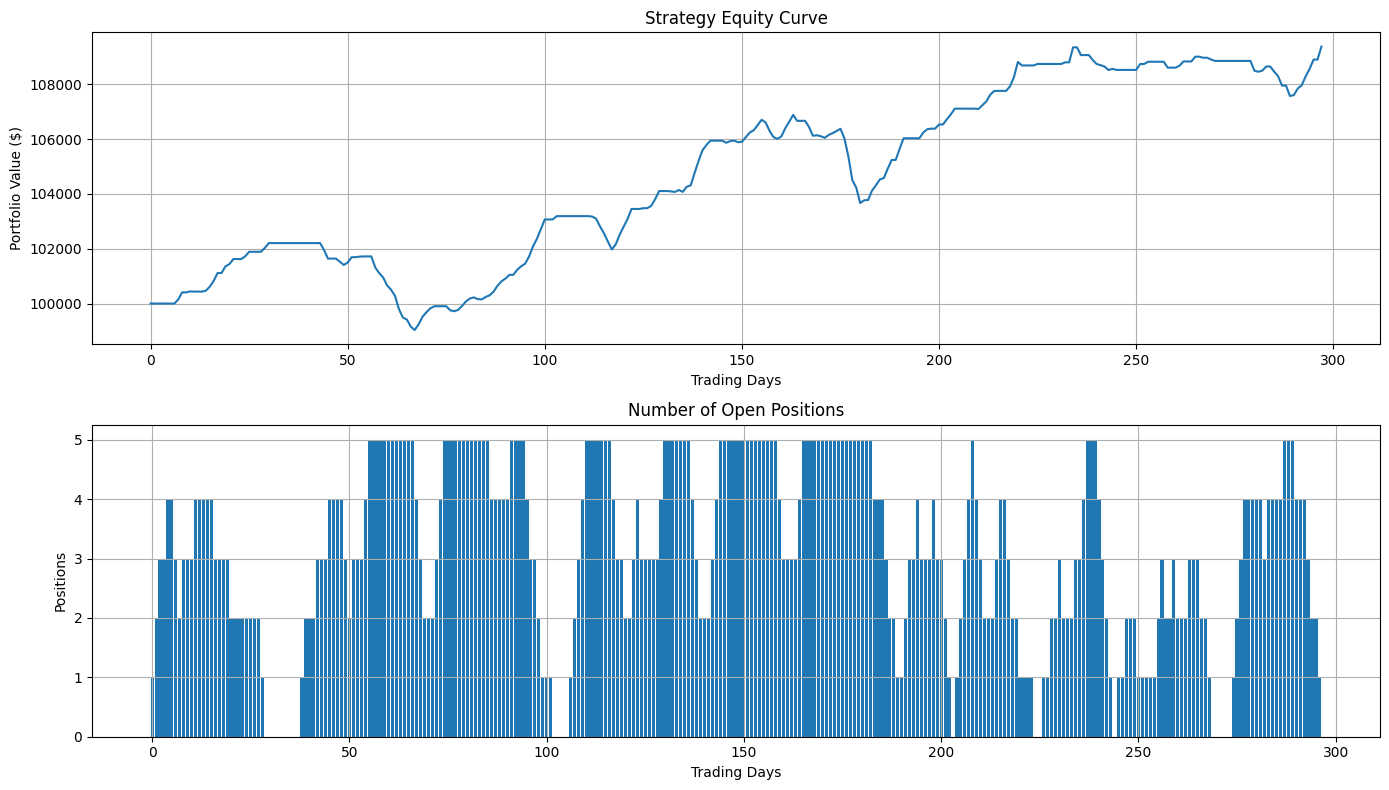


Strategy Performance Summary:
Total Return: 9.39%
Annualized Return: 7.88%
Annualized Volatility: 2.71%
Sharpe Ratio: 2.91
Maximum Drawdown: 3.11%
Win Rate: 64.86%
Number of Trades: 185


In [ ]:
backtest_results = options_trading_strategy(model, data, lookback=20, test_size=0.2)


In [ ]:
def create_lstm_ensemble(input_shape, num_models=5, base_neurons=(128, 64)):

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam

    models = []

    for i in range(num_models):
        model = Sequential()

        # First LSTM layer
        lstm1_units = int(base_neurons[0] * (0.8 + 0.4 * np.random.random()))
        dropout1 = 0.2 + 0.2 * np.random.random()

        model.add(LSTM(
            lstm1_units,
            return_sequences=True,
            input_shape=input_shape
        ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout1))

        # Second LSTM layer
        lstm2_units = int(base_neurons[1] * (0.8 + 0.4 * np.random.random()))
        dropout2 = 0.2 + 0.2 * np.random.random()

        if i % 2 == 0:  # Every other model gets bidirectional
            from tensorflow.keras.layers import Bidirectional
            model.add(Bidirectional(LSTM(lstm2_units)))
        else:
            model.add(LSTM(lstm2_units))

        model.add(BatchNormalization())
        model.add(Dropout(dropout2))

        # Output layer
        model.add(Dense(input_shape[1]))

        # Compile with slightly different learning rates
        lr = 0.001 * (0.5 + np.random.random())
        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='mse'
        )

        models.append(model)
        print(f"Model {i+1} created: LSTM units={lstm1_units},{lstm2_units}, dropout={dropout1:.2f},{dropout2:.2f}, lr={lr:.6f}")

    return models

def train_ensemble(models, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):

    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

    trained_models = []
    histories = []

    for i, model in enumerate(models):
        print(f"\nTraining model {i+1}/{len(models)}...")


        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=0.0001
            )
        ]


        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        trained_models.append(model)
        histories.append(history)

        # Print final performance
        val_loss = min(history.history['val_loss'])
        print(f"Model {i+1} best validation loss: {val_loss:.6f}")

    return trained_models, histories

def predict_with_ensemble(models, X_test, aggregation='mean'):

    individual_preds = []

    # Get predictions from each model
    for i, model in enumerate(models):
        print(f"Getting predictions from model {i+1}/{len(models)}...")
        pred = model.predict(X_test)
        individual_preds.append(pred)

    # Stack predictions
    stacked_preds = np.stack(individual_preds)

    # Aggregate predictions
    if aggregation == 'mean':
        ensemble_pred = np.mean(stacked_preds, axis=0)
    elif aggregation == 'median':
        ensemble_pred = np.median(stacked_preds, axis=0)
    elif aggregation == 'weighted':

        weights = np.array([1/model.evaluate(X_val, y_val, verbose=0) for model in models])
        weights = weights / np.sum(weights)  # Normalize


        weighted_preds = np.zeros_like(stacked_preds[0])
        for i, pred in enumerate(individual_preds):
            weighted_preds += pred * weights[i]

        ensemble_pred = weighted_preds
    else:
        raise ValueError("Aggregation method must be 'mean', 'median', or 'weighted'")

    return ensemble_pred, individual_preds

def visualize_ensemble_performance(y_test, individual_preds, ensemble_pred):

    # Calculate errors
    individual_mses = [np.mean((y_test - pred)**2) for pred in individual_preds]
    ensemble_mse = np.mean((y_test - ensemble_pred)**2)

    # Plot MSE comparison
    plt.figure(figsize=(12, 6))

    # Individual model MSEs
    plt.bar(range(len(individual_mses)), individual_mses, alpha=0.7, label='Individual Models')

    # Ensemble MSE
    plt.axhline(y=ensemble_mse, color='r', linestyle='-', label=f'Ensemble (MSE={ensemble_mse:.6f})')

    plt.title('MSE Comparison: Individual Models vs Ensemble')
    plt.xlabel('Model Index')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True, axis='y')
    plt.show()

    # Print performance comparison
    print("\nPerformance Comparison:")
    print(f"Ensemble MSE: {ensemble_mse:.6f}")
    print(f"Best Individual Model MSE: {min(individual_mses):.6f}")
    print(f"Worst Individual Model MSE: {max(individual_mses):.6f}")
    print(f"Average Individual Model MSE: {np.mean(individual_mses):.6f}")
    print(f"Improvement over average model: {(np.mean(individual_mses) - ensemble_mse) / np.mean(individual_mses) * 100:.2f}%")

In [ ]:
def options_trading_strategy_with_ensemble(data, lookback=20, test_size=0.2, num_ensemble_models=5):

    print("Implementing Options Trading Strategy with LSTM Ensemble")
    print("------------------------------------------------------")

    # Prepare volatility surfaces
    print("Creating volatility surfaces...")

    # Extract unique dates, moneyness levels, and expiry buckets
    unique_dates = sorted(data['date'].unique())
    moneyness_levels = sorted(data['moneyness_bucket'].unique())
    expiry_buckets = sorted(data['expiry_bucket'].unique())

    calls = data[data['cp_flag'] == 'C'].copy()

    underlying_prices = {}
    for date, group in data.groupby('date'):
        underlying_prices[date] = group['underlying_price'].iloc[0]

    vol_surfaces = {}
    for date in unique_dates:
        day_data = calls[calls['date'] == date]

        surface = np.zeros((len(moneyness_levels), len(expiry_buckets)))
        surface.fill(np.nan)

        for i, m in enumerate(moneyness_levels):
            for j, e in enumerate(expiry_buckets):
                subset = day_data[(day_data['moneyness_bucket'] == m) &
                                 (day_data['expiry_bucket'] == e)]
                if not subset.empty:
                    surface[i, j] = subset['impl_volatility'].mean()

        # Interpolate missing values
        from scipy import interpolate

        for j in range(surface.shape[1]):
            col = surface[:, j]
            mask = ~np.isnan(col)
            if np.sum(mask) > 1:
                indices = np.arange(surface.shape[0])
                interp_func = interpolate.interp1d(
                    indices[mask], col[mask],
                    bounds_error=False, fill_value="extrapolate"
                )
                surface[:, j] = interp_func(indices)

        for i in range(surface.shape[0]):
            row = surface[i, :]
            mask = ~np.isnan(row)
            if np.sum(mask) > 1:
                indices = np.arange(surface.shape[1])
                interp_func = interpolate.interp1d(
                    indices[mask], row[mask],
                    bounds_error=False, fill_value="extrapolate"
                )
                surface[i, :] = interp_func(indices)

        mean_val = np.nanmean(surface)
        surface[np.isnan(surface)] = mean_val

        vol_surfaces[date] = surface

    print("Creating LSTM input sequences...")
    X, y = [], []
    dates = sorted(list(vol_surfaces.keys()))

    for i in range(lookback, len(dates)):
        # Input sequence
        seq = []
        for j in range(i - lookback, i):
            seq.append(vol_surfaces[dates[j]])

        target = vol_surfaces[dates[i]]

        X.append(np.array(seq))
        y.append(target)

    X = np.array(X)
    y = np.array(y)

    train_size = int(len(X) * (1 - test_size))
    val_size = int(len(X) * 0.15)

    X_train = X[:train_size-val_size]
    y_train = y[:train_size-val_size]
    X_val = X[train_size-val_size:train_size]
    y_val = y[train_size-val_size:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]

    # Get corresponding dates
    sequence_dates = dates[lookback:]
    train_dates = sequence_dates[:train_size-val_size]
    val_dates = sequence_dates[train_size-val_size:train_size]
    test_dates = sequence_dates[train_size:]

    print(f"Training period: {train_dates[0]} to {train_dates[-1]}")
    print(f"Validation period: {val_dates[0]} to {val_dates[-1]}")
    print(f"Testing period: {test_dates[0]} to {test_dates[-1]}")
    print(f"Number of test dates: {len(test_dates)}")

    #  Reshape for LSTM input
    n_samples, time_steps, n_moneyness, n_expiry = X_train.shape

    X_train_reshaped = X_train.reshape(X_train.shape[0], time_steps, n_moneyness * n_expiry)
    X_val_reshaped = X_val.reshape(X_val.shape[0], time_steps, n_moneyness * n_expiry)
    X_test_reshaped = X_test.reshape(X_test.shape[0], time_steps, n_moneyness * n_expiry)

    y_train_reshaped = y_train.reshape(y_train.shape[0], n_moneyness * n_expiry)
    y_val_reshaped = y_val.reshape(y_val.shape[0], n_moneyness * n_expiry)
    y_test_reshaped = y_test.reshape(y_test.shape[0], n_moneyness * n_expiry)

    #Create and train ensemble models
    print("Creating and training LSTM ensemble...")
    input_shape = (time_steps, n_moneyness * n_expiry)
    ensemble_models = create_lstm_ensemble(input_shape, num_models=num_ensemble_models)

    trained_models, histories = train_ensemble(
        ensemble_models,
        X_train_reshaped, y_train_reshaped,
        X_val_reshaped, y_val_reshaped,
        epochs=20,
        batch_size=32
    )

    # Generate ensemble predictions
    print("Generating volatility surface predictions with ensemble...")
    ensemble_pred, individual_preds = predict_with_ensemble(
        trained_models,
        X_test_reshaped,
        aggregation='mean'
    )

    #  Reshape predictions back to surface format
    ensemble_pred_surfaces = ensemble_pred.reshape(ensemble_pred.shape[0], n_moneyness, n_expiry)

    #Visualize ensemble vs individual model performance
    visualize_ensemble_performance(y_test_reshaped, individual_preds, ensemble_pred)

    # Generate trading signals
    print("Generating trading signals...")
    # Ensure test_dates is a list, not an array
    test_dates_list = [test_dates[i] for i in range(len(test_dates))]

    signals = generate_trading_signals(y_test, ensemble_pred_surfaces, test_dates_list,
                                      moneyness_levels, expiry_buckets)

    # Determine trades
    print("Determining option trades...")
    trades = determine_trades(signals)

    print("Applying risk management...")
    risk_managed_trades = apply_risk_management(trades)

    print("Running backtest...")
    backtest_results = backtest_strategy(
        risk_managed_trades,
        y_test,
        test_dates_list,
        moneyness_levels,
        expiry_buckets,
        underlying_prices
    )

    print("Visualizing results...")

    plt.figure(figsize=(14, 8))

    # Plot equity curve
    plt.subplot(2, 1, 1)
    plt.plot(backtest_results['equity_curve'])
    plt.title('Strategy Equity Curve (LSTM Ensemble)')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)

    # Plot number of positions
    plt.subplot(2, 1, 2)
    plt.bar(range(len(backtest_results['positions'])), backtest_results['positions'])
    plt.title('Number of Open Positions')
    plt.xlabel('Trading Days')
    plt.ylabel('Positions')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    #Print performance summary
    print("\nStrategy Performance Summary (LSTM Ensemble):")
    print(f"Total Return: {backtest_results['total_return']:.2f}%")
    print(f"Annualized Return: {backtest_results['annualized_return']:.2f}%")
    print(f"Annualized Volatility: {backtest_results['annualized_volatility']:.2f}%")
    print(f"Sharpe Ratio: {backtest_results['sharpe_ratio']:.2f}")
    print(f"Maximum Drawdown: {backtest_results['max_drawdown']:.2f}%")
    print(f"Win Rate: {backtest_results['win_rate']*100:.2f}%")
    print(f"Number of Trades: {backtest_results['num_trades']}")

    # Store additional information in the results
    backtest_results['ensemble_models'] = trained_models
    backtest_results['X_test'] = X_test
    backtest_results['y_test'] = y_test
    backtest_results['ensemble_pred'] = ensemble_pred
    backtest_results['ensemble_pred_surfaces'] = ensemble_pred_surfaces
    backtest_results['signals'] = signals
    backtest_results['test_dates'] = test_dates_list
    backtest_results['moneyness_levels'] = moneyness_levels
    backtest_results['expiry_buckets'] = expiry_buckets

    return backtest_results

Implementing Options Trading Strategy with LSTM Ensemble
------------------------------------------------------
Creating volatility surfaces...
Creating LSTM input sequences...
Training period: 2017-09-29 00:00:00 to 2021-08-05 00:00:00
Validation period: 2021-08-06 00:00:00 to 2022-06-24 00:00:00
Testing period: 2022-06-27 00:00:00 to 2023-08-31 00:00:00
Number of test dates: 298
Creating and training LSTM ensemble...
Model 1 created: LSTM units=133,72, dropout=0.29,0.25, lr=0.000796


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model 2 created: LSTM units=141,57, dropout=0.36,0.25, lr=0.001044
Model 3 created: LSTM units=119,55, dropout=0.39,0.33, lr=0.001254
Model 4 created: LSTM units=151,54, dropout=0.27,0.27, lr=0.000539
Model 5 created: LSTM units=137,52, dropout=0.40,0.33, lr=0.001034

Training model 1/5...
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 1.1845 - val_loss: 0.0768 - learning_rate: 7.9573e-04
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.4914 - val_loss: 0.0631 - learning_rate: 7.9573e-04
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.3745 - val_loss: 0.0509 - learning_rate: 7.9573e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.3197 - val_loss: 0.0438 - learning_rate: 7.9573e-04
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.2637 - val_loss: 0.0360 - learning_rate: 7.9573e-04
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.2347 - val_loss: 0.0316 - learning_rate: 7.9573e-04
Epoch 7/20
31/31 ━━━━━━━━━━━

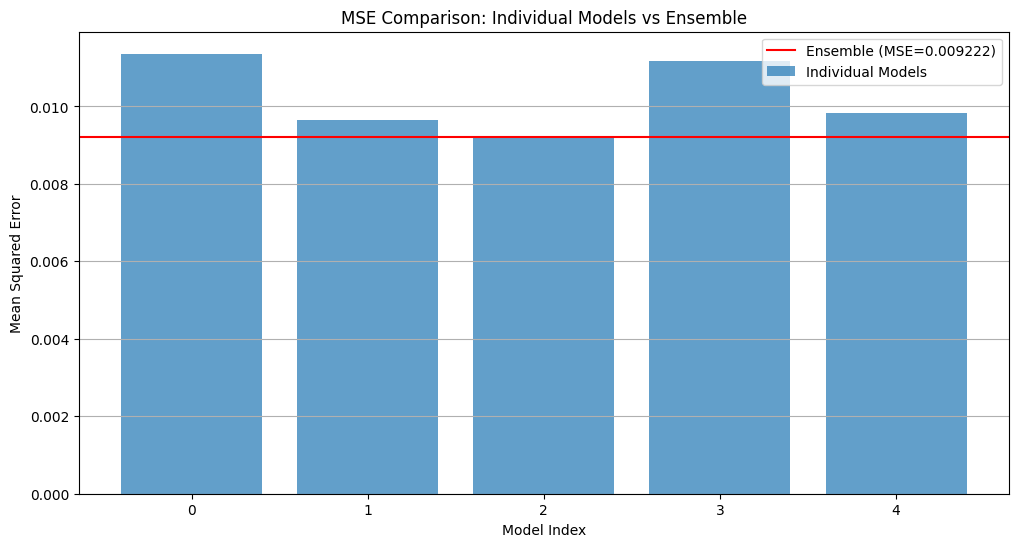


Performance Comparison:
Ensemble MSE: 0.009222
Best Individual Model MSE: 0.009245
Worst Individual Model MSE: 0.011361
Average Individual Model MSE: 0.010251
Improvement over average model: 10.04%
Generating trading signals...
Determining option trades...
Applying risk management...
Running backtest...
Visualizing results...


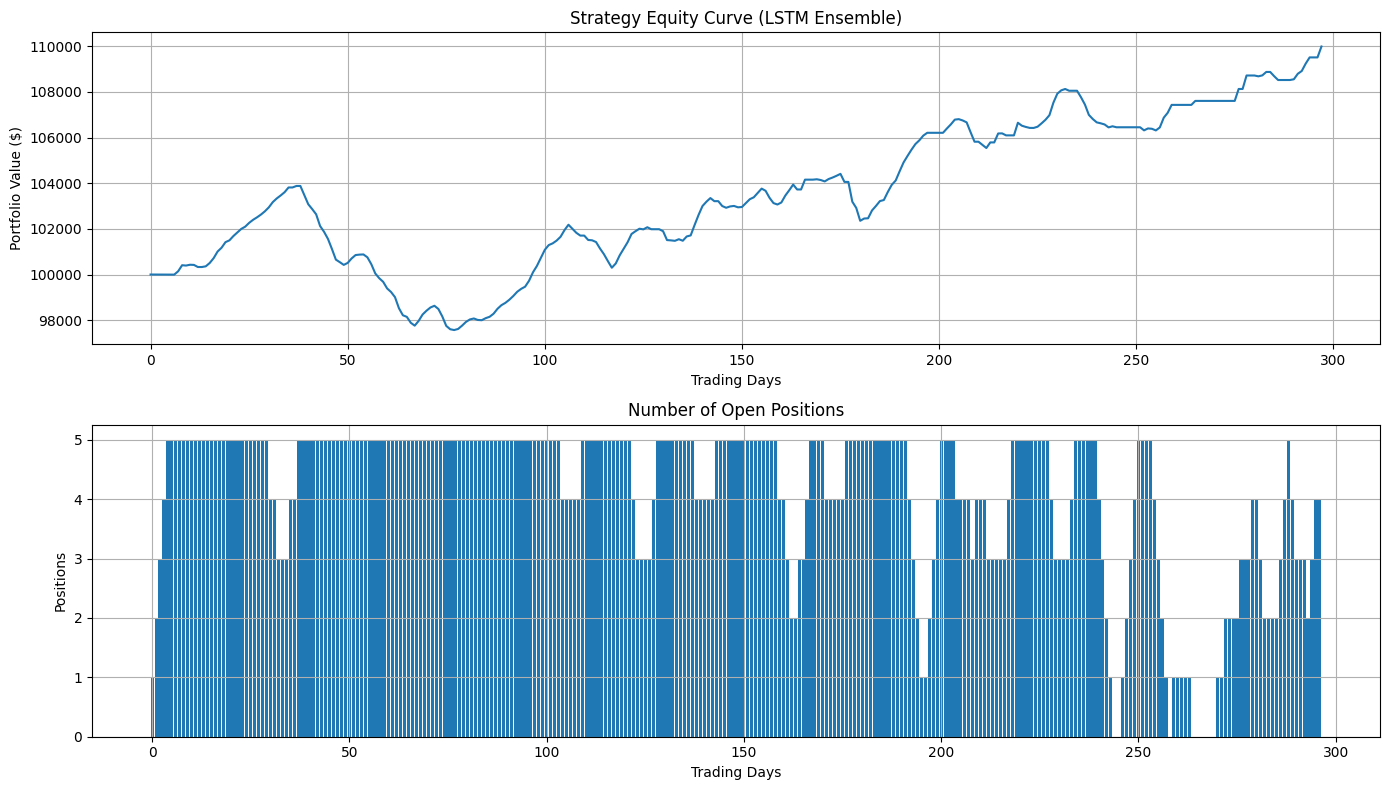


Strategy Performance Summary (LSTM Ensemble):
Total Return: 9.99%
Annualized Return: 8.38%
Annualized Volatility: 3.20%
Sharpe Ratio: 2.62
Maximum Drawdown: 6.07%
Win Rate: 60.74%
Number of Trades: 242


In [ ]:

ensemble_results_1 = options_trading_strategy_with_ensemble(
    data,
    lookback=20,
    test_size=0.2,
    num_ensemble_models=5
)

Implementing Options Trading Strategy with LSTM Ensemble
------------------------------------------------------
Creating volatility surfaces...
Creating LSTM input sequences...
Training period: 2017-09-29 00:00:00 to 2021-08-05 00:00:00
Validation period: 2021-08-06 00:00:00 to 2022-06-24 00:00:00
Testing period: 2022-06-27 00:00:00 to 2023-08-31 00:00:00
Number of test dates: 298
Creating and training LSTM ensemble...
Model 1 created: LSTM units=140,59, dropout=0.39,0.21, lr=0.000586


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model 2 created: LSTM units=117,61, dropout=0.33,0.38, lr=0.000650
Model 3 created: LSTM units=126,54, dropout=0.29,0.37, lr=0.001236
Model 4 created: LSTM units=148,69, dropout=0.30,0.34, lr=0.000818

Training model 1/4...
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 1.1313 - val_loss: 0.0880 - learning_rate: 5.8596e-04
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.4827 - val_loss: 0.0729 - learning_rate: 5.8596e-04
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.3723 - val_loss: 0.0664 - learning_rate: 5.8596e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.3044 - val_loss: 0.0585 - learning_rate: 5.8596e-04
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.2680 - val_loss: 0.0484 - learning_rate: 5.8596e-04
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.2321 - val_loss: 0.0469 - learning_rate: 5.8596e-04
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.2115 - val_loss: 0.0362 - learning_r

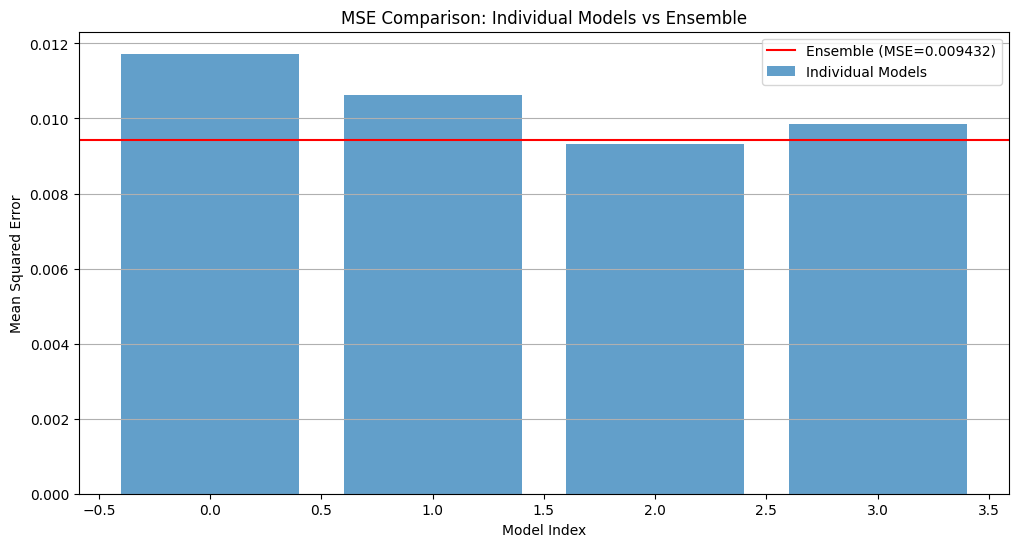


Performance Comparison:
Ensemble MSE: 0.009432
Best Individual Model MSE: 0.009307
Worst Individual Model MSE: 0.011725
Average Individual Model MSE: 0.010380
Improvement over average model: 9.13%
Generating trading signals...
Determining option trades...
Applying risk management...
Running backtest...
Visualizing results...


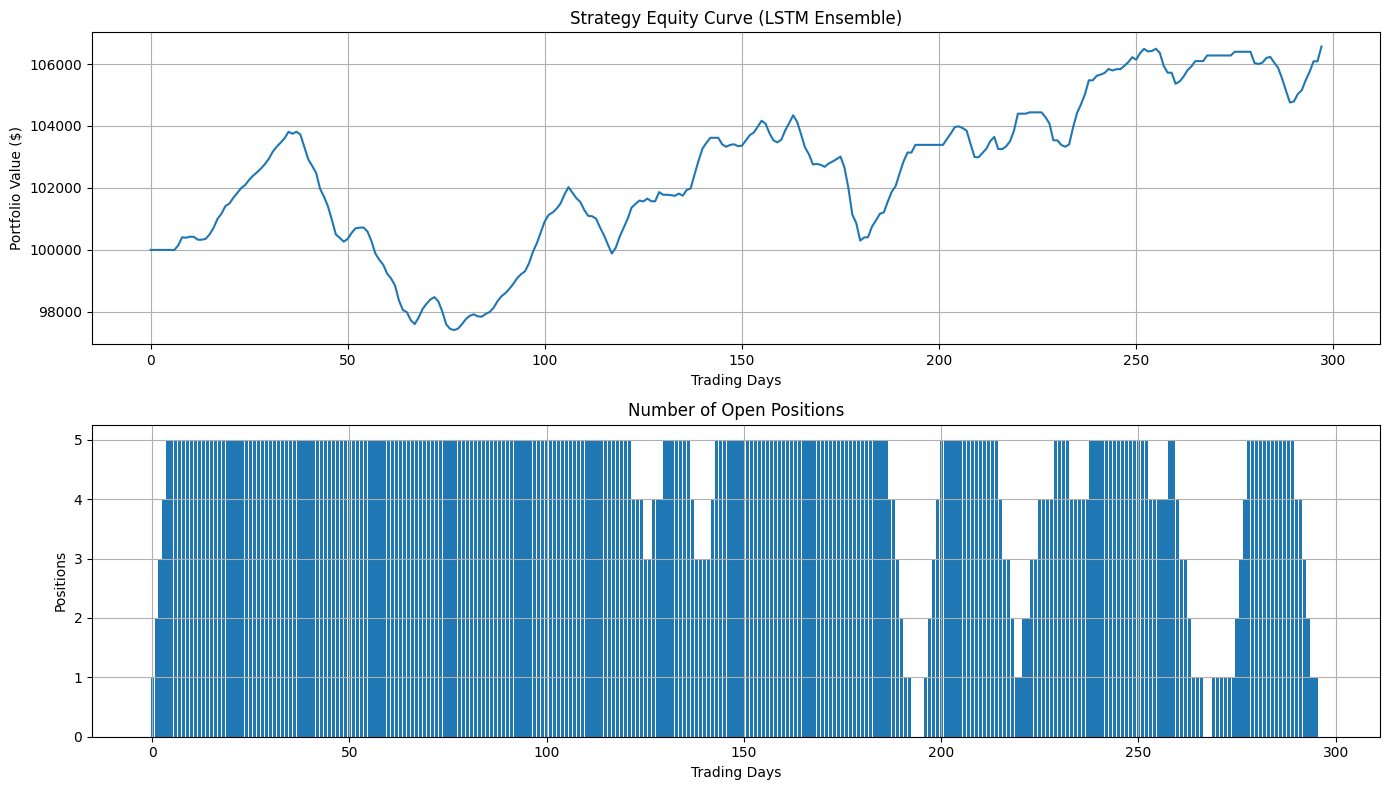


Strategy Performance Summary (LSTM Ensemble):
Total Return: 6.56%
Annualized Return: 5.52%
Annualized Volatility: 3.41%
Sharpe Ratio: 1.62
Maximum Drawdown: 6.17%
Win Rate: 61.00%
Number of Trades: 259


In [ ]:
ensemble_results_2 = options_trading_strategy_with_ensemble(
    data,
    lookback=20,
    test_size=0.2,
    num_ensemble_models=4
)

Implementing Options Trading Strategy with LSTM Ensemble
------------------------------------------------------
Creating volatility surfaces...
Creating LSTM input sequences...
Training period: 2017-09-29 00:00:00 to 2021-08-05 00:00:00
Validation period: 2021-08-06 00:00:00 to 2022-06-24 00:00:00
Testing period: 2022-06-27 00:00:00 to 2023-08-31 00:00:00
Number of test dates: 298
Creating and training LSTM ensemble...
Model 1 created: LSTM units=111,56, dropout=0.29,0.27, lr=0.001043
Model 2 created: LSTM units=128,62, dropout=0.31,0.34, lr=0.000736
Model 3 created: LSTM units=112,57, dropout=0.23,0.32, lr=0.001221

Training model 1/3...
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 1.1015 - val_loss: 0.0949 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.4154 - val_loss: 0.0632 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.2982 - val_loss: 0.0482 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━

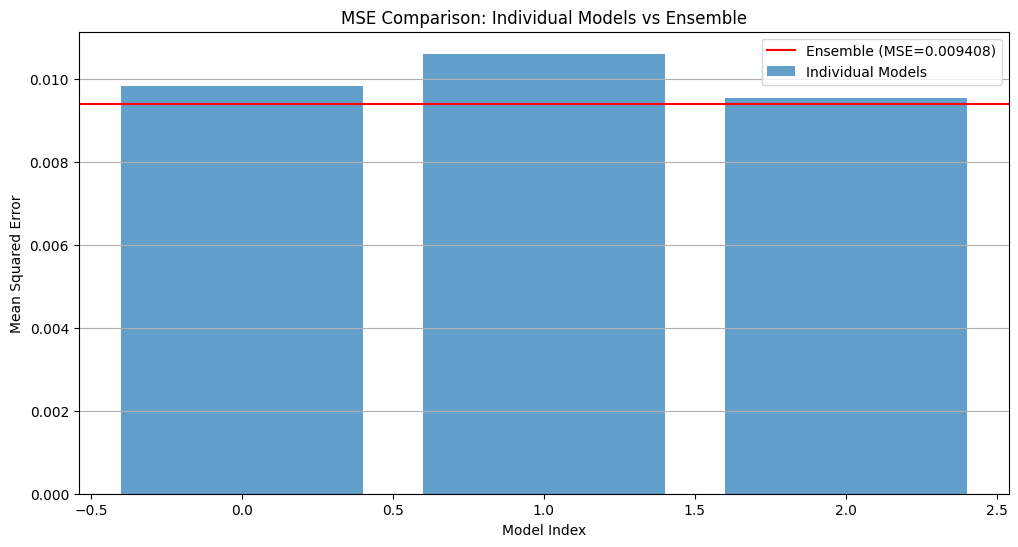


Performance Comparison:
Ensemble MSE: 0.009408
Best Individual Model MSE: 0.009553
Worst Individual Model MSE: 0.010610
Average Individual Model MSE: 0.010001
Improvement over average model: 5.93%
Generating trading signals...
Determining option trades...
Applying risk management...
Running backtest...
Visualizing results...


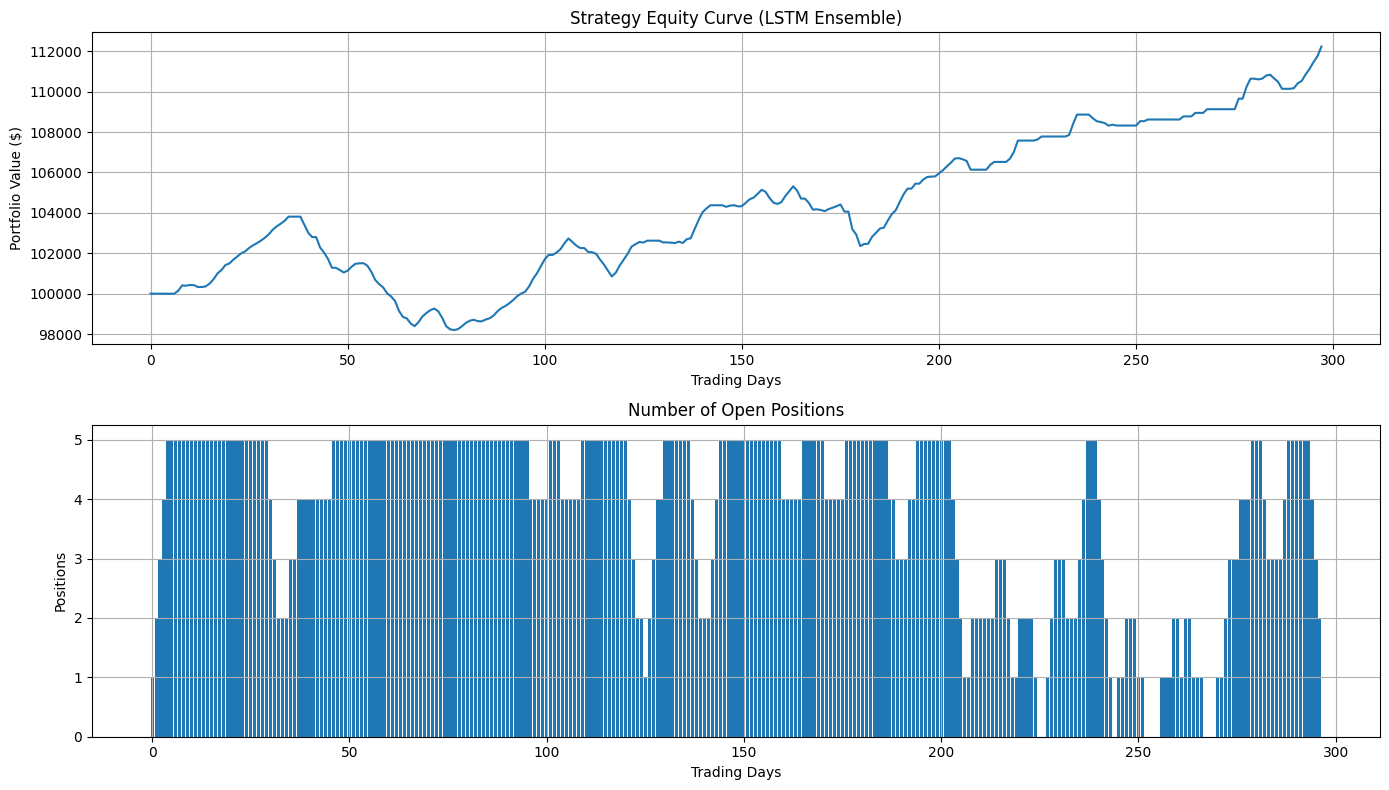


Strategy Performance Summary (LSTM Ensemble):
Total Return: 12.24%
Annualized Return: 10.25%
Annualized Volatility: 3.05%
Sharpe Ratio: 3.36
Maximum Drawdown: 5.41%
Win Rate: 65.33%
Number of Trades: 225


In [ ]:
ensemble_results_3 = options_trading_strategy_with_ensemble(
    data,
    lookback=20,
    test_size=0.2,
    num_ensemble_models=3
)

In [ ]:
print(ensemble_results_3.keys())

dict_keys(['equity_curve', 'daily_returns', 'trades', 'positions', 'total_return', 'annualized_return', 'annualized_volatility', 'sharpe_ratio', 'max_drawdown', 'win_rate', 'num_trades', 'ensemble_models', 'X_test', 'y_test', 'ensemble_pred', 'ensemble_pred_surfaces', 'signals', 'test_dates', 'moneyness_levels', 'expiry_buckets'])


Implementing Options Trading Strategy with LSTM Ensemble
------------------------------------------------------
Creating volatility surfaces...
Creating LSTM input sequences...
Training period: 2017-09-29 00:00:00 to 2021-08-05 00:00:00
Validation period: 2021-08-06 00:00:00 to 2022-06-24 00:00:00
Testing period: 2022-06-27 00:00:00 to 2023-08-31 00:00:00
Number of test dates: 298
Creating and training LSTM ensemble...
Model 1 created: LSTM units=125,58, dropout=0.25,0.32, lr=0.000615
Model 2 created: LSTM units=139,55, dropout=0.36,0.28, lr=0.001457

Training model 1/2...
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 1.3251 - val_loss: 0.0799 - learning_rate: 6.1500e-04
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.6341 - val_loss: 0.0682 - learning_rate: 6.1500e-04
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.4677 - val_loss: 0.0589 - learning_rate: 6.1500e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.3862 - val_loss: 0.

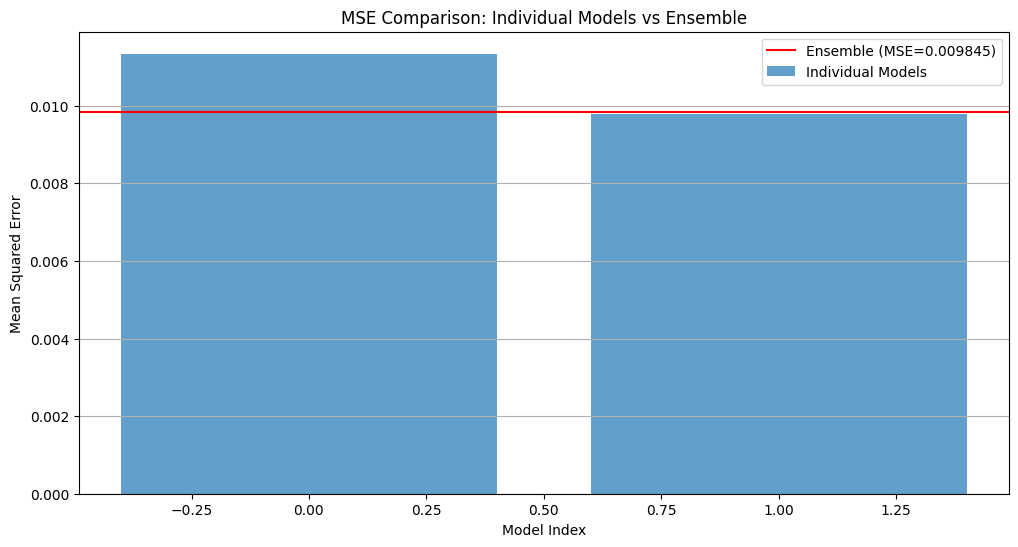


Performance Comparison:
Ensemble MSE: 0.009845
Best Individual Model MSE: 0.009798
Worst Individual Model MSE: 0.011340
Average Individual Model MSE: 0.010569
Improvement over average model: 6.85%
Generating trading signals...
Determining option trades...
Applying risk management...
Running backtest...
Visualizing results...


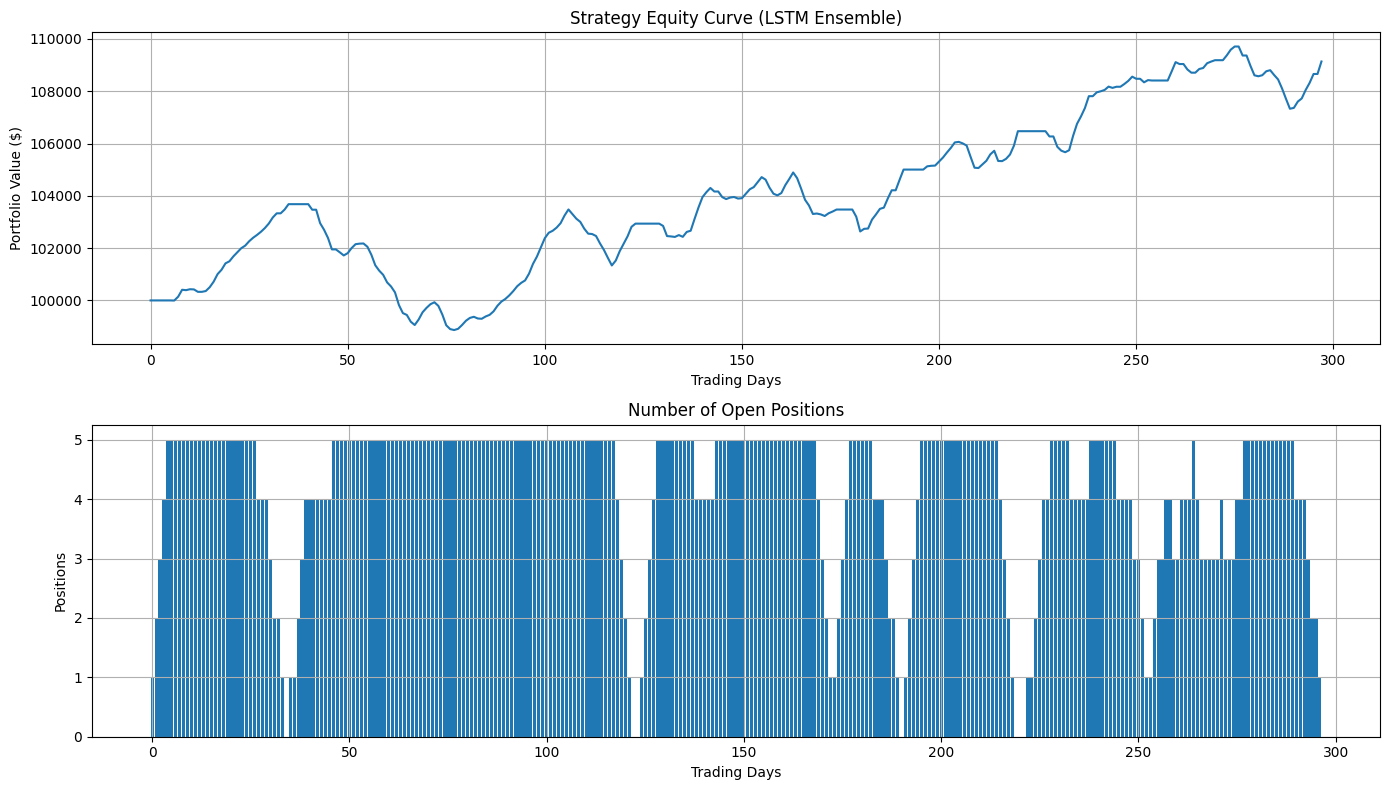


Strategy Performance Summary (LSTM Ensemble):
Total Return: 9.14%
Annualized Return: 7.67%
Annualized Volatility: 3.10%
Sharpe Ratio: 2.48
Maximum Drawdown: 4.64%
Win Rate: 62.20%
Number of Trades: 246


In [ ]:
ensemble_results_4 = options_trading_strategy_with_ensemble(
    data,
    lookback=20,
    test_size=0.2,
    num_ensemble_models=2
)

In [ ]:
single_model = model

In [ ]:
ensemble_models = [ensemble_results_1, ensemble_results_2, ensemble_results_3, ensemble_results_4]


In [ ]:
def comparative_analysis(single_model, ensemble_models, X_test, y_test,
                         test_dates, moneyness_levels, expiry_buckets, underlying_prices):

    if len(X_test.shape) == 4:
        n_samples, time_steps, n_moneyness, n_expiry = X_test.shape
        X_test_reshaped = X_test.reshape(n_samples, time_steps, n_moneyness * n_expiry)
    else:
        X_test_reshaped = X_test
        n_samples, time_steps, features = X_test_reshaped.shape
        n_moneyness = len(moneyness_levels)
        n_expiry = len(expiry_buckets)


    print("Generating predictions from both models...")

    # Single model predictions
    single_pred = single_model.predict(X_test_reshaped)
    single_pred_surfaces = single_pred.reshape(n_samples, n_moneyness, n_expiry)

    # Ensemble predictions
    ensemble_pred, individual_preds = predict_with_ensemble(ensemble_models, X_test_reshaped)
    ensemble_pred_surfaces = ensemble_pred.reshape(n_samples, n_moneyness, n_expiry)


    print("Calculating prediction accuracy metrics...")


    if len(y_test.shape) == 3:
        y_test_flat = y_test.reshape(n_samples, n_moneyness * n_expiry)
    else:
        y_test_flat = y_test

    # Overall metrics
    single_mse = np.mean((y_test_flat - single_pred) ** 2)
    single_rmse = np.sqrt(single_mse)
    single_mae = np.mean(np.abs(y_test_flat - single_pred))

    ensemble_mse = np.mean((y_test_flat - ensemble_pred) ** 2)
    ensemble_rmse = np.sqrt(ensemble_mse)
    ensemble_mae = np.mean(np.abs(y_test_flat - ensemble_pred))

    metrics_by_moneyness = []
    metrics_by_expiry = []

    # Reshape back to 3D for region-specific analysis
    y_test_surfaces = y_test.reshape(n_samples, n_moneyness, n_expiry)

    # Metrics by moneyness
    for i, m in enumerate(moneyness_levels):
        single_rmse_m = np.sqrt(np.mean((y_test_surfaces[:, i, :] - single_pred_surfaces[:, i, :]) ** 2))
        ensemble_rmse_m = np.sqrt(np.mean((y_test_surfaces[:, i, :] - ensemble_pred_surfaces[:, i, :]) ** 2))
        improvement = (single_rmse_m - ensemble_rmse_m) / single_rmse_m * 100

        metrics_by_moneyness.append({
            'moneyness': m,
            'single_rmse': single_rmse_m,
            'ensemble_rmse': ensemble_rmse_m,
            'improvement_pct': improvement
        })

    # Metrics by expiry
    for i, e in enumerate(expiry_buckets):
        single_rmse_e = np.sqrt(np.mean((y_test_surfaces[:, :, i] - single_pred_surfaces[:, :, i]) ** 2))
        ensemble_rmse_e = np.sqrt(np.mean((y_test_surfaces[:, :, i] - ensemble_pred_surfaces[:, :, i]) ** 2))
        improvement = (single_rmse_e - ensemble_rmse_e) / single_rmse_e * 100

        metrics_by_expiry.append({
            'expiry': e,
            'single_rmse': single_rmse_e,
            'ensemble_rmse': ensemble_rmse_e,
            'improvement_pct': improvement
        })

    print("Calculating directional accuracy...")

    # Find ATM index and short-term expiry index
    atm_idx = np.abs(np.array(moneyness_levels) - 1.0).argmin()
    short_exp_idx = np.abs(np.array(expiry_buckets) - 30).argmin()

    # Calculate day-to-day changes
    atm_changes_actual = []
    atm_changes_single = []
    atm_changes_ensemble = []

    for i in range(1, n_samples):
        actual_change = y_test_surfaces[i, atm_idx, short_exp_idx] - y_test_surfaces[i-1, atm_idx, short_exp_idx]
        single_change = single_pred_surfaces[i, atm_idx, short_exp_idx] - y_test_surfaces[i-1, atm_idx, short_exp_idx]
        ensemble_change = ensemble_pred_surfaces[i, atm_idx, short_exp_idx] - y_test_surfaces[i-1, atm_idx, short_exp_idx]

        atm_changes_actual.append(actual_change)
        atm_changes_single.append(single_change)
        atm_changes_ensemble.append(ensemble_change)

    # Directional accuracy
    single_direction_correct = sum(1 for a, p in zip(atm_changes_actual, atm_changes_single)
                                 if (a > 0 and p > 0) or (a < 0 and p < 0))
    single_directional_accuracy = single_direction_correct / len(atm_changes_actual)

    ensemble_direction_correct = sum(1 for a, p in zip(atm_changes_actual, atm_changes_ensemble)
                                   if (a > 0 and p > 0) or (a < 0 and p < 0))
    ensemble_directional_accuracy = ensemble_direction_correct / len(atm_changes_actual)

    print("Running trading strategy with both models...")

    # Generate signals
    single_signals = generate_trading_signals(y_test_surfaces, single_pred_surfaces,
                                            test_dates, moneyness_levels, expiry_buckets)
    ensemble_signals = generate_trading_signals(y_test_surfaces, ensemble_pred_surfaces,
                                              test_dates, moneyness_levels, expiry_buckets)

    # Determine trades
    single_trades = determine_trades(single_signals)
    ensemble_trades = determine_trades(ensemble_signals)

    # Apply risk management
    single_risk_trades = apply_risk_management(single_trades)
    ensemble_risk_trades = apply_risk_management(ensemble_trades)

    # Backtest
    single_backtest = backtest_strategy(single_risk_trades, y_test_surfaces,
                                      test_dates, moneyness_levels, expiry_buckets,
                                      underlying_prices)
    ensemble_backtest = backtest_strategy(ensemble_risk_trades, y_test_surfaces,
                                        test_dates, moneyness_levels, expiry_buckets,
                                        underlying_prices)

    results = {
        'prediction_accuracy': {
            'single': {
                'mse': single_mse,
                'rmse': single_rmse,
                'mae': single_mae
            },
            'ensemble': {
                'mse': ensemble_mse,
                'rmse': ensemble_rmse,
                'mae': ensemble_mae
            },
            'improvement_pct': {
                'mse': (single_mse - ensemble_mse) / single_mse * 100,
                'rmse': (single_rmse - ensemble_rmse) / single_rmse * 100,
                'mae': (single_mae - ensemble_mae) / single_mae * 100
            }
        },
        'metrics_by_moneyness': metrics_by_moneyness,
        'metrics_by_expiry': metrics_by_expiry,
        'directional_accuracy': {
            'single': single_directional_accuracy,
            'ensemble': ensemble_directional_accuracy
        },
        'trading_performance': {
            'single': {
                'total_return': single_backtest['total_return'],
                'annualized_return': single_backtest['annualized_return'],
                'sharpe_ratio': single_backtest['sharpe_ratio'],
                'max_drawdown': single_backtest['max_drawdown'],
                'win_rate': single_backtest['win_rate'],
                'num_trades': single_backtest['num_trades']
            },
            'ensemble': {
                'total_return': ensemble_backtest['total_return'],
                'annualized_return': ensemble_backtest['annualized_return'],
                'sharpe_ratio': ensemble_backtest['sharpe_ratio'],
                'max_drawdown': ensemble_backtest['max_drawdown'],
                'win_rate': ensemble_backtest['win_rate'],
                'num_trades': ensemble_backtest['num_trades']
            }
        },
        'detailed_results': {
            'single_backtest': single_backtest,
            'ensemble_backtest': ensemble_backtest
        }
    }

    print("Visualizing comparative results...")
    visualize_comparison(results, single_backtest, ensemble_backtest)

    return results

def predict_with_ensemble(models, X_test, aggregation='mean'):

    individual_preds = []

    # Get predictions from each model
    for i, model in enumerate(models):
        print(f"Getting predictions from model {i+1}/{len(models)}...")
        pred = model.predict(X_test)
        individual_preds.append(pred)

    # Stack predictions
    stacked_preds = np.stack(individual_preds)

    # Aggregate predictions
    if aggregation == 'mean':
        ensemble_pred = np.mean(stacked_preds, axis=0)
    elif aggregation == 'median':
        ensemble_pred = np.median(stacked_preds, axis=0)
    else:
        raise ValueError("Aggregation method must be 'mean' or 'median'")

    return ensemble_pred, individual_preds

def visualize_comparison(results, single_backtest, ensemble_backtest):

    plt.figure(figsize=(20, 20))

    plt.subplot(3, 2, 1)
    metrics = ['MSE', 'RMSE', 'MAE']
    single_values = [results['prediction_accuracy']['single']['mse'],
                    results['prediction_accuracy']['single']['rmse'],
                    results['prediction_accuracy']['single']['mae']]
    ensemble_values = [results['prediction_accuracy']['ensemble']['mse'],
                      results['prediction_accuracy']['ensemble']['rmse'],
                      results['prediction_accuracy']['ensemble']['mae']]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, single_values, width, label='Single LSTM')
    plt.bar(x + width/2, ensemble_values, width, label='Ensemble LSTM')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Prediction Accuracy Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(3, 2, 2)
    moneyness_levels = [m['moneyness'] for m in results['metrics_by_moneyness']]
    single_rmse_m = [m['single_rmse'] for m in results['metrics_by_moneyness']]
    ensemble_rmse_m = [m['ensemble_rmse'] for m in results['metrics_by_moneyness']]

    plt.plot(moneyness_levels, single_rmse_m, 'o-', label='Single LSTM')
    plt.plot(moneyness_levels, ensemble_rmse_m, 's-', label='Ensemble LSTM')
    plt.xlabel('Moneyness')
    plt.ylabel('RMSE')
    plt.title('Prediction Error by Moneyness')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 3)
    expiry_levels = [e['expiry'] for e in results['metrics_by_expiry']]
    single_rmse_e = [e['single_rmse'] for e in results['metrics_by_expiry']]
    ensemble_rmse_e = [e['ensemble_rmse'] for e in results['metrics_by_expiry']]

    plt.plot(expiry_levels, single_rmse_e, 'o-', label='Single LSTM')
    plt.plot(expiry_levels, ensemble_rmse_e, 's-', label='Ensemble LSTM')
    plt.xlabel('Days to Expiration')
    plt.ylabel('RMSE')
    plt.title('Prediction Error by Expiry')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 4)
    dir_acc = [results['directional_accuracy']['single'] * 100,
              results['directional_accuracy']['ensemble'] * 100]

    plt.bar(['Single LSTM', 'Ensemble LSTM'], dir_acc)
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.title('Directional Accuracy')
    plt.ylim(0, 100)
    plt.grid(axis='y')

    plt.subplot(3, 2, 5)
    plt.plot(single_backtest['equity_curve'], label='Single LSTM')
    plt.plot(ensemble_backtest['equity_curve'], label='Ensemble LSTM')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.title('Equity Curves')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 6)
    metrics = ['Ann. Return (%)', 'Sharpe Ratio', 'Win Rate (%)']
    single_values = [results['trading_performance']['single']['annualized_return'],
                    results['trading_performance']['single']['sharpe_ratio'],
                    results['trading_performance']['single']['win_rate'] * 100]
    ensemble_values = [results['trading_performance']['ensemble']['annualized_return'],
                      results['trading_performance']['ensemble']['sharpe_ratio'],
                      results['trading_performance']['ensemble']['win_rate'] * 100]

    x = np.arange(len(metrics))

    plt.bar(x - width/2, single_values, width, label='Single LSTM')
    plt.bar(x + width/2, ensemble_values, width, label='Ensemble LSTM')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Trading Performance Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

    # Print comparison summary
    print("\nComparison Summary:")
    print("-" * 50)

    print(f"Prediction Metrics:")
    print(f"  RMSE: Single={results['prediction_accuracy']['single']['rmse']:.6f}, " +
          f"Ensemble={results['prediction_accuracy']['ensemble']['rmse']:.6f}, " +
          f"Improvement={results['prediction_accuracy']['improvement_pct']['rmse']:.2f}%")

    print(f"  MAE: Single={results['prediction_accuracy']['single']['mae']:.6f}, " +
          f"Ensemble={results['prediction_accuracy']['ensemble']['mae']:.6f}, " +
          f"Improvement={results['prediction_accuracy']['improvement_pct']['mae']:.2f}%")

    print(f"\nDirectional Accuracy:")
    print(f"  Single={results['directional_accuracy']['single']*100:.2f}%, " +
          f"Ensemble={results['directional_accuracy']['ensemble']*100:.2f}%")

    print(f"\nTrading Performance:")
    print(f"  Annualized Return: Single={results['trading_performance']['single']['annualized_return']:.2f}%, " +
          f"Ensemble={results['trading_performance']['ensemble']['annualized_return']:.2f}%")

    print(f"  Sharpe Ratio: Single={results['trading_performance']['single']['sharpe_ratio']:.2f}, " +
          f"Ensemble={results['trading_performance']['ensemble']['sharpe_ratio']:.2f}")

    print(f"  Maximum Drawdown: Single={results['trading_performance']['single']['max_drawdown']:.2f}%, " +
          f"Ensemble={results['trading_performance']['ensemble']['max_drawdown']:.2f}%")

    print(f"  Win Rate: Single={results['trading_performance']['single']['win_rate']*100:.2f}%, " +
          f"Ensemble={results['trading_performance']['ensemble']['win_rate']*100:.2f}%")

    print(f"  Number of Trades: Single={results['trading_performance']['single']['num_trades']}, " +
          f"Ensemble={results['trading_performance']['ensemble']['num_trades']}")



==== ANALYZING ENSEMBLE #1 ====

Generating predictions from both models...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Getting predictions from model 1/5...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Getting predictions from model 2/5...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Getting predictions from model 3/5...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Getting predictions from model 4/5...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Getting predictions from model 5/5...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Calculating prediction accuracy metrics...
Calculating directional accuracy...
Running trading strategy with both models...
Visualizing comparative results...


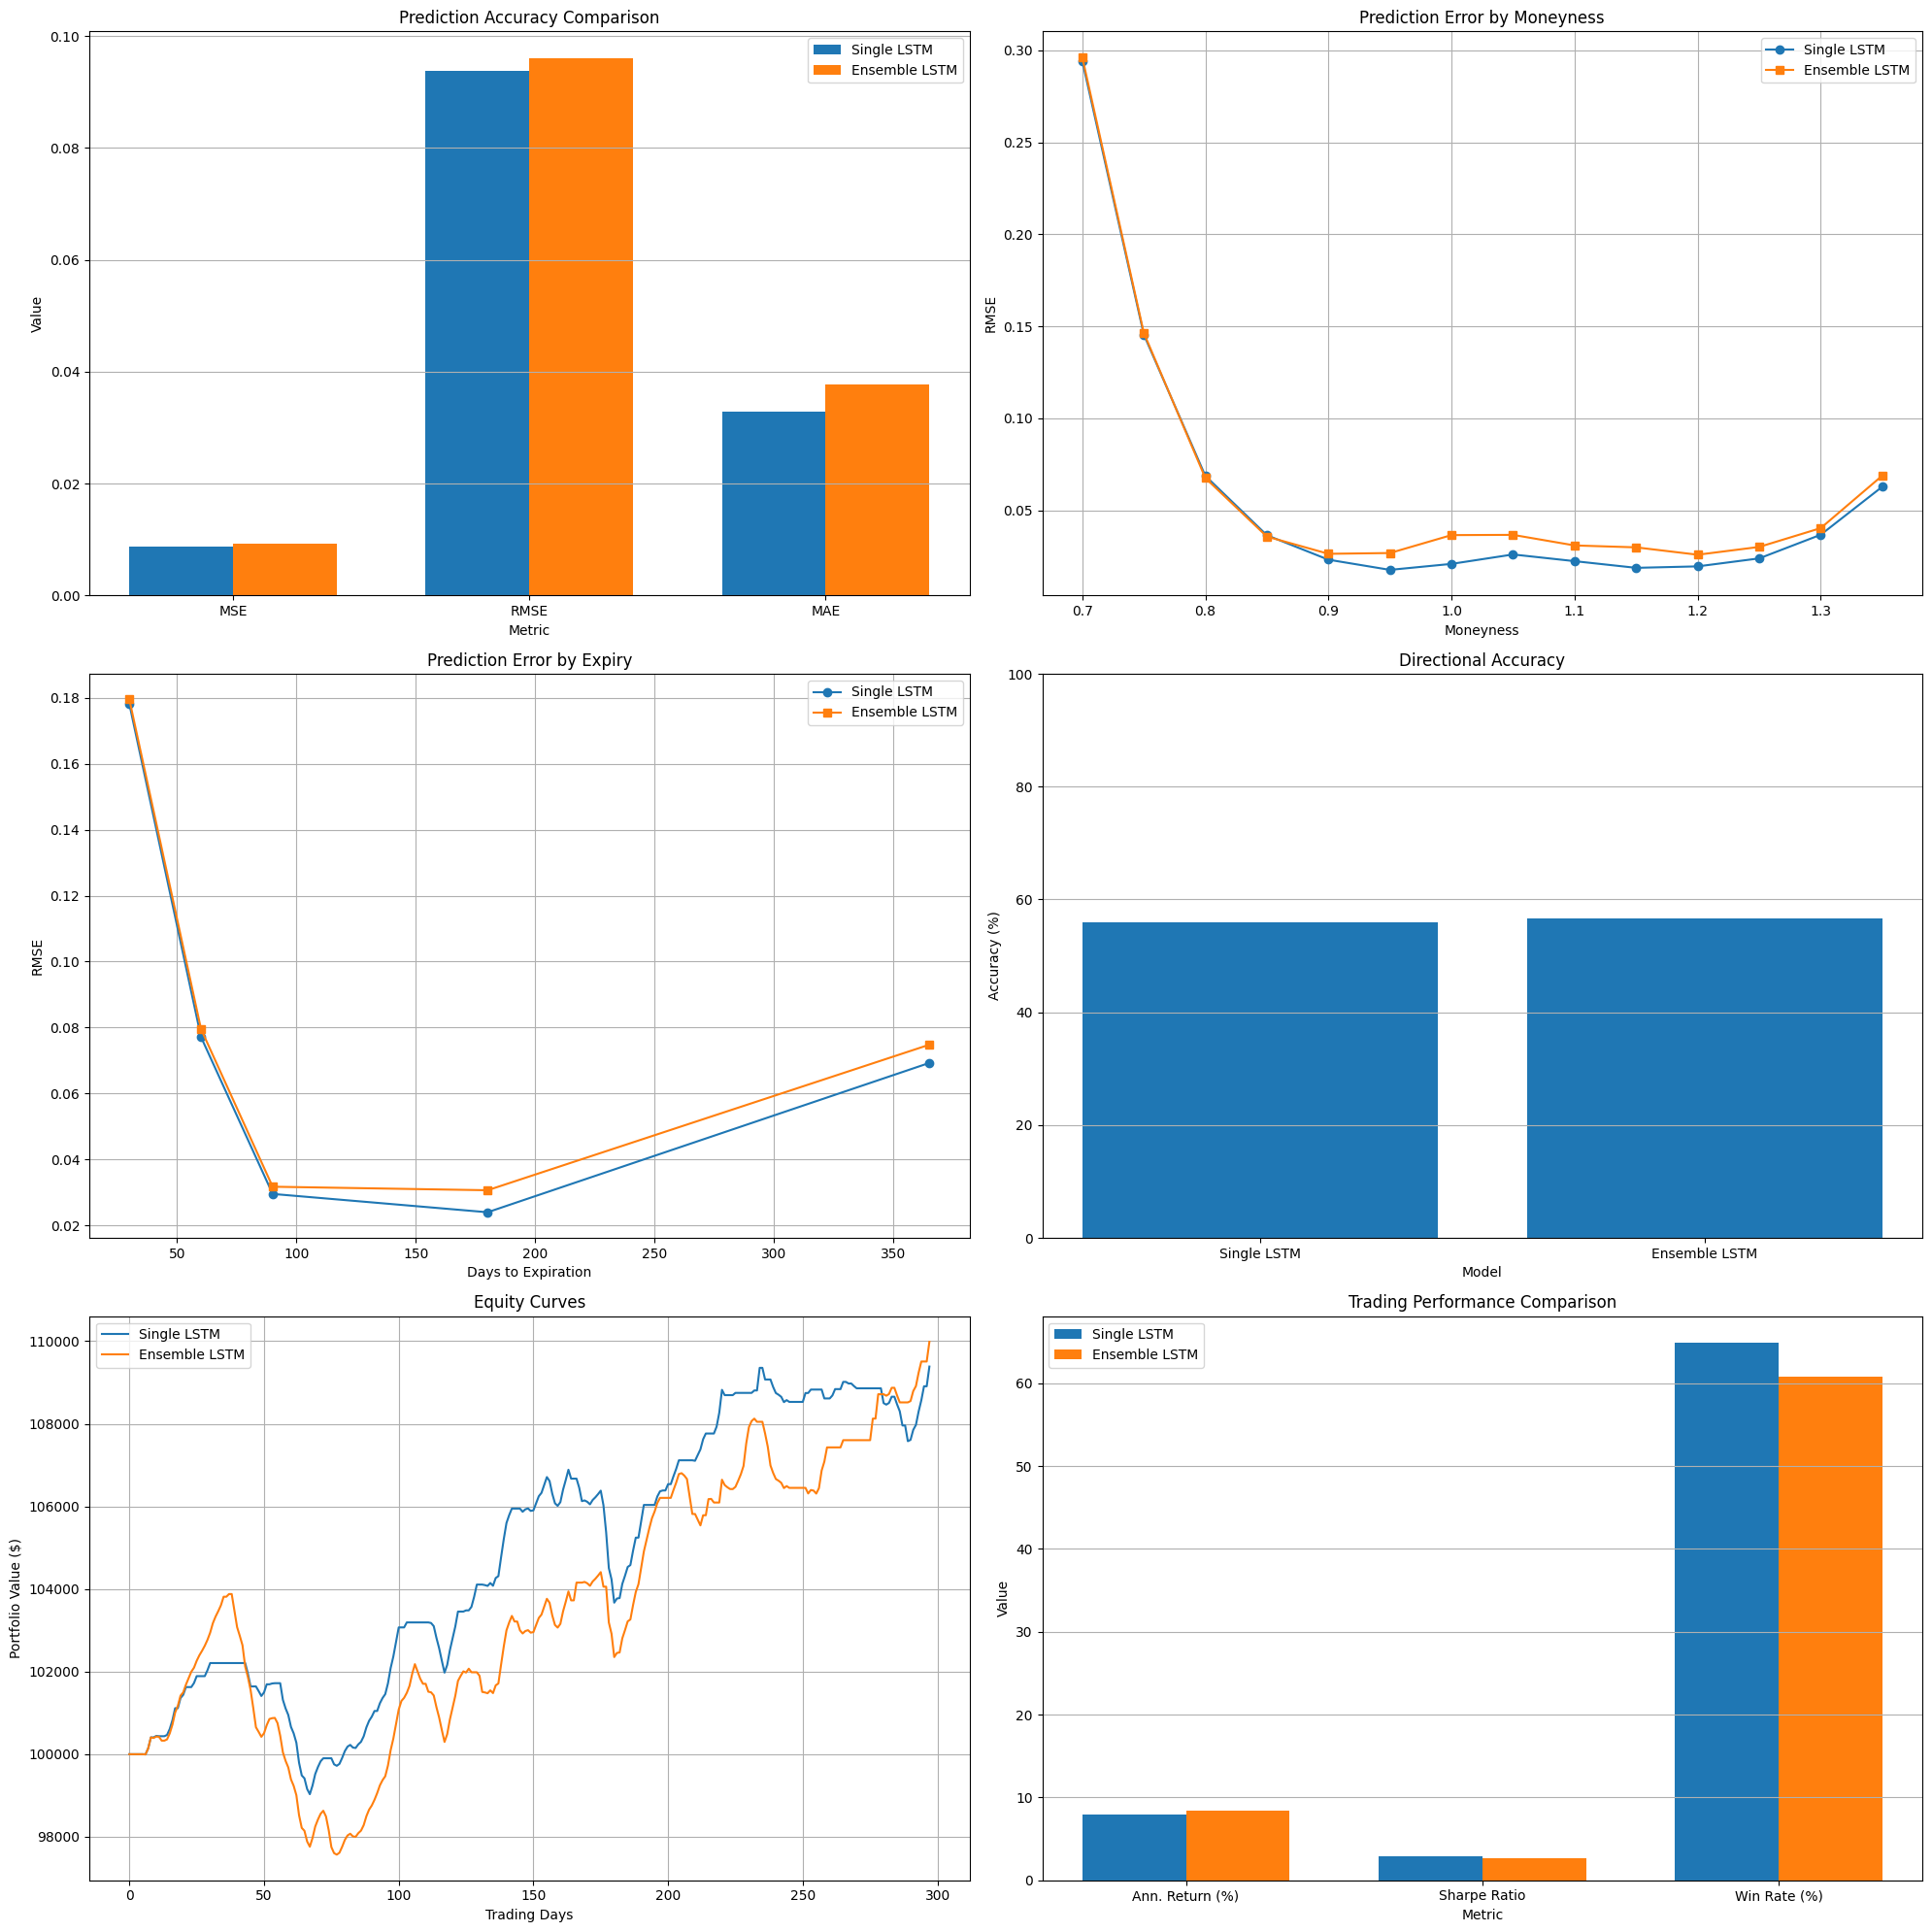


Comparison Summary:
--------------------------------------------------
Prediction Metrics:
  RMSE: Single=0.093746, Ensemble=0.096033, Improvement=-2.44%
  MAE: Single=0.032830, Ensemble=0.037684, Improvement=-14.78%

Directional Accuracy:
  Single=55.89%, Ensemble=56.57%

Trading Performance:
  Annualized Return: Single=7.88%, Ensemble=8.38%
  Sharpe Ratio: Single=2.91, Ensemble=2.62
  Maximum Drawdown: Single=3.11%, Ensemble=6.07%
  Win Rate: Single=64.86%, Ensemble=60.74%
  Number of Trades: Single=185, Ensemble=242


==== ANALYZING ENSEMBLE #2 ====

Generating predictions from both models...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Getting predictions from model 1/4...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Getting predictions from model 2/4...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Getting predictions from model 3/4...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Getting predictions from model 4/4...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Calculating prediction accuracy metrics...
C

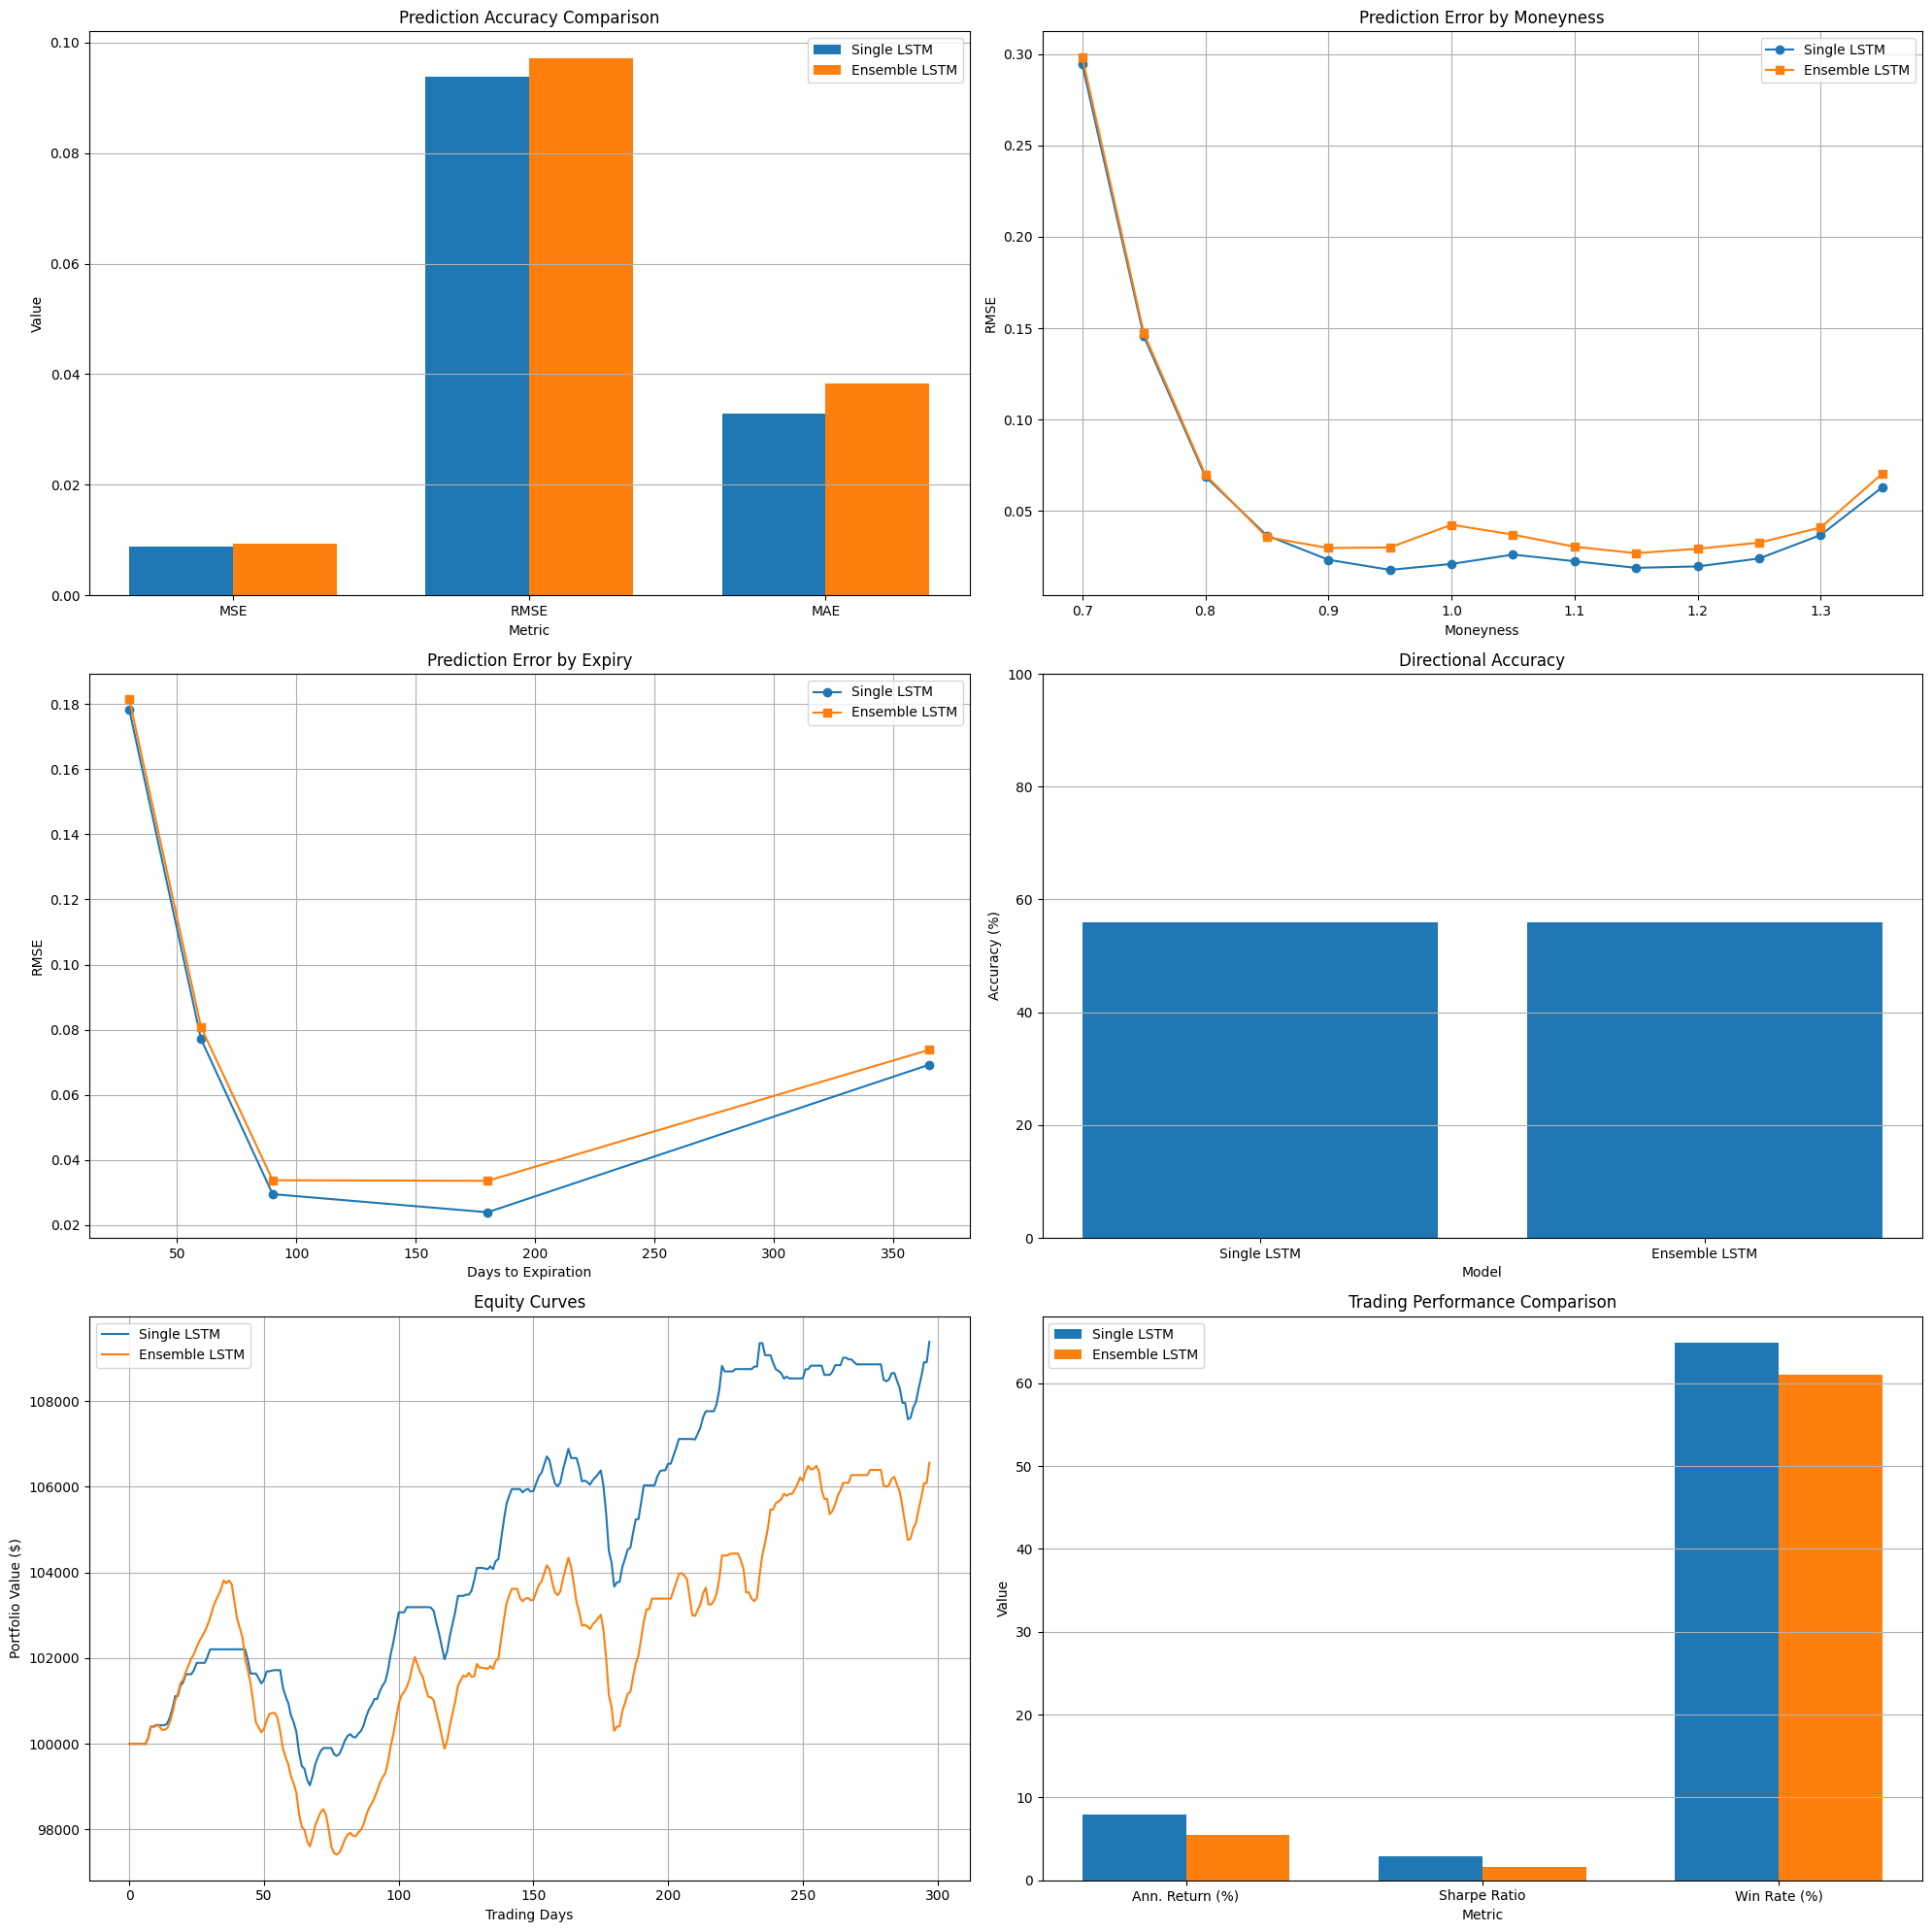


Comparison Summary:
--------------------------------------------------
Prediction Metrics:
  RMSE: Single=0.093746, Ensemble=0.097121, Improvement=-3.60%
  MAE: Single=0.032830, Ensemble=0.038303, Improvement=-16.67%

Directional Accuracy:
  Single=55.89%, Ensemble=55.89%

Trading Performance:
  Annualized Return: Single=7.88%, Ensemble=5.52%
  Sharpe Ratio: Single=2.91, Ensemble=1.62
  Maximum Drawdown: Single=3.11%, Ensemble=6.17%
  Win Rate: Single=64.86%, Ensemble=61.00%
  Number of Trades: Single=185, Ensemble=259


==== ANALYZING ENSEMBLE #3 ====

Generating predictions from both models...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Getting predictions from model 1/3...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Getting predictions from model 2/3...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Getting predictions from model 3/3...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Calculating prediction accuracy metrics...
Calculating directional accuracy...
Running trading strategy with both models..

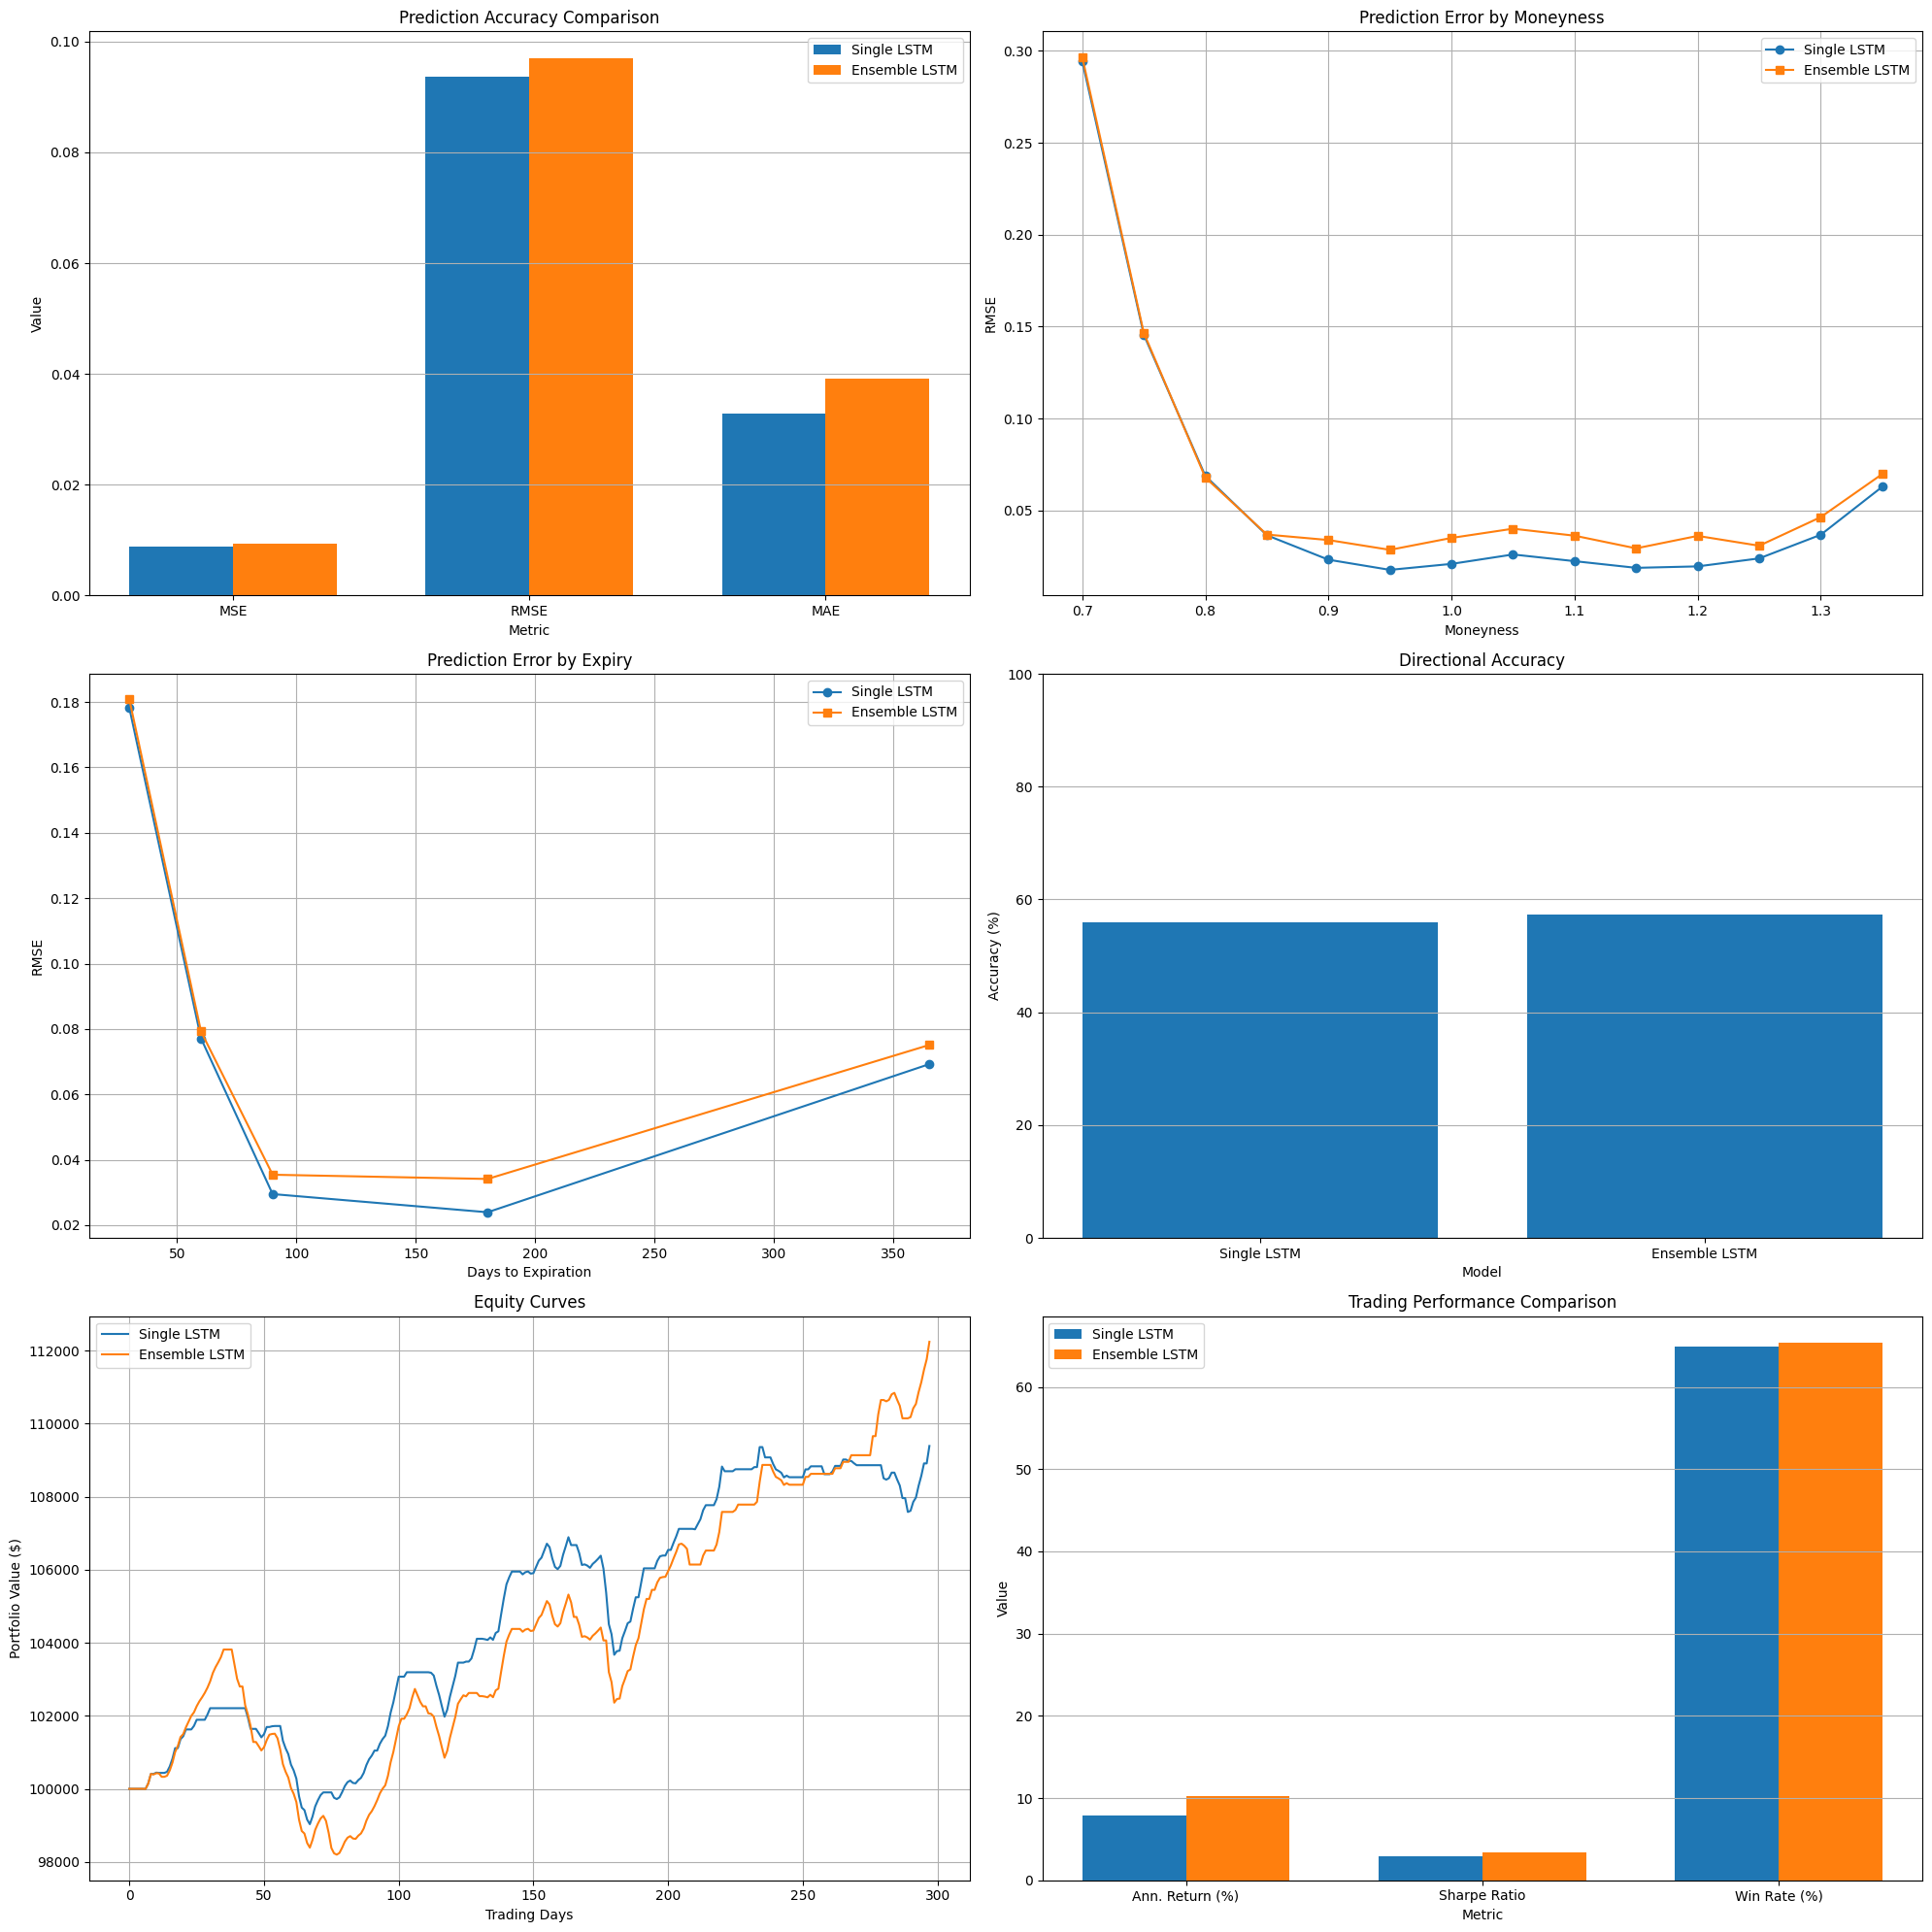


Comparison Summary:
--------------------------------------------------
Prediction Metrics:
  RMSE: Single=0.093746, Ensemble=0.096993, Improvement=-3.46%
  MAE: Single=0.032830, Ensemble=0.039231, Improvement=-19.50%

Directional Accuracy:
  Single=55.89%, Ensemble=57.24%

Trading Performance:
  Annualized Return: Single=7.88%, Ensemble=10.25%
  Sharpe Ratio: Single=2.91, Ensemble=3.36
  Maximum Drawdown: Single=3.11%, Ensemble=5.41%
  Win Rate: Single=64.86%, Ensemble=65.33%
  Number of Trades: Single=185, Ensemble=225


==== ANALYZING ENSEMBLE #4 ====

Generating predictions from both models...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Getting predictions from model 1/2...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Getting predictions from model 2/2...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Calculating prediction accuracy metrics...
Calculating directional accuracy...
Running trading strategy with both models...
Visualizing comparative results...


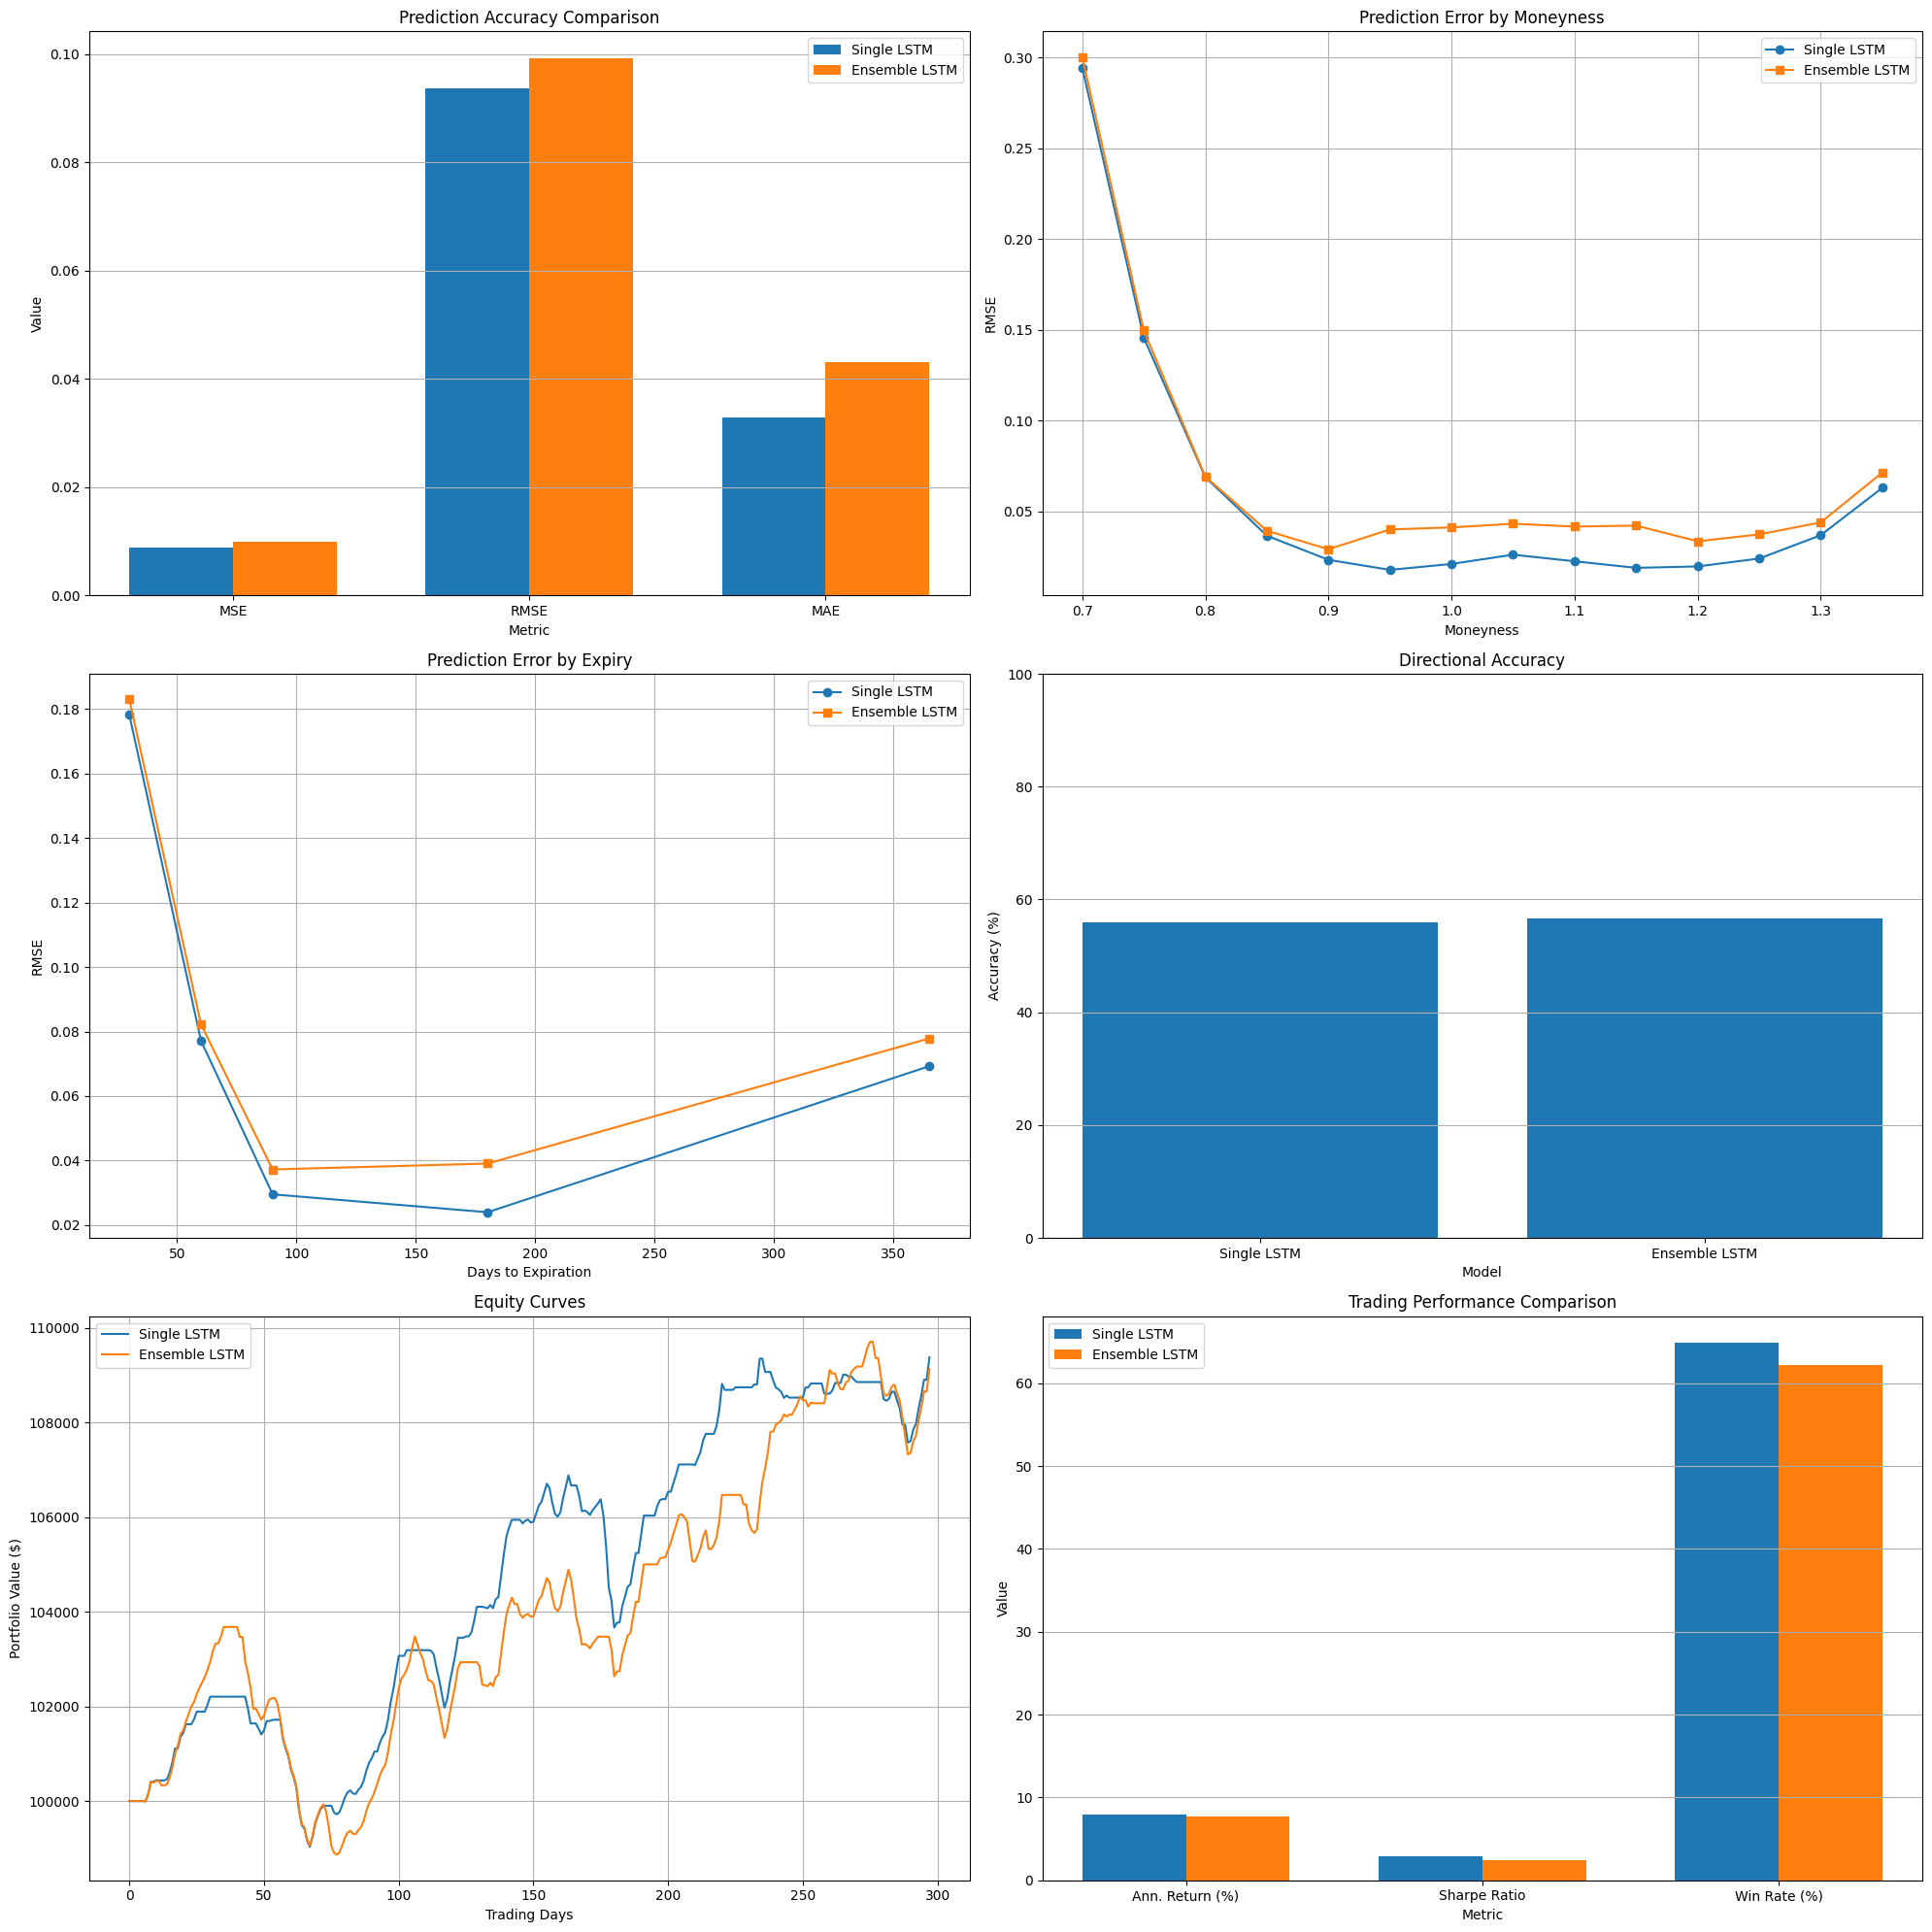


Comparison Summary:
--------------------------------------------------
Prediction Metrics:
  RMSE: Single=0.093746, Ensemble=0.099220, Improvement=-5.84%
  MAE: Single=0.032830, Ensemble=0.043098, Improvement=-31.27%

Directional Accuracy:
  Single=55.89%, Ensemble=56.57%

Trading Performance:
  Annualized Return: Single=7.88%, Ensemble=7.67%
  Sharpe Ratio: Single=2.91, Ensemble=2.48
  Maximum Drawdown: Single=3.11%, Ensemble=4.64%
  Win Rate: Single=64.86%, Ensemble=62.20%
  Number of Trades: Single=185, Ensemble=246


In [ ]:
# Extract moneyness levels
moneyness_levels = sorted(data['moneyness_bucket'].unique())

# Extract expiry buckets
expiry_buckets = sorted(data['expiry_bucket'].unique())

# Create underlying prices dictionary
underlying_prices = {}
for date, group in data.groupby('date'):
    underlying_prices[date] = group['underlying_price'].iloc[0]

for i, ensemble_result in enumerate([ensemble_results_1, ensemble_results_2, ensemble_results_3, ensemble_results_4], 1):
    print(f"\n\n==== ANALYZING ENSEMBLE #{i} ====\n")

    ensemble_model_list = ensemble_result['ensemble_models']


    comparison_results = comparative_analysis(
        single_model,
        ensemble_model_list,
        ensemble_result['X_test'],         # Test input data
        ensemble_result['y_test'],         # Test target data
        ensemble_result['test_dates'],
        ensemble_result['moneyness_levels'], # Moneyness levels
        ensemble_result['expiry_buckets'],   # Expiry buckets
        underlying_prices
    )

    exec(f"comparison_results_{i} = comparison_results")


In [ ]:
def compare_all_sharpe_ratios(backtest_results, ensemble_results_list):

    # Extract Sharpe ratios
    sharpe_ratios = []
    labels = []


    if 'sharpe_ratio' in backtest_results:
        sharpe_ratios.append(backtest_results['sharpe_ratio'])
        labels.append('Single LSTM')


    for i, ensemble_results in enumerate(ensemble_results_list, 1):
        if 'sharpe_ratio' in ensemble_results:
            sharpe_ratios.append(ensemble_results['sharpe_ratio'])
            labels.append(f'Ensemble {i}')

    # Create the visualization
    plt.figure(figsize=(12, 6))

    # Bar chart
    bars = plt.bar(labels, sharpe_ratios)


    for i, bar in enumerate(bars):
        if i == 0:
            bar.set_color('gray')
        else:
            bar.set_color(f'C{i}')

    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Sharpe Ratio Comparison Across All Models', fontsize=16)
    plt.ylabel('Sharpe Ratio', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    for i, v in enumerate(sharpe_ratios):
        plt.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()


    print("\nSharpe Ratio Comparison:")
    print("-" * 40)
    for label, sharpe in zip(labels, sharpe_ratios):
        print(f"{label}: {sharpe:.2f}")

    # Find the best model
    best_idx = np.argmax(sharpe_ratios)
    print(f"\nBest performing model: {labels[best_idx]} (Sharpe Ratio: {sharpe_ratios[best_idx]:.2f})")

    # Calculate improvement over single model
    if len(sharpe_ratios) > 1:
        single_sharpe = sharpe_ratios[0]
        best_ensemble_sharpe = max(sharpe_ratios[1:])
        improvement = (best_ensemble_sharpe - single_sharpe) / abs(single_sharpe) * 100
        print(f"Improvement over single model: {improvement:.2f}%")

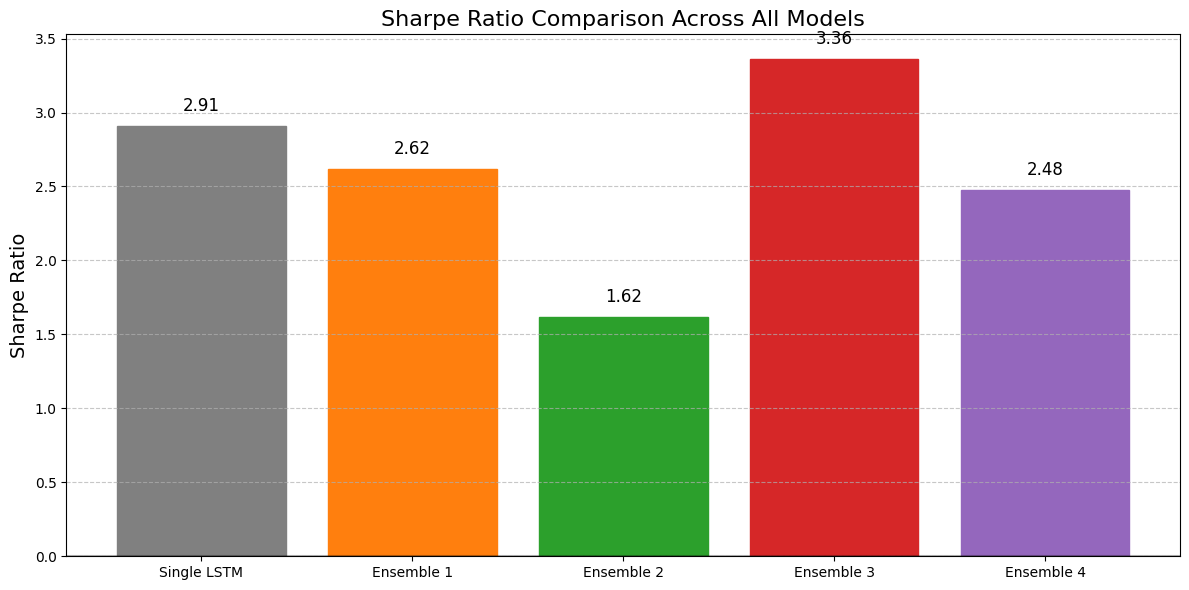


Sharpe Ratio Comparison:
----------------------------------------
Single LSTM: 2.91
Ensemble 1: 2.62
Ensemble 2: 1.62
Ensemble 3: 3.36
Ensemble 4: 2.48

Best performing model: Ensemble 3 (Sharpe Ratio: 3.36)
Improvement over single model: 15.50%


In [ ]:
ensemble_results_list = [
    ensemble_results_1,
    ensemble_results_2,
    ensemble_results_3,
    ensemble_results_4
]

compare_all_sharpe_ratios(backtest_results, ensemble_results_list)


In [ ]:
def gradient_based_importance(model, X_test, moneyness_levels, expiry_buckets):

    import tensorflow as tf

    print("Calculating gradient-based feature importance...")

    # Reshape data if needed
    if len(X_test.shape) == 4:
        n_samples, time_steps, n_moneyness, n_expiry = X_test.shape
        X_test_reshaped = X_test.reshape(n_samples, time_steps, n_moneyness * n_expiry)
    else:
        X_test_reshaped = X_test
        n_samples, time_steps, features = X_test_reshaped.shape
        n_moneyness = len(moneyness_levels)
        n_expiry = len(expiry_buckets)

    # Convert to TensorFlow tensor
    X_tensor = tf.convert_to_tensor(X_test_reshaped, dtype=tf.float32)

    # Gradients for each feature
    feature_gradients = []

    # Process in smaller batches to avoid memory issues
    batch_size = 32
    n_batches = int(np.ceil(n_samples / batch_size))

    for batch_idx in range(n_batches):
        print(f"Processing batch {batch_idx+1}/{n_batches}...")
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, n_samples)
        batch_X = X_tensor[start_idx:end_idx]

        # Calculate gradients using GradientTape
        with tf.GradientTape() as tape:
            tape.watch(batch_X)
            predictions = model(batch_X)

            output = tf.reduce_mean(predictions)

        # Get gradients
        gradients = tape.gradient(output, batch_X)
        feature_gradients.append(gradients.numpy())

    # Combine batches
    all_gradients = np.vstack(feature_gradients)

    grad_magnitudes = np.abs(all_gradients)
    avg_grad = np.mean(grad_magnitudes, axis=(0, 1))

    # Reshape to (moneyness, expiry)
    grad_surface = avg_grad.reshape(n_moneyness, n_expiry)

    # Calculate importance for moneyness levels
    moneyness_importance = []
    for m_idx, moneyness in enumerate(moneyness_levels):
        importance = np.mean(grad_surface[m_idx, :])
        moneyness_importance.append({
            'moneyness': moneyness,
            'importance': importance,
            'relative_importance': importance / np.mean(avg_grad) * 100
        })

    # Calculate importance for expiry buckets
    expiry_importance = []
    for e_idx, expiry in enumerate(expiry_buckets):
        importance = np.mean(grad_surface[:, e_idx])
        expiry_importance.append({
            'expiry': expiry,
            'importance': importance,
            'relative_importance': importance / np.mean(avg_grad) * 100
        })

    # Create heatmap data for visualization
    heatmap_data = {
        'surface': grad_surface,
        'moneyness_levels': moneyness_levels,
        'expiry_buckets': expiry_buckets
    }

    # Compile results
    grad_importance = {
        'moneyness_importance': moneyness_importance,
        'expiry_importance': expiry_importance,
        'heatmap_data': heatmap_data
    }

    # Visualize
    visualize_gradient_importance(grad_importance)

    return grad_importance

def visualize_gradient_importance(grad_importance):

    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)
    heatmap_data = grad_importance['heatmap_data']
    surface = heatmap_data['surface']
    moneyness_levels = heatmap_data['moneyness_levels']
    expiry_buckets = heatmap_data['expiry_buckets']

    plt.imshow(surface, cmap='viridis', aspect='auto')
    plt.colorbar(label='Gradient Magnitude')
    plt.title('Gradient-Based Feature Importance Heatmap')
    plt.xlabel('Expiry Bucket Index')
    plt.ylabel('Moneyness Level Index')

    # Add tick labels
    plt.xticks(range(len(expiry_buckets)), expiry_buckets, rotation=45)
    plt.yticks(range(len(moneyness_levels)), moneyness_levels)

    plt.subplot(2, 2, 2)
    moneyness_list = [item['moneyness'] for item in grad_importance['moneyness_importance']]
    importance_values = [item['relative_importance'] for item in grad_importance['moneyness_importance']]

    plt.bar(moneyness_list, importance_values)
    plt.title('Gradient-Based Importance by Moneyness')
    plt.xlabel('Moneyness')
    plt.ylabel('Relative Importance (%)')
    plt.grid(axis='y')

    plt.subplot(2, 2, 3)
    expiry_list = [item['expiry'] for item in grad_importance['expiry_importance']]
    importance_values = [item['relative_importance'] for item in grad_importance['expiry_importance']]

    plt.bar(expiry_list, importance_values)
    plt.title('Gradient-Based Importance by Expiry')
    plt.xlabel('Days to Expiration')
    plt.ylabel('Relative Importance (%)')
    plt.grid(axis='y')

    ax = plt.subplot(2, 2, 4, projection='3d')
    X, Y = np.meshgrid(expiry_buckets, moneyness_levels)
    ax.plot_surface(X, Y, surface, cmap='viridis')
    ax.set_title('3D Feature Importance Surface')
    ax.set_xlabel('Days to Expiration')
    ax.set_ylabel('Moneyness')
    ax.set_zlabel('Importance')

    plt.tight_layout()
    plt.show()

    print("\nGradient-Based Feature Importance Summary:")
    print("-" * 50)

    sorted_moneyness = sorted(grad_importance['moneyness_importance'],
                             key=lambda x: x['relative_importance'], reverse=True)
    print("By Moneyness:")
    for i, item in enumerate(sorted_moneyness[:3]):
        print(f"  {i+1}. Moneyness = {item['moneyness']}: {item['relative_importance']:.2f}%")

    sorted_expiry = sorted(grad_importance['expiry_importance'],
                          key=lambda x: x['relative_importance'], reverse=True)
    print("\nBy Expiry:")
    for i, item in enumerate(sorted_expiry[:3]):
        print(f"  {i+1}. Expiry = {item['expiry']} days: {item['relative_importance']:.2f}%")

In [ ]:
def run_feature_importance_analysis(model, X_test, y_test, moneyness_levels, expiry_buckets):

    print("\n" + "="*50)
    print("RUNNING COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS")
    print("="*50 + "\n")

    gradient_results = gradient_based_importance(
        model, X_test, moneyness_levels, expiry_buckets
    )

    all_results = {
        'gradient': gradient_results
    }

    compare_importance_methods(all_results, moneyness_levels, expiry_buckets)

    return all_results

def compare_importance_methods(all_results, moneyness_levels, expiry_buckets):

    print("\n" + "="*50)
    print("COMPARING FEATURE IMPORTANCE METHODS")
    print("="*50)

    # Create a combined visualization
    plt.figure(figsize=(20, 15))

    plt.subplot(2, 1, 1)

    # Get data from each method
    methods = []

    if all_results['gradient'] is not None:
        methods.append('Gradient')
        grad_moneyness = all_results['gradient']['moneyness_importance']
        grad_values = [item['relative_importance'] for item in grad_moneyness]
    else:
        grad_values = None

    # Set up width and positions for bars
    x = np.arange(len(moneyness_levels))
    width = 0.25
    n_methods = len(methods)
    offsets = np.linspace(-(n_methods-1)*width/2, (n_methods-1)*width/2, n_methods)

    # Plot each method
    for i, method in enumerate(methods):
        if method == 'Gradient' and grad_values is not None:
            plt.bar(x + offsets[i], grad_values, width, label=f'{method}')


    plt.xlabel('Moneyness')
    plt.ylabel('Relative Importance (%)')
    plt.title('Feature Importance by Moneyness - Method Comparison')
    plt.xticks(x, moneyness_levels)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(2, 1, 2)

    if all_results['gradient'] is not None:
        grad_expiry = all_results['gradient']['expiry_importance']
        grad_values = [item['relative_importance'] for item in grad_expiry]
    else:
        grad_values = None

    x = np.arange(len(expiry_buckets))

    # Plot each method
    for i, method in enumerate(methods):
        if method == 'Gradient' and grad_values is not None:
            plt.bar(x + offsets[i], grad_values, width, label=f'{method}')


    plt.xlabel('Days to Expiration')
    plt.ylabel('Relative Importance (%)')
    plt.title('Feature Importance by Expiry - Method Comparison')
    plt.xticks(x, expiry_buckets)
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

    # Print combined summary
    print("\nCombined Feature Importance Analysis Summary:")
    print("-" * 60)

    # Identify most important moneyness levels
    important_moneyness = {}
    for method in methods:
        if method == 'Gradient' and all_results['gradient'] is not None:
            sorted_moneyness = sorted(all_results['gradient']['moneyness_importance'],
                                    key=lambda x: x['relative_importance'], reverse=True)
            important_moneyness[method] = [item['moneyness'] for item in sorted_moneyness[:3]]

    # Identify most important expiry buckets
    important_expiry = {}
    for method in methods:
        if method == 'Gradient' and all_results['gradient'] is not None:
            sorted_expiry = sorted(all_results['gradient']['expiry_importance'],
                                  key=lambda x: x['relative_importance'], reverse=True)
            important_expiry[method] = [item['expiry'] for item in sorted_expiry[:3]]

    # Print most important moneyness levels across methods
    print("Most Important Moneyness Levels:")
    for method, top_moneyness in important_moneyness.items():
        print(f"  {method} method: {', '.join([str(m) for m in top_moneyness])}")

    # Print most important expiry buckets across methods
    print("\nMost Important Expiry Buckets:")
    for method, top_expiry in important_expiry.items():
        print(f"  {method} method: {', '.join([str(e) for e in top_expiry])}")

    # Find consensus important features
    consensus_moneyness = []
    for m in moneyness_levels:
        count = sum(1 for method_list in important_moneyness.values() if m in method_list)
        if count >= 2 and len(methods) >= 2:
            consensus_moneyness.append(m)

    consensus_expiry = []
    for e in expiry_buckets:
        count = sum(1 for method_list in important_expiry.values() if e in method_list)
        if count >= 2 and len(methods) >= 2:  # At least 2 methods agree
            consensus_expiry.append(e)

    # Print consensus
    print("\nConsensus Important Features (identified by multiple methods):")
    if consensus_moneyness:
        print(f"  Moneyness levels: {', '.join([str(m) for m in consensus_moneyness])}")
    else:
        print("  No consensus on important moneyness levels")

    if consensus_expiry:
        print(f"  Expiry buckets: {', '.join([str(e) for e in consensus_expiry])}")
    else:
        print("  No consensus on important expiry buckets")

    print("\nVolatility Surface Interpretation:")
    if 1.0 in consensus_moneyness or abs(min(moneyness_levels, key=lambda x: abs(x-1.0)) - 1.0) < 0.05:
        print("  • At-the-Money (ATM) options show high importance, suggesting the ATM volatility")
        print("    level is a critical predictor of future volatility surfaces.")

    if any(m < 0.9 for m in consensus_moneyness):
        print("  • Out-of-the-Money (OTM) puts (moneyness < 0.9) are important, indicating")
        print("    that the volatility skew (put side) contains significant predictive information.")

    if any(m > 1.1 for m in consensus_moneyness):
        print("  • Out-of-the-Money (OTM) calls (moneyness > 1.1) are important, suggesting")
        print("    that the call side of the volatility smile has predictive value.")

    if any(e <= 30 for e in consensus_expiry):
        print("  • Short-term options (≤ 30 days) show high importance, indicating that")
        print("    near-term implied volatility is particularly informative for predictions.")

    if any(e >= 180 for e in consensus_expiry):
        print("  • Long-term options (≥ 180 days) are important, suggesting that the long end")
        print("    of the volatility term structure contains valuable predictive information.")


RUNNING COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS

Performing permutation importance analysis...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Baseline MSE: 0.009009
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Moneyness 0.7: Importance = 0.000054, Relative = 0.60%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Moneyness 0.75: Importance

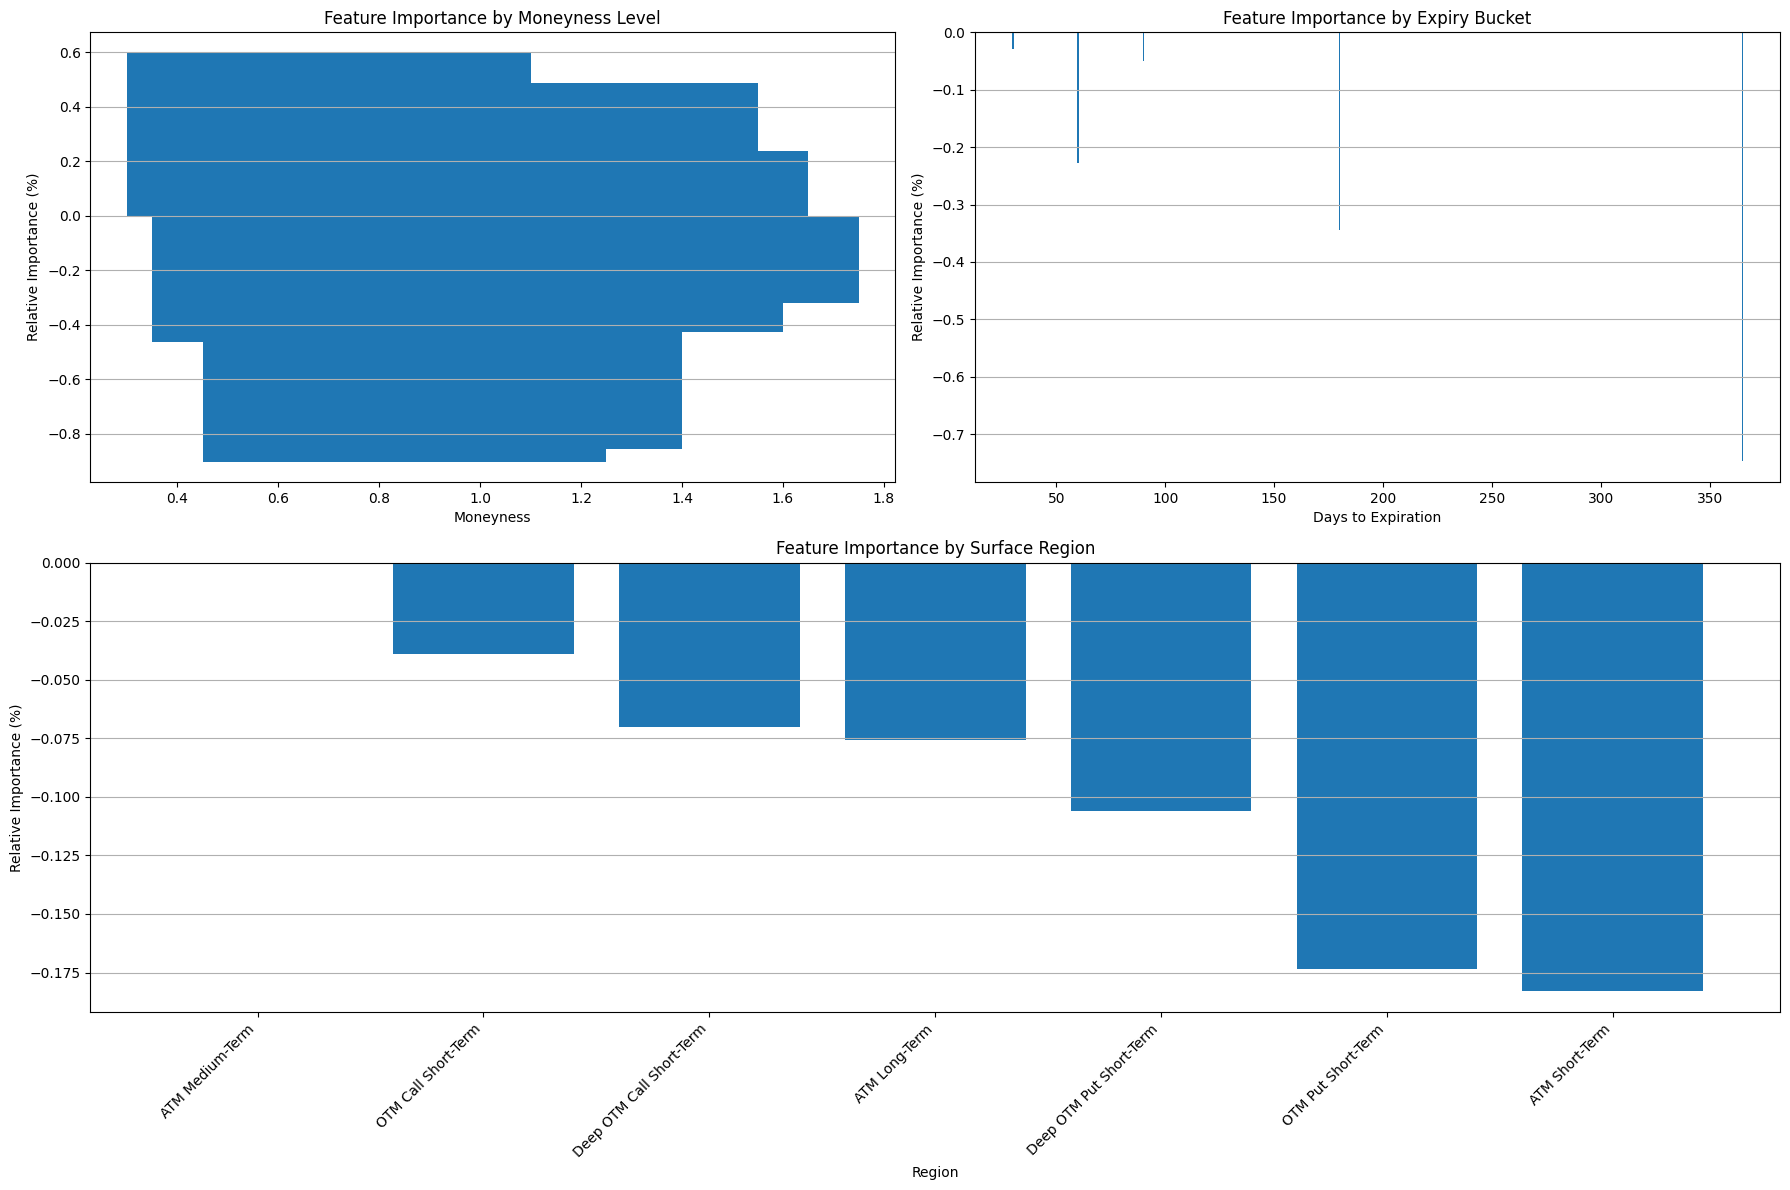


Most Important Features:
--------------------------------------------------
By Moneyness:
  1. Moneyness = 0.7: 0.60%
  2. Moneyness = 1.1500000000000004: 0.49%
  3. Moneyness = 1.1000000000000003: 0.25%

By Expiry:
  1. Expiry = 30 days: -0.03%
  2. Expiry = 90 days: -0.05%
  3. Expiry = 60 days: -0.23%

By Region:
  1. ATM Medium-Term: -0.00%
  2. OTM Call Short-Term: -0.04%
  3. Deep OTM Call Short-Term: -0.07%
Calculating gradient-based feature importance...
Processing batch 1/7...
Processing batch 2/7...
Processing batch 3/7...
Processing batch 4/7...
Processing batch 5/7...
Processing batch 6/7...
Processing batch 7/7...


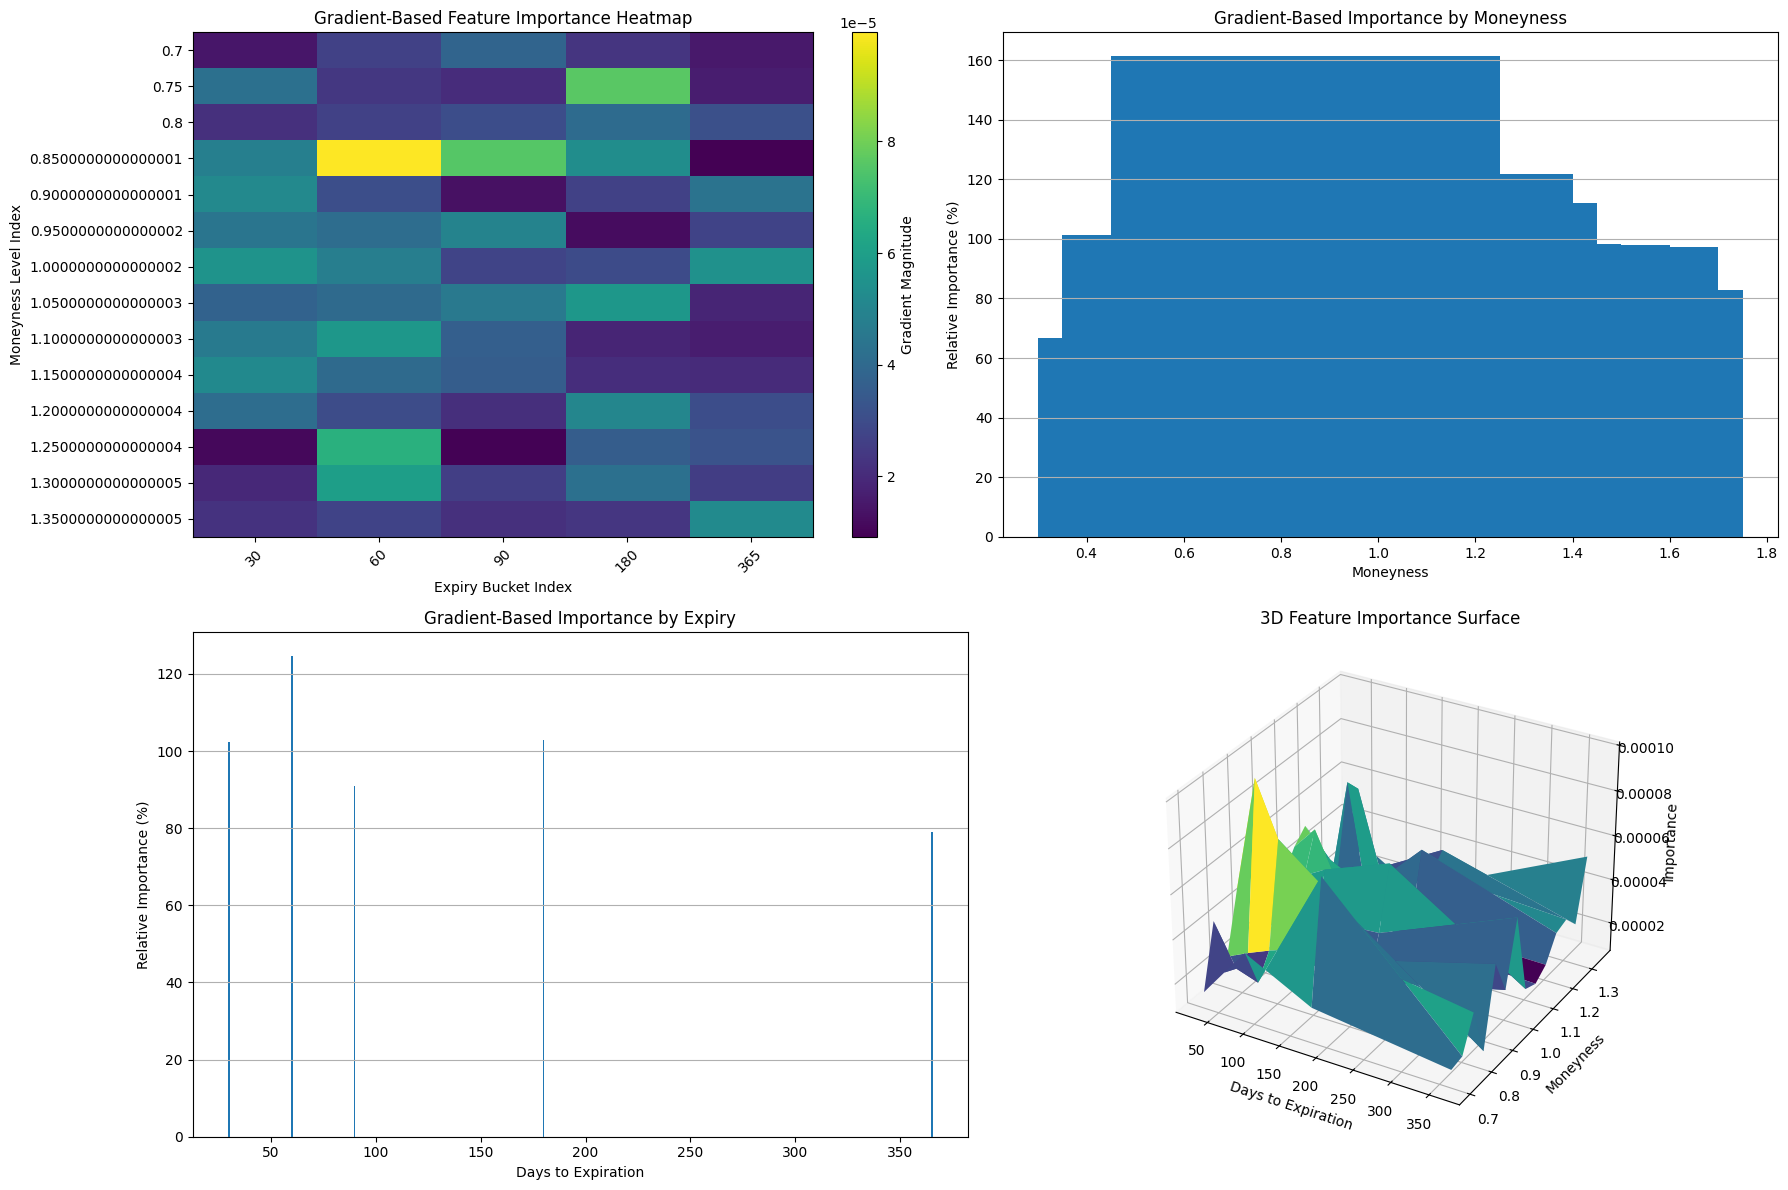


Gradient-Based Feature Importance Summary:
--------------------------------------------------
By Moneyness:
  1. Moneyness = 0.8500000000000001: 161.23%
  2. Moneyness = 1.0000000000000002: 121.75%
  3. Moneyness = 1.0500000000000003: 112.10%

By Expiry:
  1. Expiry = 60 days: 124.62%
  2. Expiry = 180 days: 102.85%
  3. Expiry = 30 days: 102.43%

Would you like to run SHAP analysis? This can be computationally intensive.
Enter 'y' to run SHAP analysis, any other key to skip: n
Skipping SHAP analysis.

COMPARING FEATURE IMPORTANCE METHODS


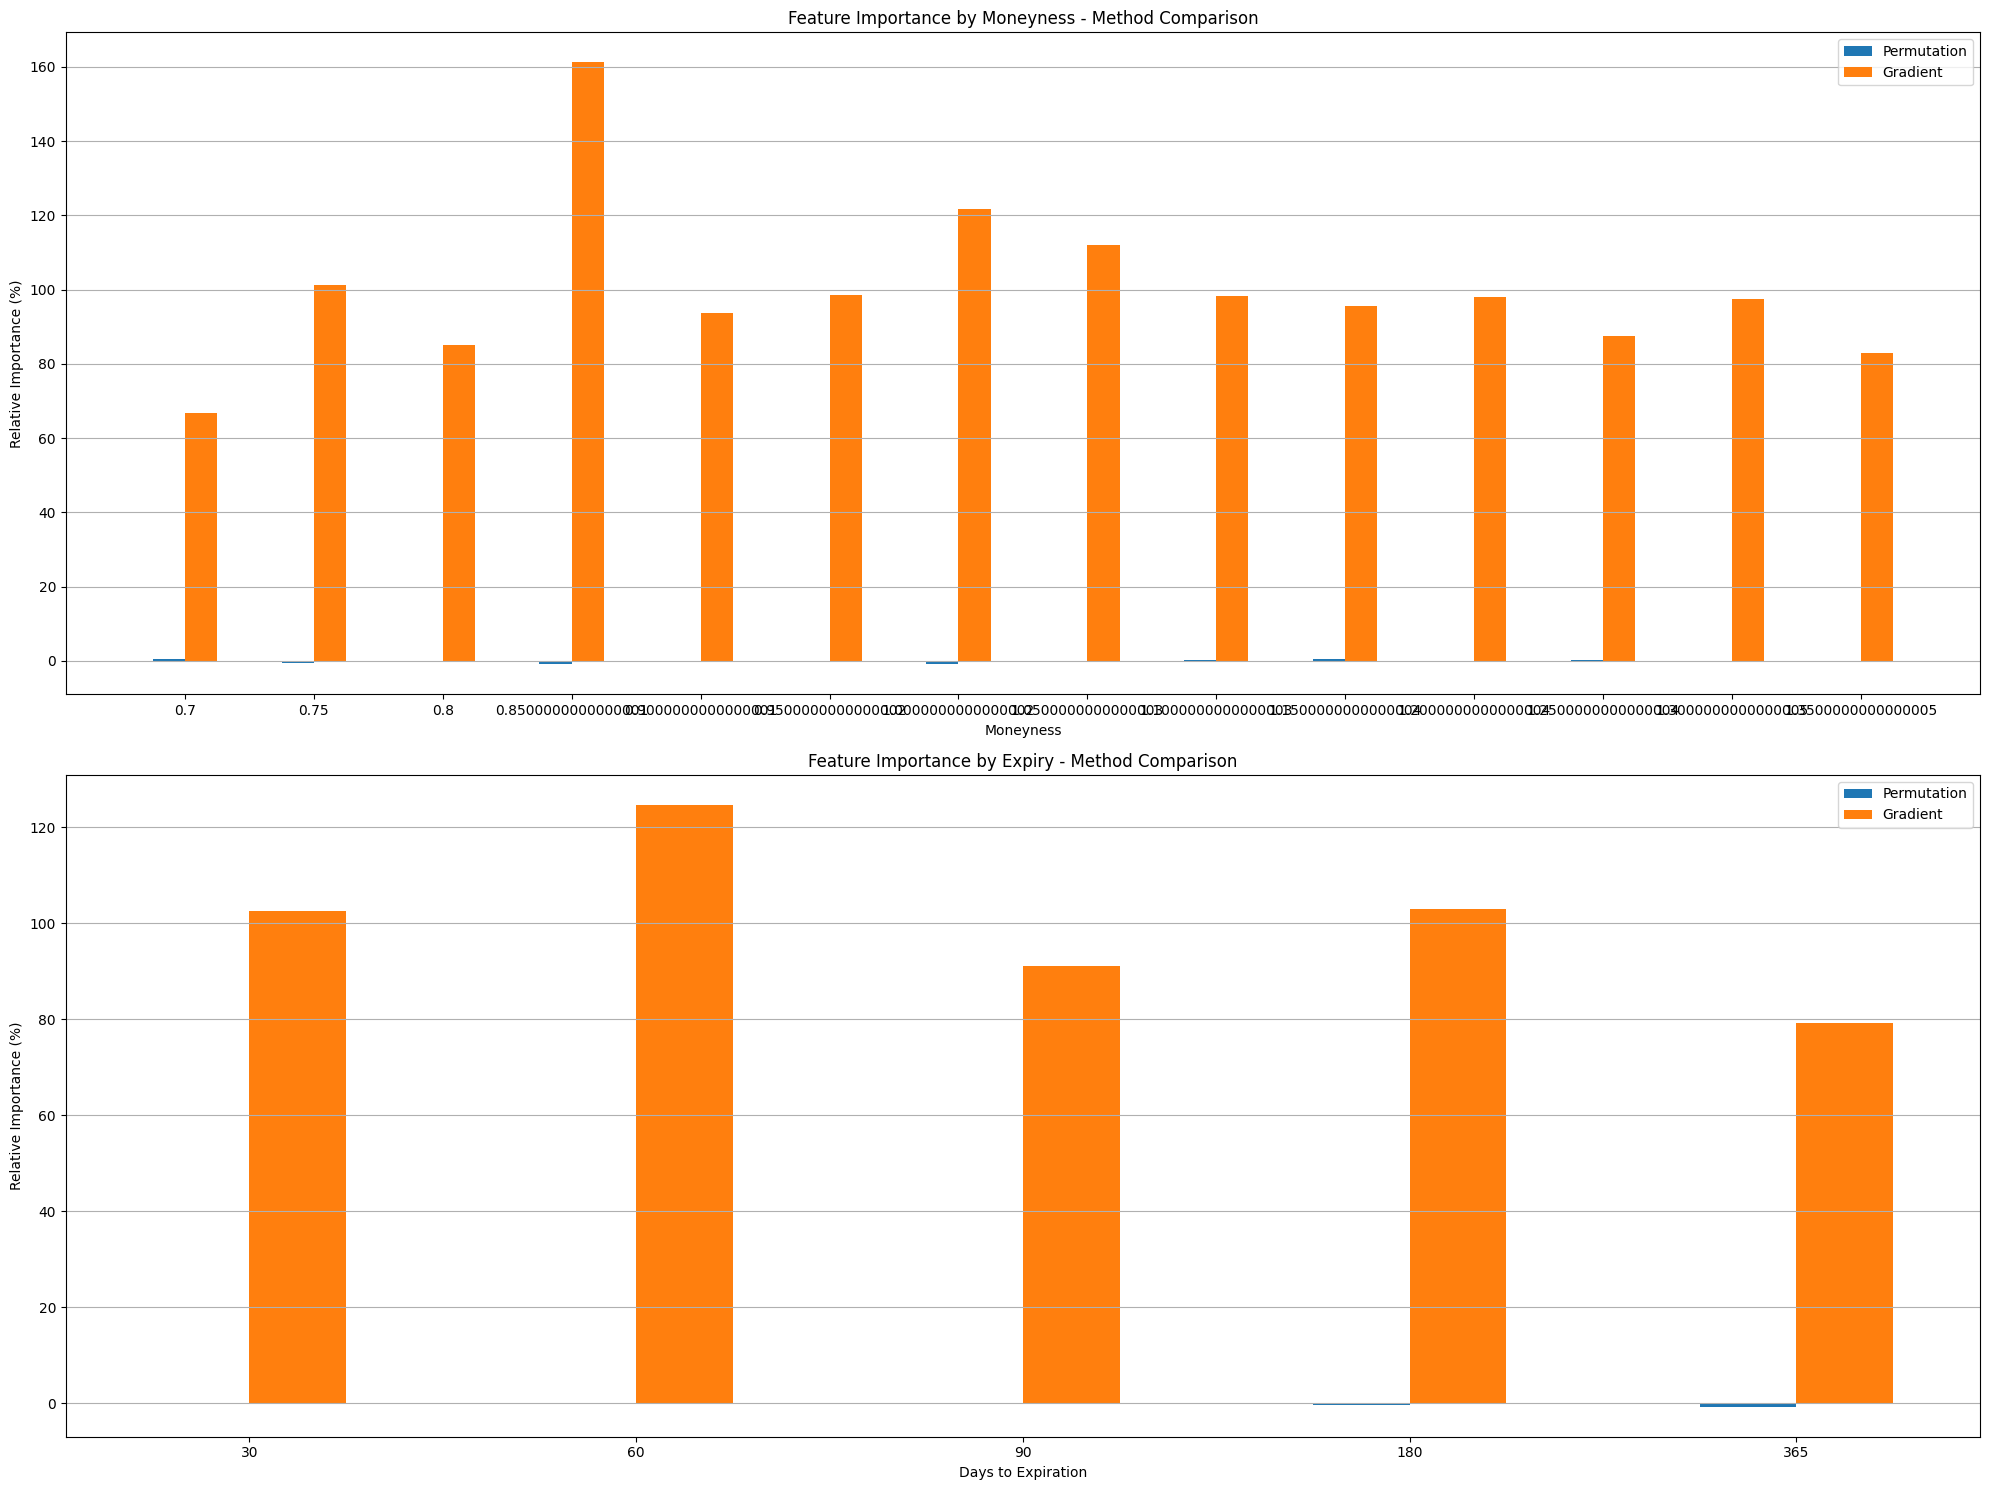


Combined Feature Importance Analysis Summary:
------------------------------------------------------------
Most Important Moneyness Levels:
  Permutation method: 0.7, 1.1500000000000004, 1.1000000000000003
  Gradient method: 0.8500000000000001, 1.0000000000000002, 1.0500000000000003

Most Important Expiry Buckets:
  Permutation method: 30, 90, 60
  Gradient method: 60, 180, 30

Consensus Important Features (identified by multiple methods):
  No consensus on important moneyness levels
  Expiry buckets: 30, 60

Volatility Surface Interpretation:
  • At-the-Money (ATM) options show high importance, suggesting the ATM volatility
    level is a critical predictor of future volatility surfaces.
  • Short-term options (≤ 30 days) show high importance, indicating that
    near-term implied volatility is particularly informative for predictions.


In [ ]:
importance_results = run_feature_importance_analysis(
    model=single_model,
    X_test=X_test,
    y_test=y_test,
    moneyness_levels=moneyness_levels,
    expiry_buckets=expiry_buckets
)


RUNNING COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS

Performing permutation importance analysis...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Baseline MSE: 0.009838
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Moneyness 0.7: Importance = -0.000085, Relative = -0.87%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━

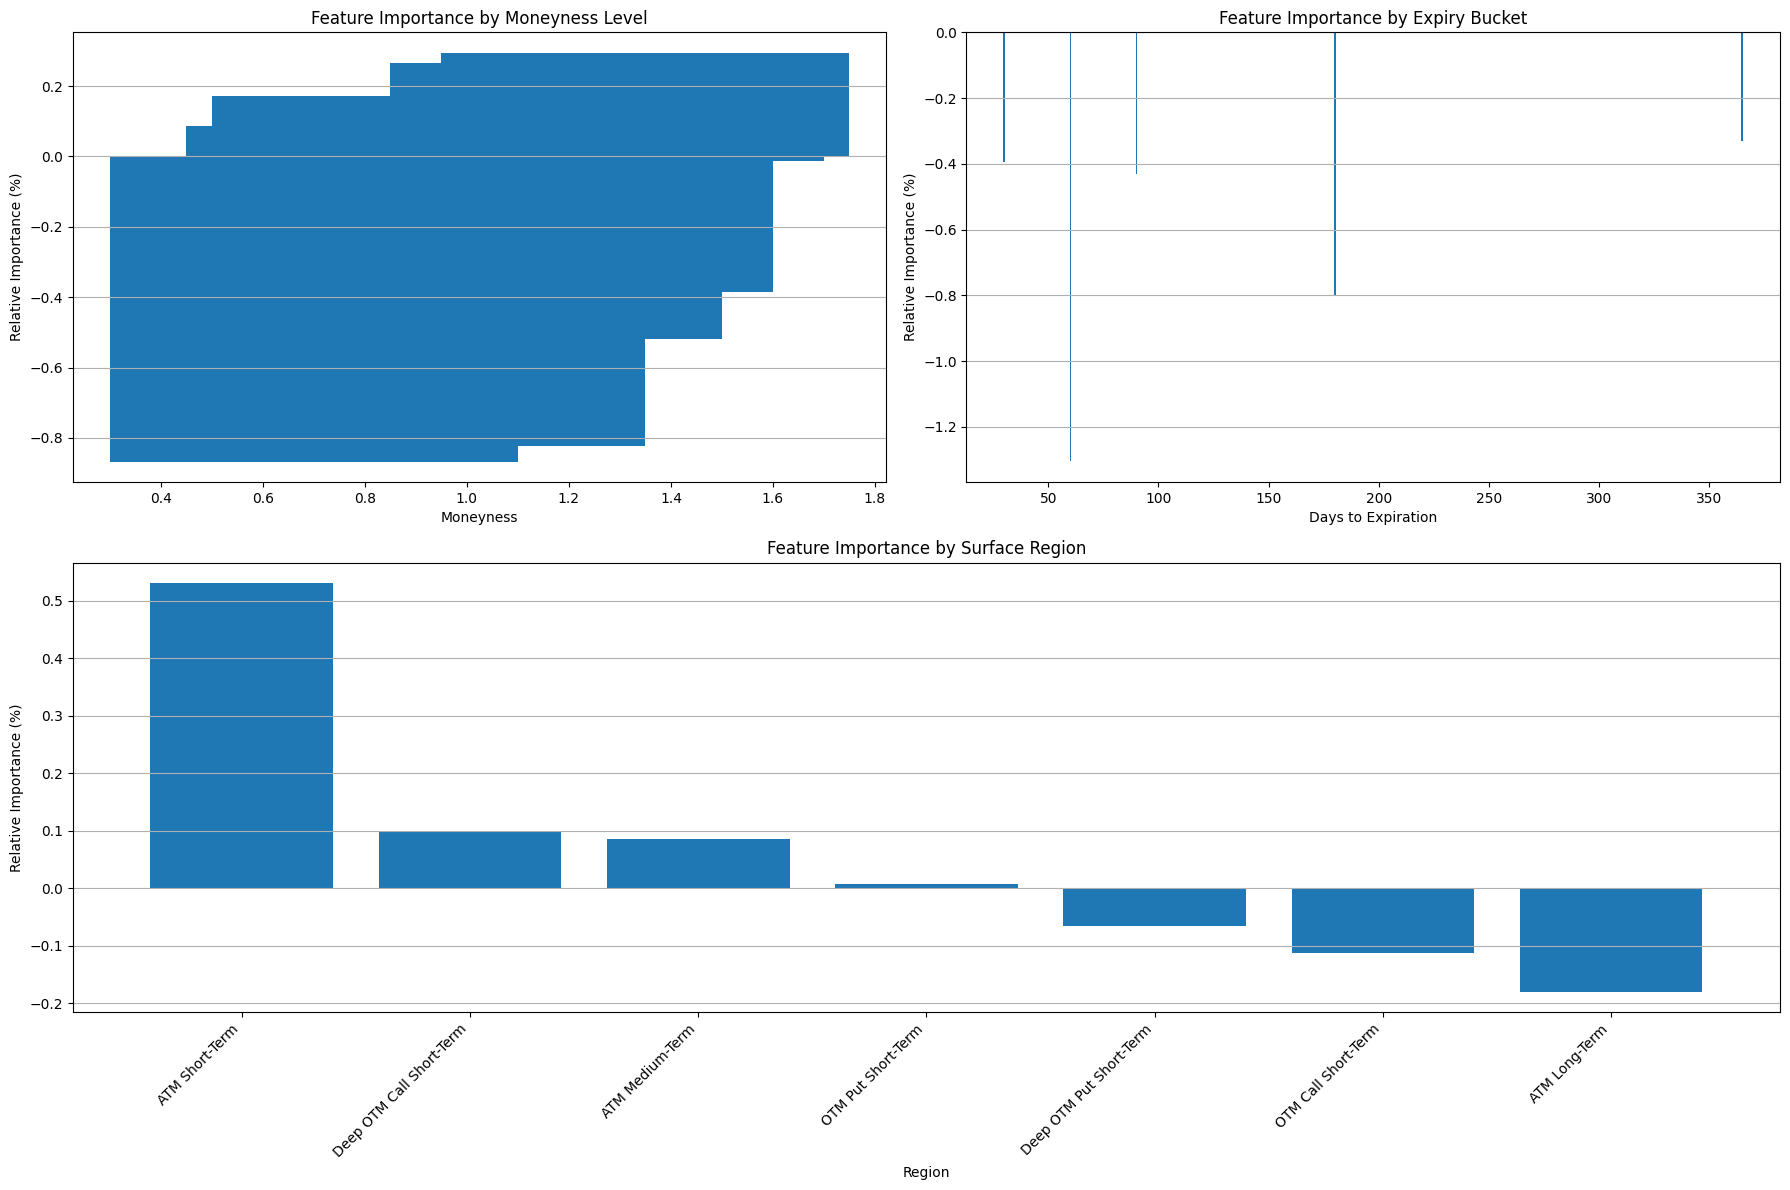


Most Important Features:
--------------------------------------------------
By Moneyness:
  1. Moneyness = 1.3500000000000005: 0.29%
  2. Moneyness = 1.2500000000000004: 0.27%
  3. Moneyness = 0.9000000000000001: 0.17%

By Expiry:
  1. Expiry = 365 days: -0.33%
  2. Expiry = 30 days: -0.39%
  3. Expiry = 90 days: -0.43%

By Region:
  1. ATM Short-Term: 0.53%
  2. Deep OTM Call Short-Term: 0.10%
  3. ATM Medium-Term: 0.09%
Calculating gradient-based feature importance...
Processing batch 1/10...
Processing batch 2/10...
Processing batch 3/10...
Processing batch 4/10...
Processing batch 5/10...
Processing batch 6/10...
Processing batch 7/10...
Processing batch 8/10...
Processing batch 9/10...
Processing batch 10/10...


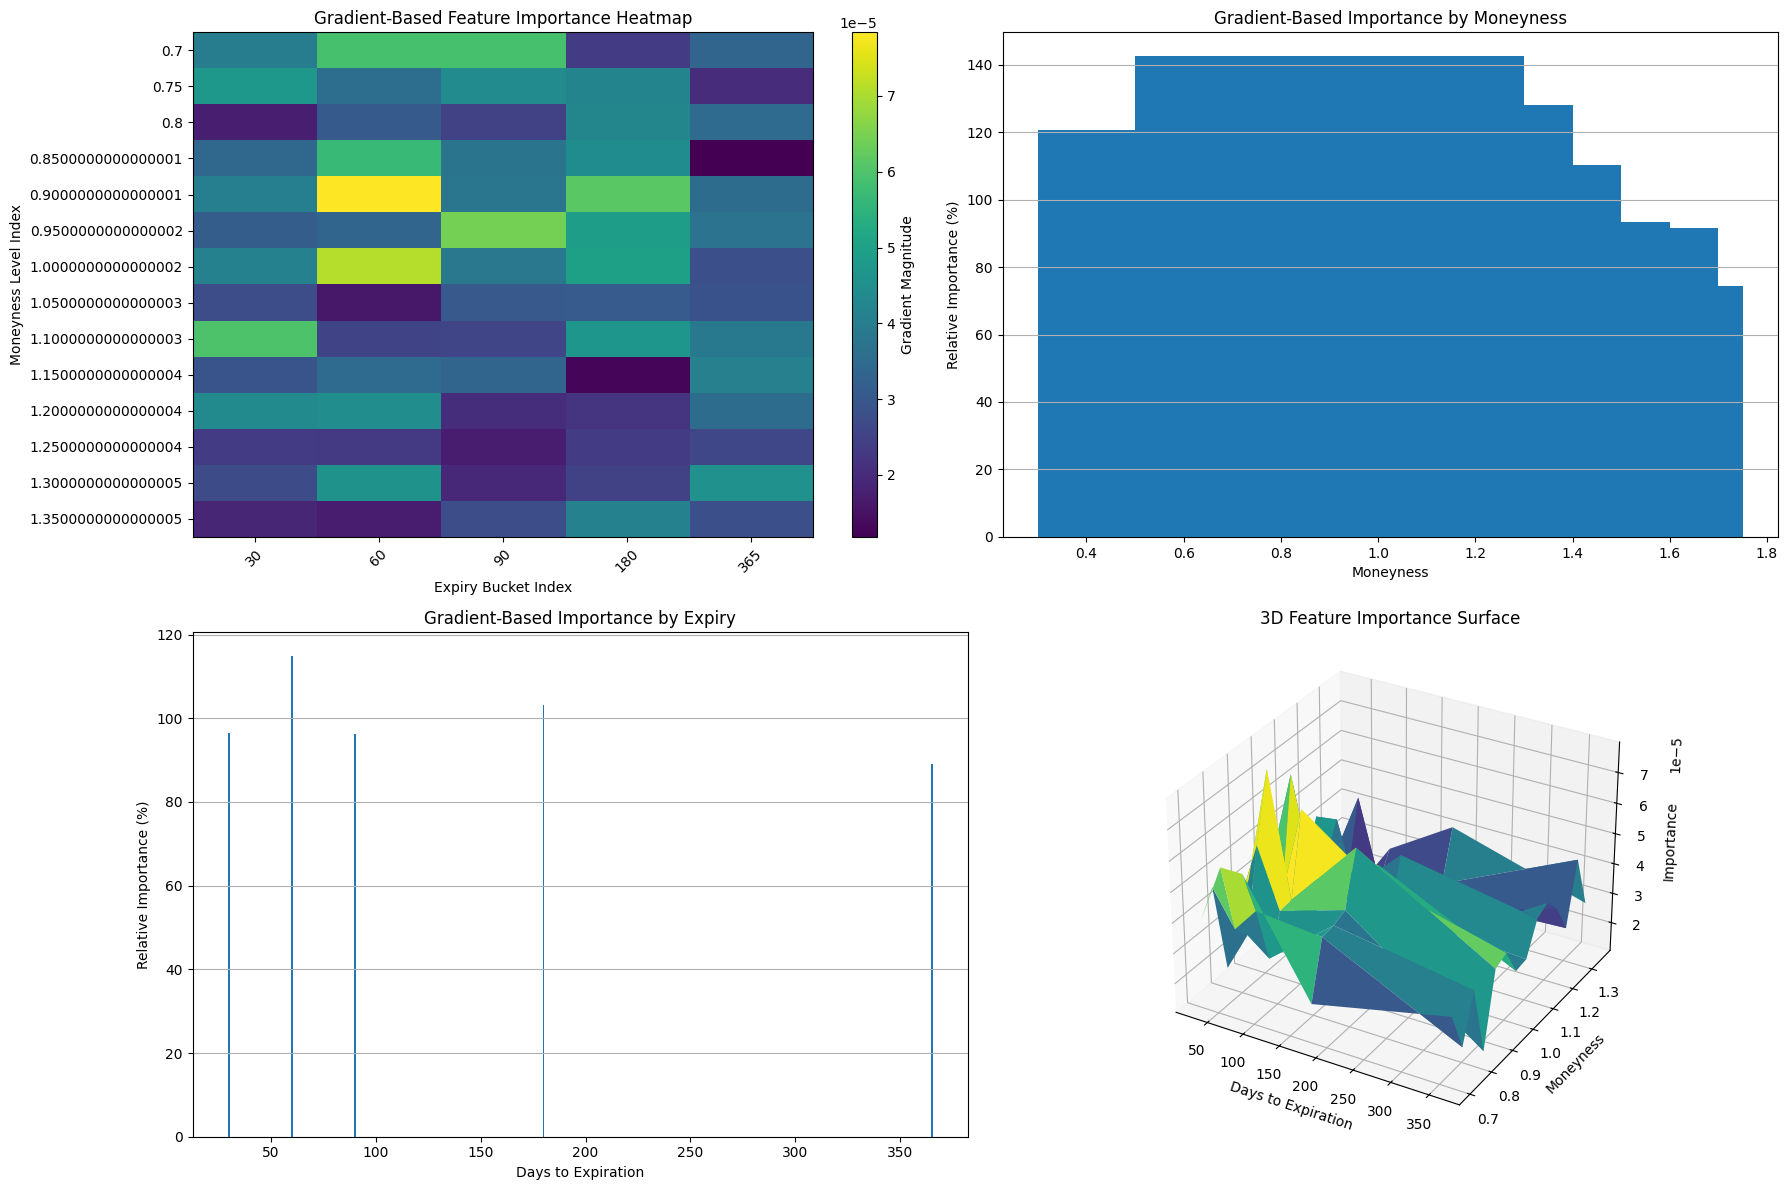


Gradient-Based Feature Importance Summary:
--------------------------------------------------
By Moneyness:
  1. Moneyness = 0.9000000000000001: 142.46%
  2. Moneyness = 1.0000000000000002: 128.08%
  3. Moneyness = 0.9500000000000002: 121.30%

By Expiry:
  1. Expiry = 60 days: 114.85%
  2. Expiry = 180 days: 103.12%
  3. Expiry = 30 days: 96.56%

Would you like to run SHAP analysis? This can be computationally intensive.
Enter 'y' to run SHAP analysis, any other key to skip: n
Skipping SHAP analysis.

COMPARING FEATURE IMPORTANCE METHODS


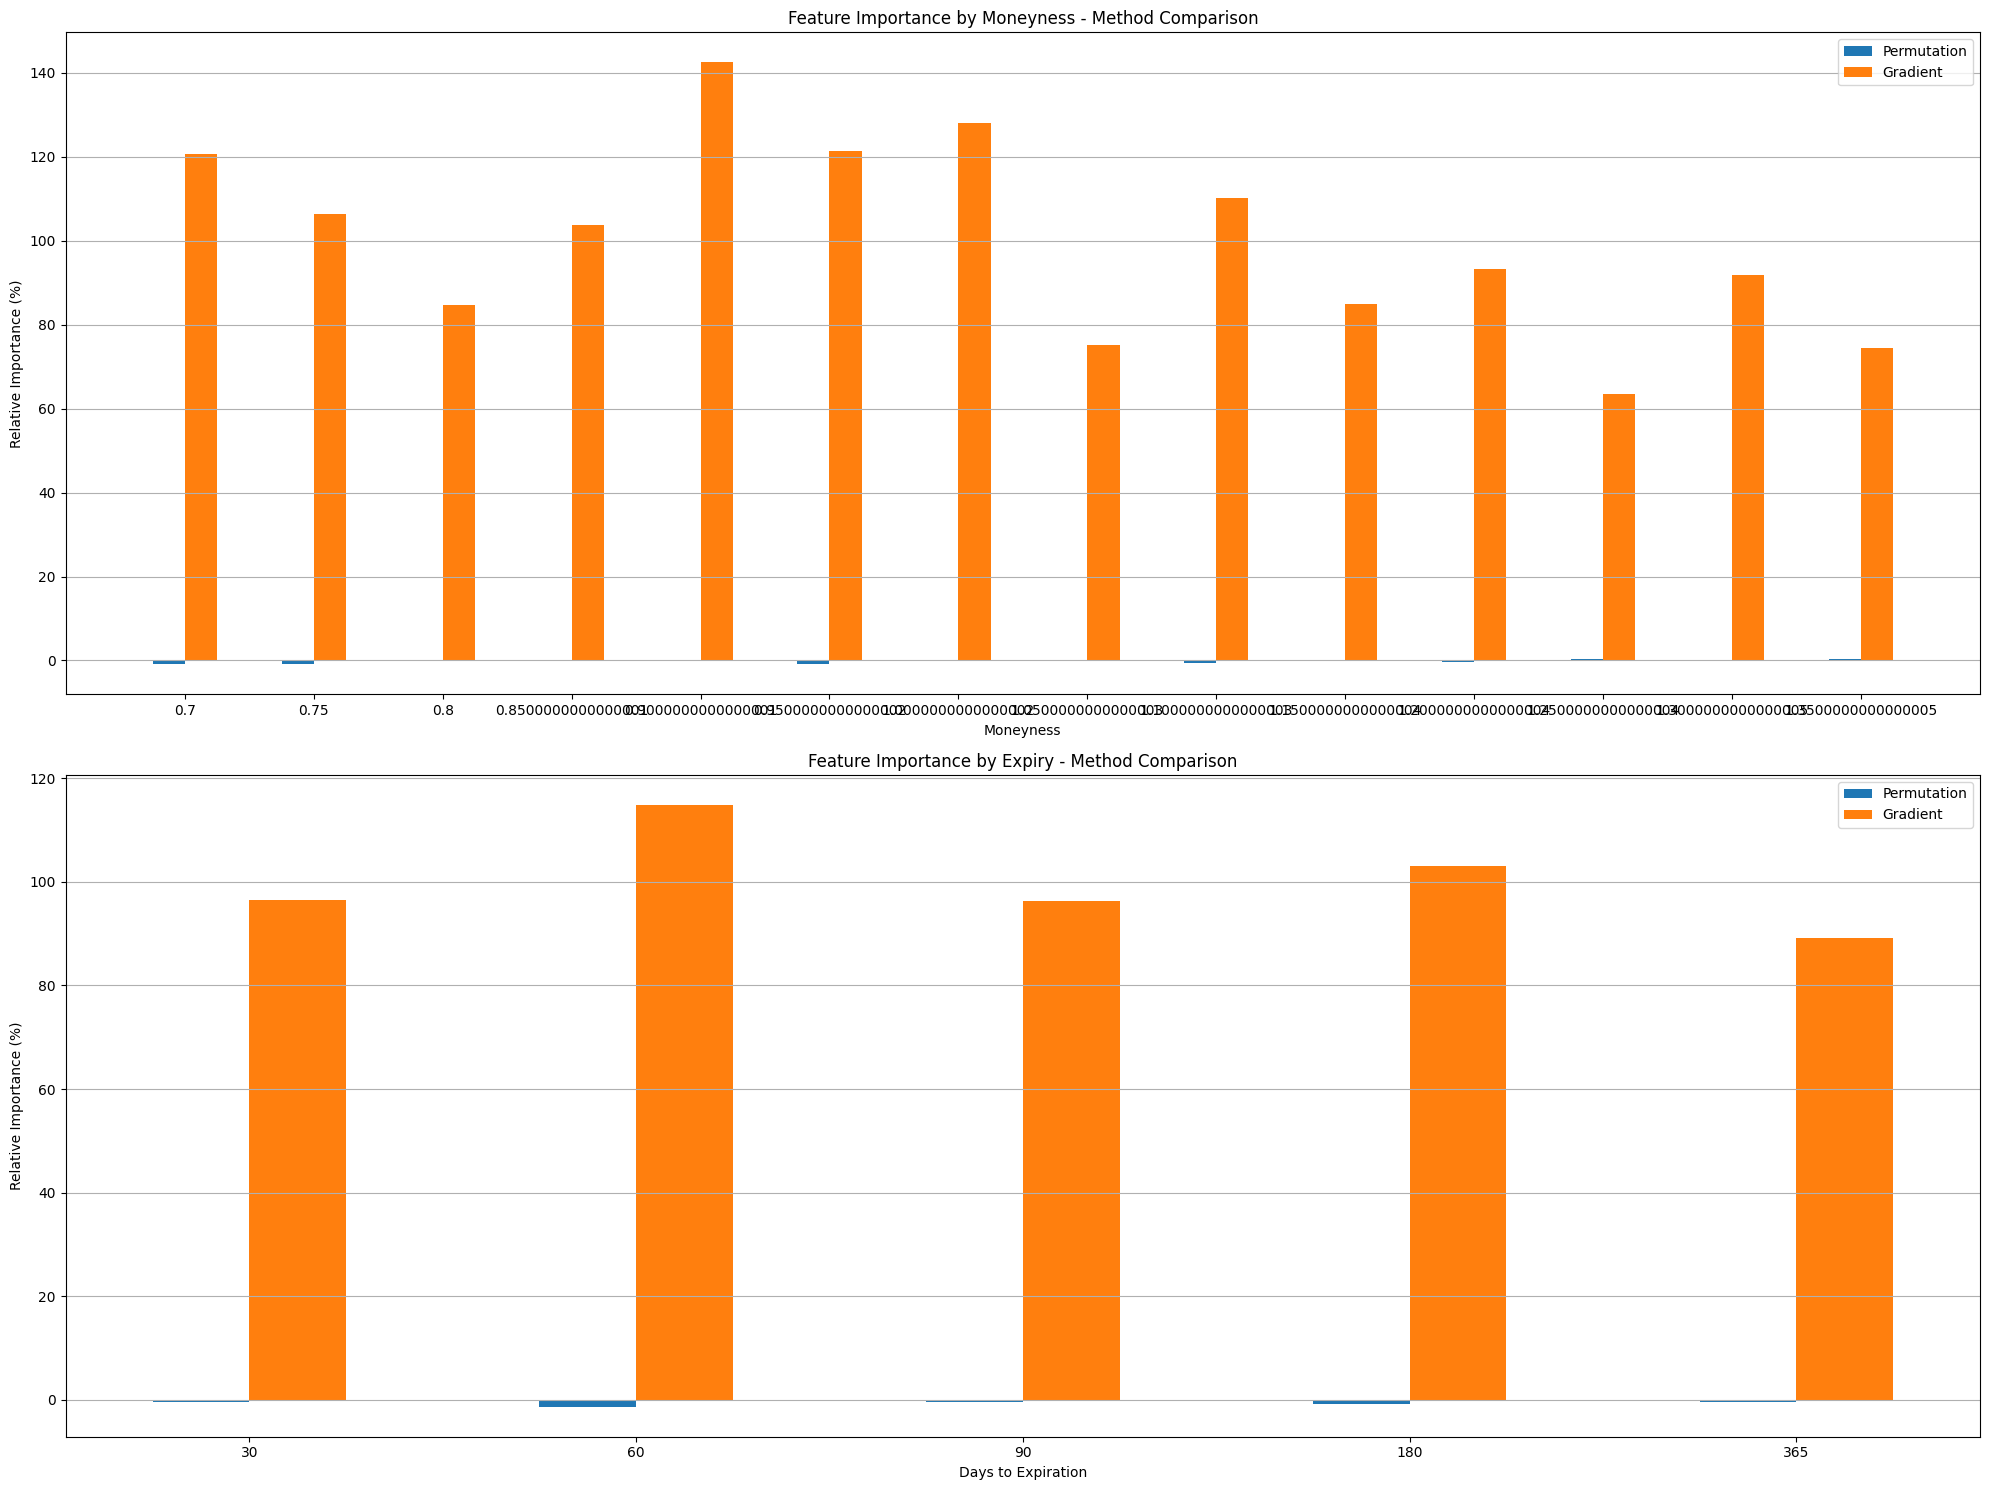


Combined Feature Importance Analysis Summary:
------------------------------------------------------------
Most Important Moneyness Levels:
  Permutation method: 1.3500000000000005, 1.2500000000000004, 0.9000000000000001
  Gradient method: 0.9000000000000001, 1.0000000000000002, 0.9500000000000002

Most Important Expiry Buckets:
  Permutation method: 365, 30, 90
  Gradient method: 60, 180, 30

Consensus Important Features (identified by multiple methods):
  Moneyness levels: 0.9000000000000001
  Expiry buckets: 30

Volatility Surface Interpretation:
  • At-the-Money (ATM) options show high importance, suggesting the ATM volatility
    level is a critical predictor of future volatility surfaces.
  • Short-term options (≤ 30 days) show high importance, indicating that
    near-term implied volatility is particularly informative for predictions.


In [ ]:
ensemble_model_list = ensemble_results_3['ensemble_models']
X_test = ensemble_results_3['X_test']
y_test = ensemble_results_3['y_test']
moneyness_levels = ensemble_results_3['moneyness_levels']
expiry_buckets = ensemble_results_3['expiry_buckets']

importance_results = run_feature_importance_analysis(
    model=ensemble_model_list[0],
    X_test=X_test,
    y_test=y_test,
    moneyness_levels=moneyness_levels,
    expiry_buckets=expiry_buckets
)

In [ ]:
ensemble_model_list = ensemble_results_4['ensemble_models']
X_test = ensemble_results_4['X_test']
y_test = ensemble_results_4['y_test']
moneyness_levels = ensemble_results_4['moneyness_levels']
expiry_buckets = ensemble_results_4['expiry_buckets']

importance_results = run_feature_importance_analysis(
    model=ensemble_model_list[0],
    X_test=X_test,
    y_test=y_test,
    moneyness_levels=moneyness_levels,
    expiry_buckets=expiry_buckets
)


==== ANALYZING MODEL 1 FROM ENSEMBLE 1 ====


RUNNING COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS

Performing permutation importance analysis...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Baseline MSE: 0.009838
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Moneyness 0.7: Importance = -0.000088, Relative = -0.89%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━

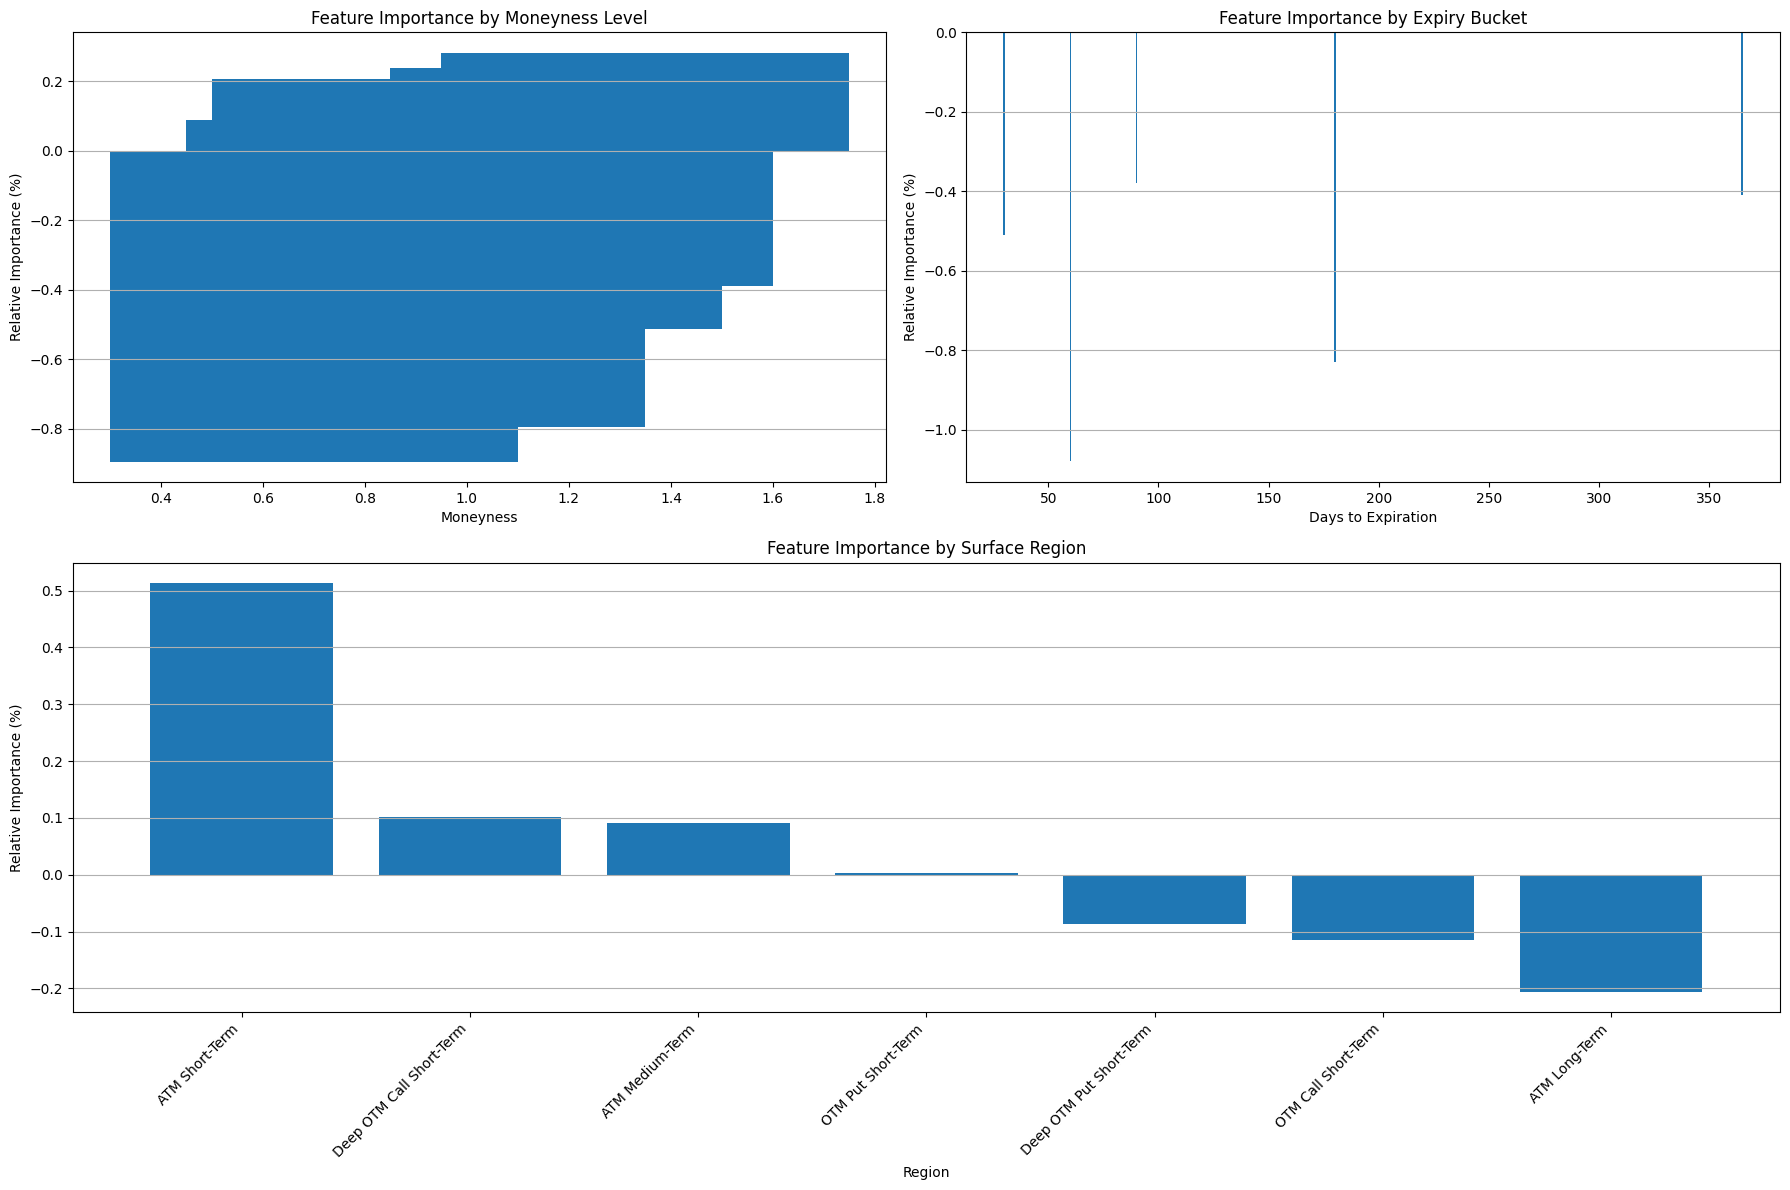


Most Important Features:
--------------------------------------------------
By Moneyness:
  1. Moneyness = 1.3500000000000005: 0.28%
  2. Moneyness = 1.2500000000000004: 0.24%
  3. Moneyness = 0.9000000000000001: 0.21%

By Expiry:
  1. Expiry = 90 days: -0.38%
  2. Expiry = 365 days: -0.41%
  3. Expiry = 30 days: -0.51%

By Region:
  1. ATM Short-Term: 0.51%
  2. Deep OTM Call Short-Term: 0.10%
  3. ATM Medium-Term: 0.09%
Calculating gradient-based feature importance...
Processing batch 1/10...
Processing batch 2/10...
Processing batch 3/10...
Processing batch 4/10...
Processing batch 5/10...
Processing batch 6/10...
Processing batch 7/10...
Processing batch 8/10...
Processing batch 9/10...
Processing batch 10/10...


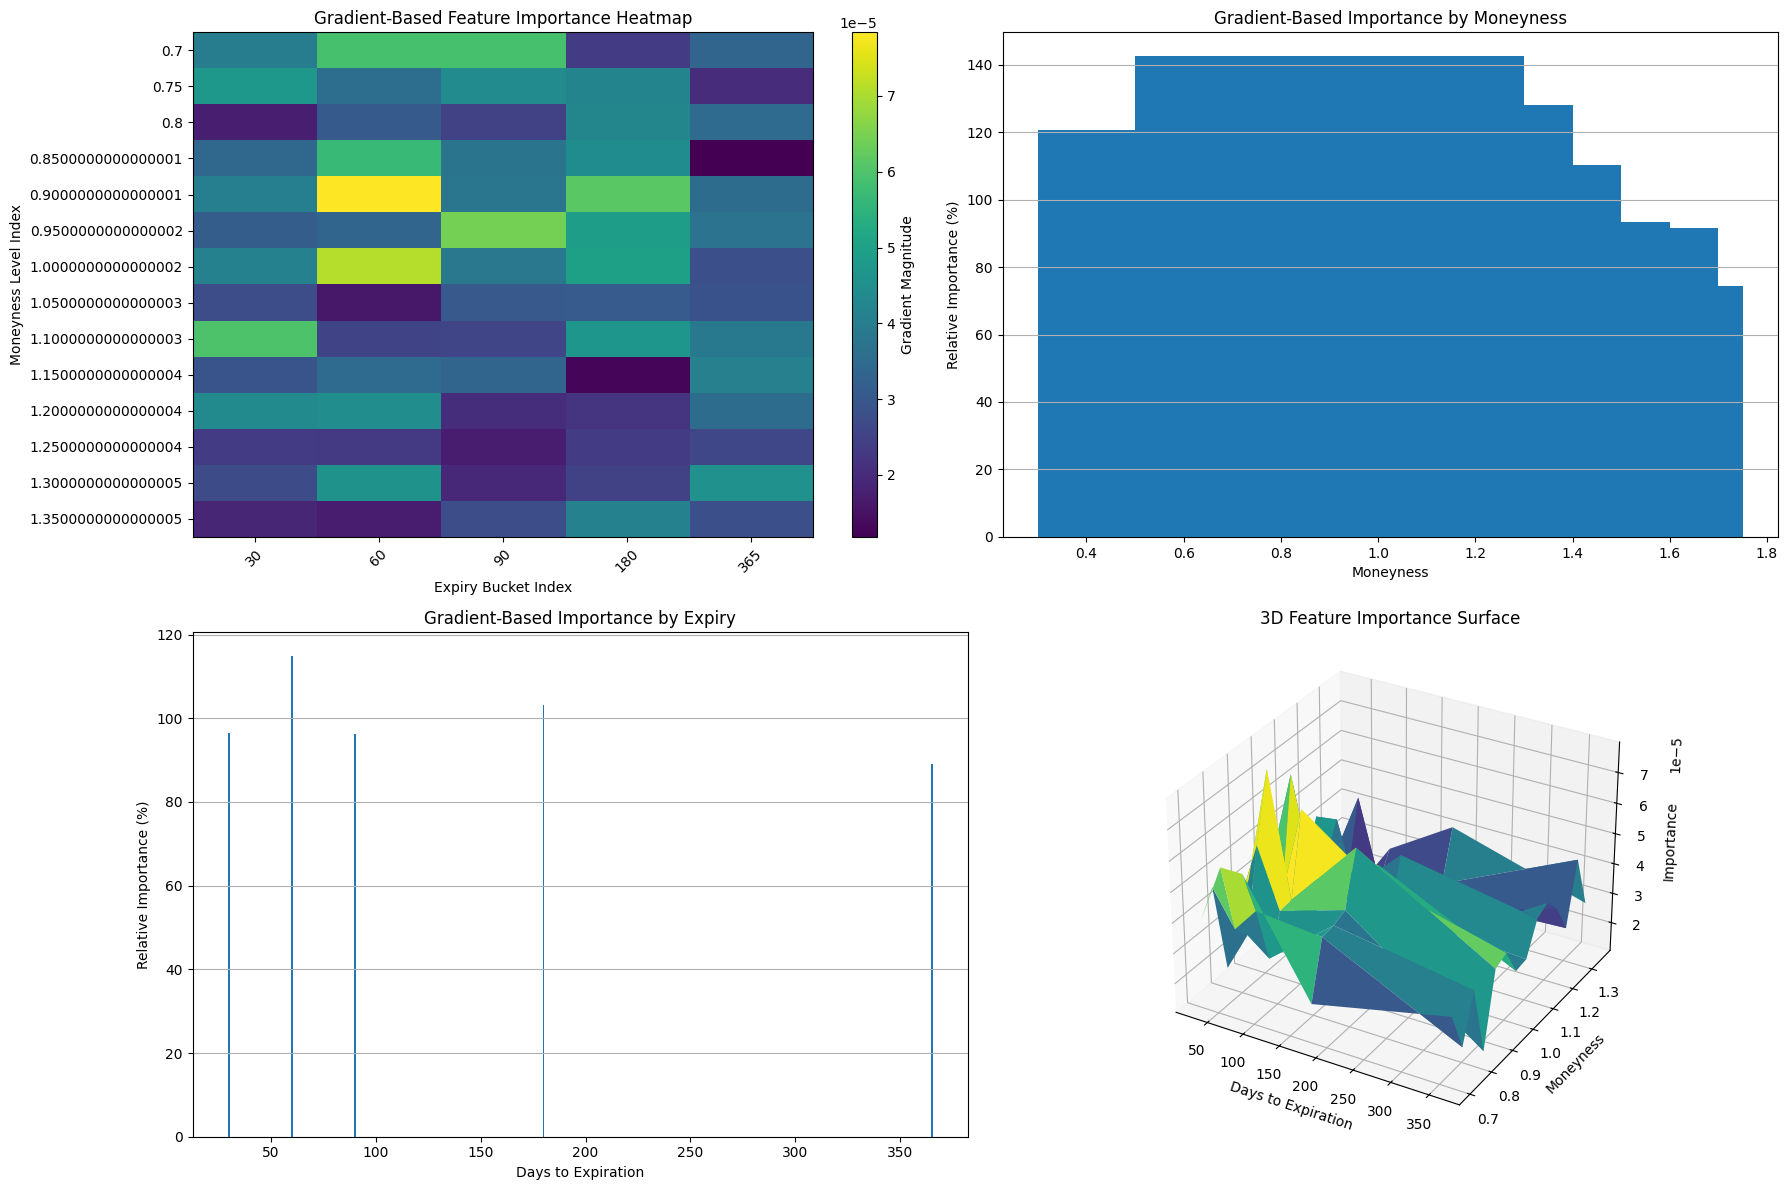


Gradient-Based Feature Importance Summary:
--------------------------------------------------
By Moneyness:
  1. Moneyness = 0.9000000000000001: 142.46%
  2. Moneyness = 1.0000000000000002: 128.08%
  3. Moneyness = 0.9500000000000002: 121.30%

By Expiry:
  1. Expiry = 60 days: 114.85%
  2. Expiry = 180 days: 103.12%
  3. Expiry = 30 days: 96.56%

Would you like to run SHAP analysis? This can be computationally intensive.
Enter 'y' to run SHAP analysis, any other key to skip: n
Skipping SHAP analysis.

COMPARING FEATURE IMPORTANCE METHODS


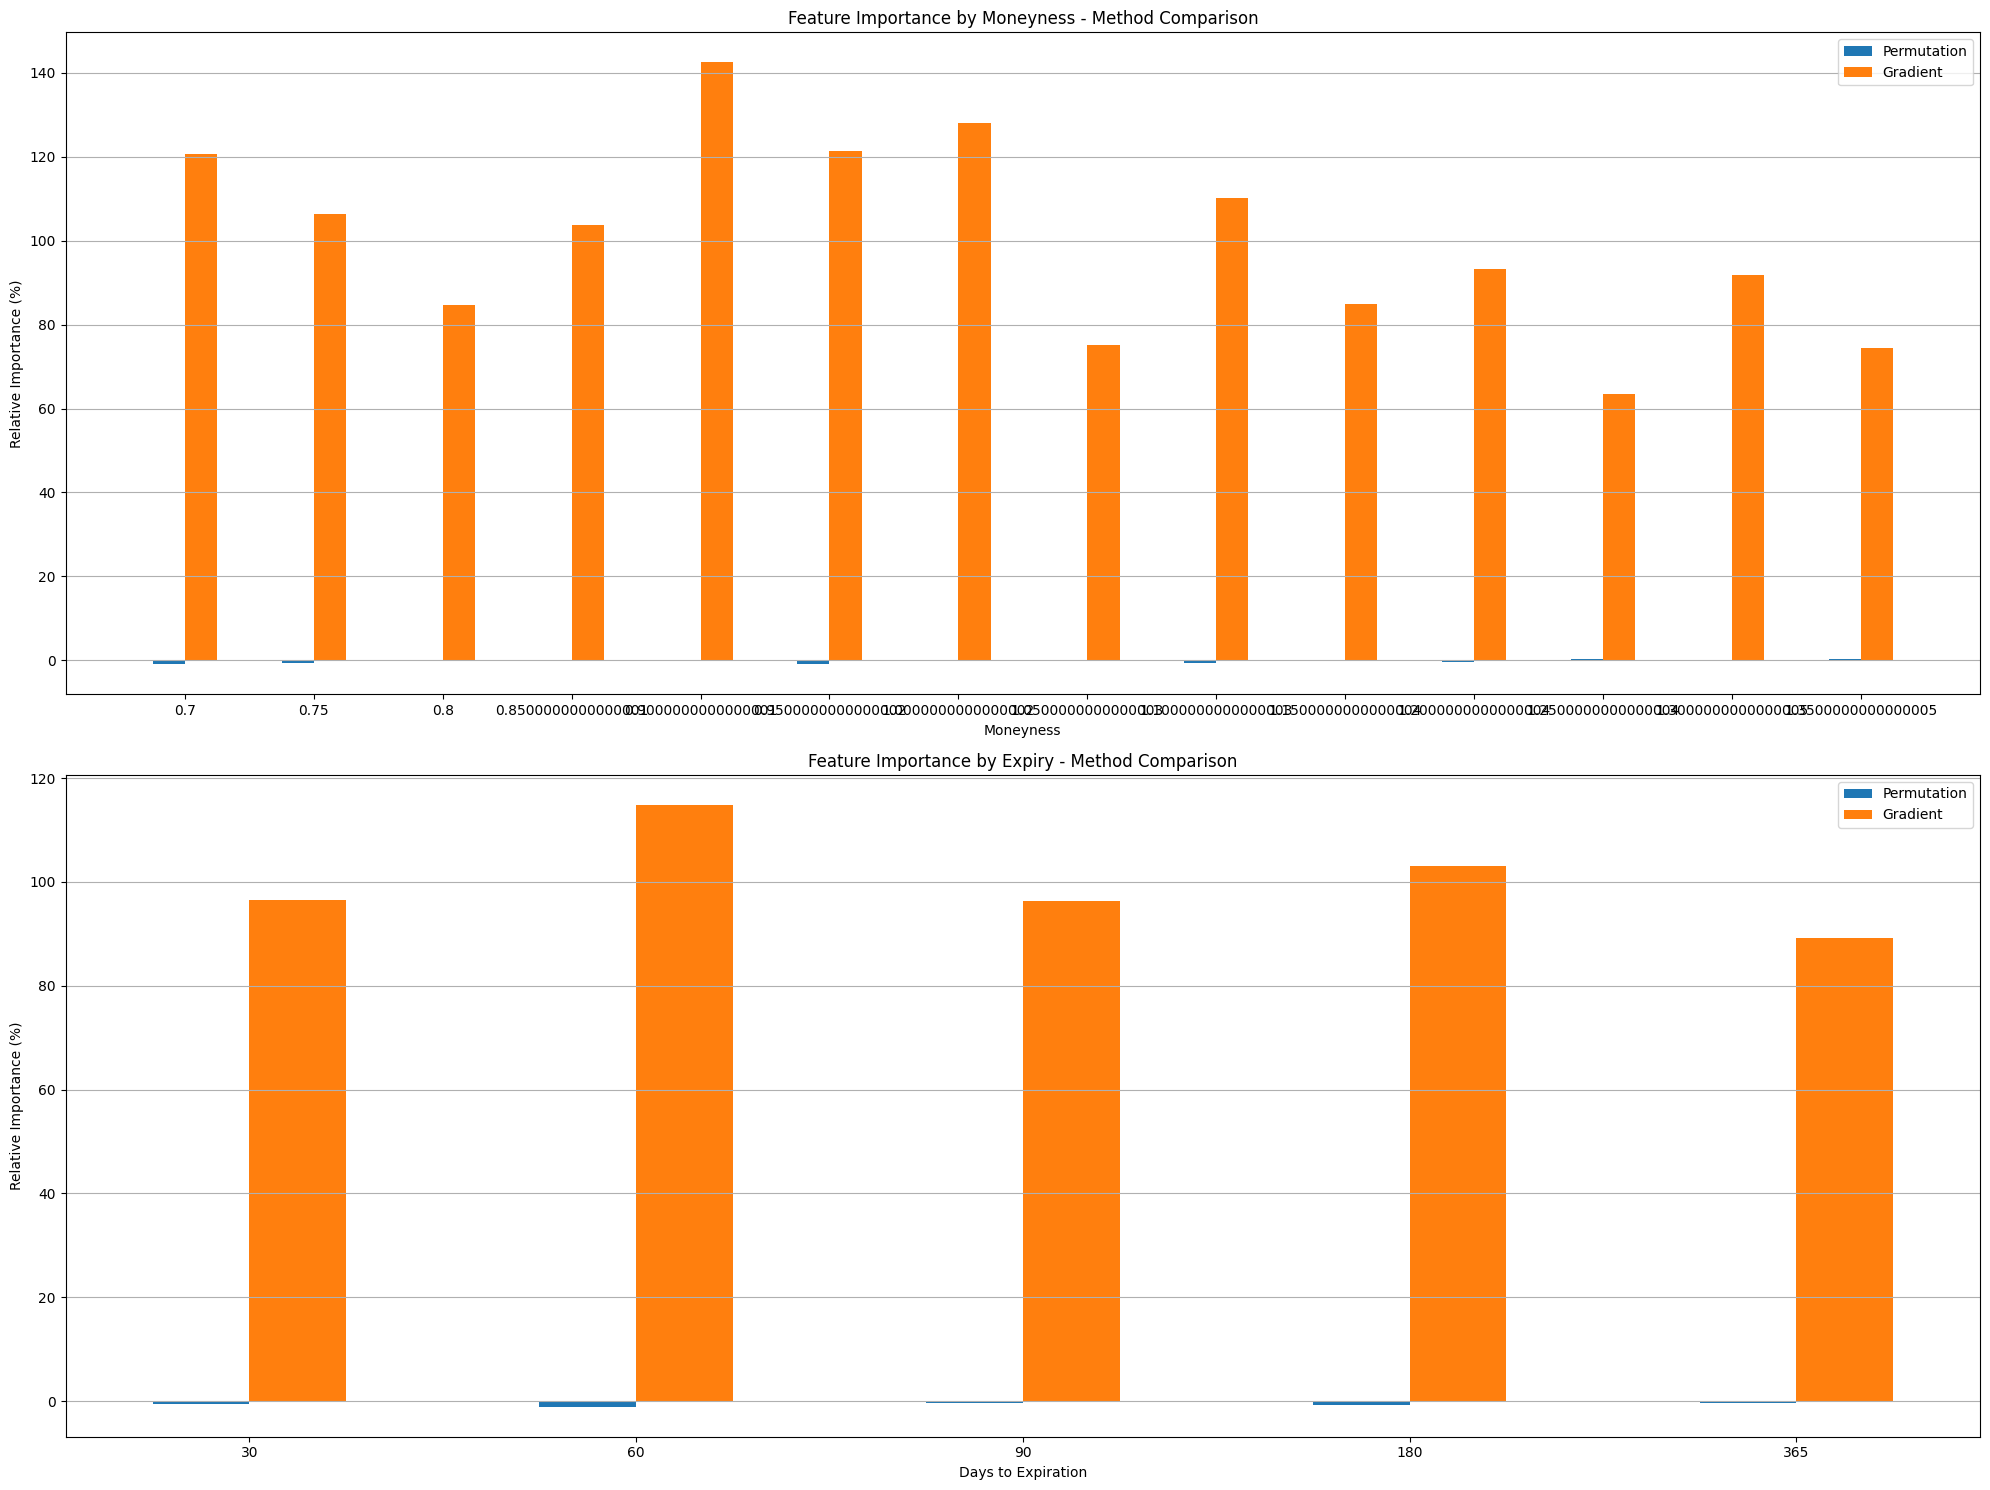


Combined Feature Importance Analysis Summary:
------------------------------------------------------------
Most Important Moneyness Levels:
  Permutation method: 1.3500000000000005, 1.2500000000000004, 0.9000000000000001
  Gradient method: 0.9000000000000001, 1.0000000000000002, 0.9500000000000002

Most Important Expiry Buckets:
  Permutation method: 90, 365, 30
  Gradient method: 60, 180, 30

Consensus Important Features (identified by multiple methods):
  Moneyness levels: 0.9000000000000001
  Expiry buckets: 30

Volatility Surface Interpretation:
  • At-the-Money (ATM) options show high importance, suggesting the ATM volatility
    level is a critical predictor of future volatility surfaces.
  • Short-term options (≤ 30 days) show high importance, indicating that
    near-term implied volatility is particularly informative for predictions.

==== ANALYZING MODEL 2 FROM ENSEMBLE 1 ====


RUNNING COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS

Performing permutation importance analysis...


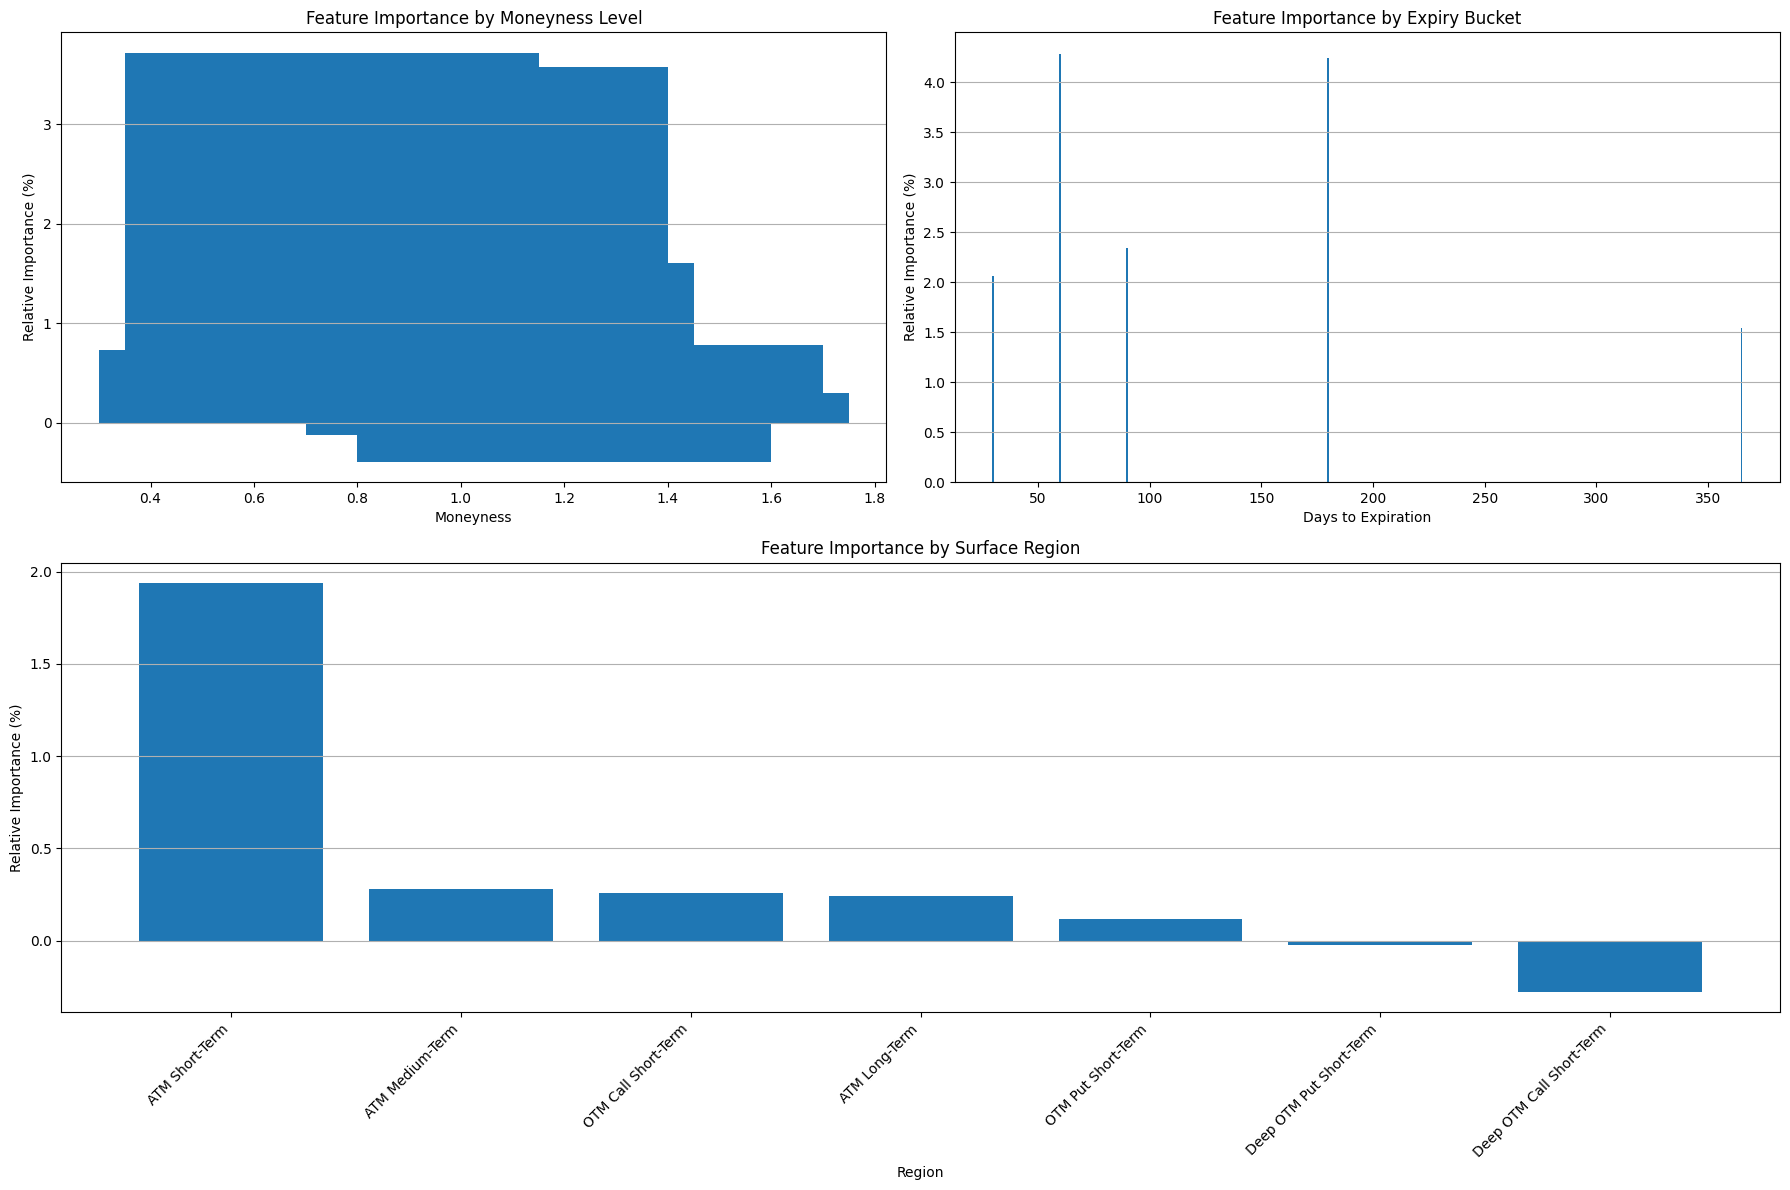


Most Important Features:
--------------------------------------------------
By Moneyness:
  1. Moneyness = 0.75: 3.72%
  2. Moneyness = 1.0000000000000002: 3.58%
  3. Moneyness = 0.9500000000000002: 2.61%

By Expiry:
  1. Expiry = 60 days: 4.28%
  2. Expiry = 180 days: 4.24%
  3. Expiry = 90 days: 2.34%

By Region:
  1. ATM Short-Term: 1.94%
  2. ATM Medium-Term: 0.28%
  3. OTM Call Short-Term: 0.26%
Calculating gradient-based feature importance...
Processing batch 1/10...
Processing batch 2/10...
Processing batch 3/10...
Processing batch 4/10...
Processing batch 5/10...
Processing batch 6/10...
Processing batch 7/10...
Processing batch 8/10...
Processing batch 9/10...
Processing batch 10/10...


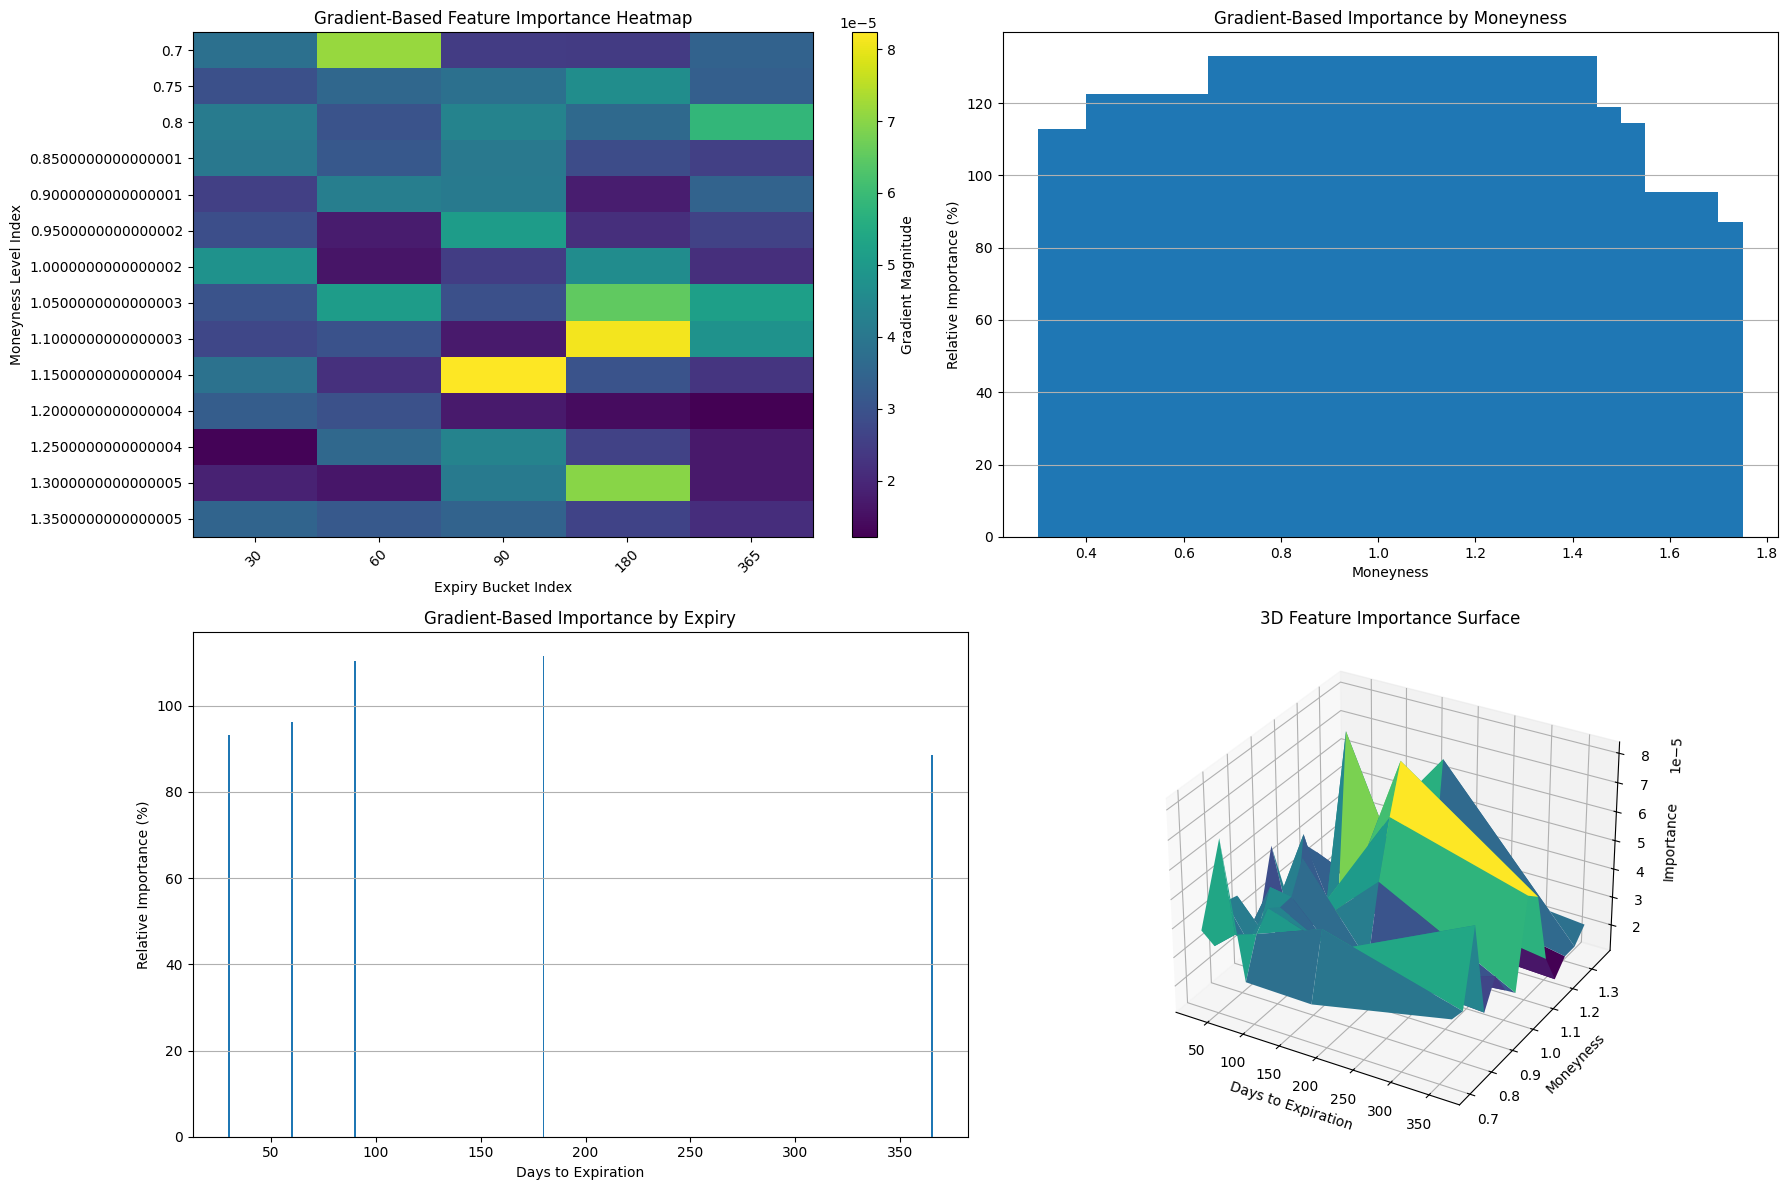


Gradient-Based Feature Importance Summary:
--------------------------------------------------
By Moneyness:
  1. Moneyness = 1.0500000000000003: 132.90%
  2. Moneyness = 0.8: 122.62%
  3. Moneyness = 1.1000000000000003: 118.84%

By Expiry:
  1. Expiry = 180 days: 111.49%
  2. Expiry = 90 days: 110.47%
  3. Expiry = 60 days: 96.18%

Would you like to run SHAP analysis? This can be computationally intensive.
Enter 'y' to run SHAP analysis, any other key to skip: n
Skipping SHAP analysis.

COMPARING FEATURE IMPORTANCE METHODS


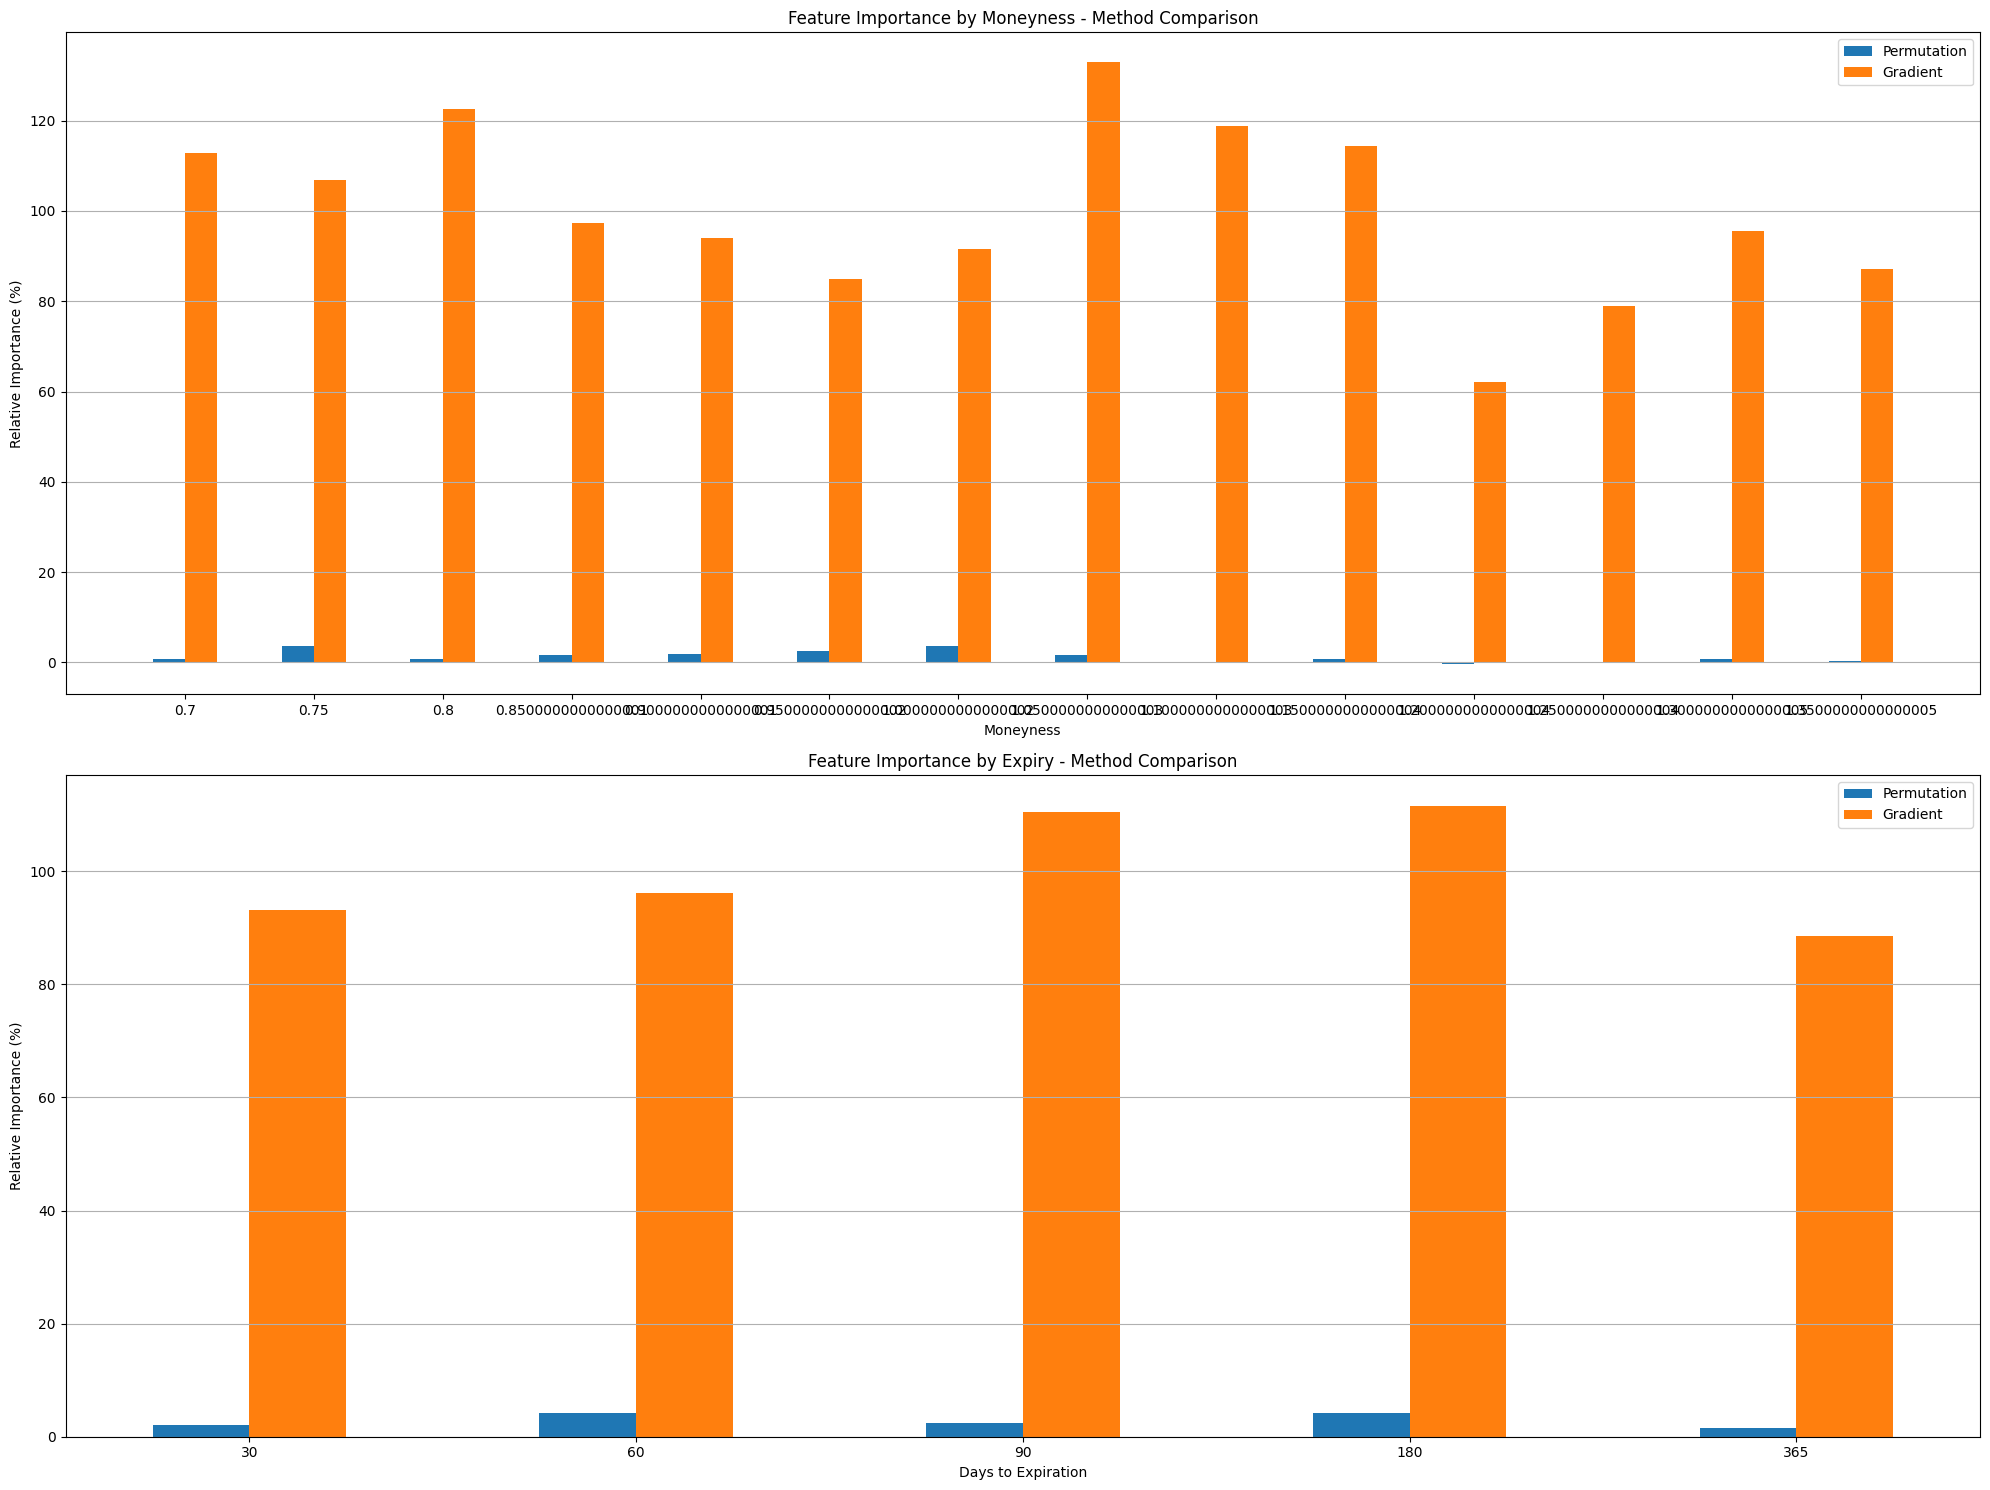


Combined Feature Importance Analysis Summary:
------------------------------------------------------------
Most Important Moneyness Levels:
  Permutation method: 0.75, 1.0000000000000002, 0.9500000000000002
  Gradient method: 1.0500000000000003, 0.8, 1.1000000000000003

Most Important Expiry Buckets:
  Permutation method: 60, 180, 90
  Gradient method: 180, 90, 60

Consensus Important Features (identified by multiple methods):
  No consensus on important moneyness levels
  Expiry buckets: 60, 90, 180

Volatility Surface Interpretation:
  • At-the-Money (ATM) options show high importance, suggesting the ATM volatility
    level is a critical predictor of future volatility surfaces.
  • Long-term options (≥ 180 days) are important, suggesting that the long end
    of the volatility term structure contains valuable predictive information.


In [ ]:
for i, model in enumerate(ensemble_model_list[:2]):
    print(f"\n==== ANALYZING MODEL {i+1} FROM ENSEMBLE 1 ====\n")

    importance_results = run_feature_importance_analysis(
        model=model,
        X_test=X_test,
        y_test=y_test,
        moneyness_levels=moneyness_levels,
        expiry_buckets=expiry_buckets
    )

    # Save results if needed
    exec(f"importance_results_ensemble1_model{i+1} = importance_results")